Artificial Intelligence II (YS19) - Homework 1

<u>Student credentials</u><br>
**FullName:** Spanos Nikolaos<br>
**Student AM:** 7115112100023<br>
**Student email:** cs2210023@di.uoa.gr <br><br>


**Supervisor:** Professor Manolis Koumparakis <br>
*All rights reserved from National and Kapodistrian University of Athens, Department of Computer Science (DI)*

Athens, Greece, November 2022

### Import Python modules

In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from gensim.models import Word2Vec

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

pd.set_option('display.max_colwidth', None)

In [126]:
!pip install --quiet emoji

from tqdm.notebook import tqdm
tqdm.pandas()
import re
import string
import emoji
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

     |████████████████████████████████| 240 kB 4.9 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import text preprocessing methods

In [ ]:
def text_preprocessing(table: pd.DataFrame) -> pd.DataFrame:
  """
  Definition
  ---------
  Apply the text processing methods to clean, normalize text and make it ready for machine learning models.
  The functions applied are: 
    * remove_emoji_characters()
    * transform_abbreviations()
    * remove_stop_words()
    * text_lemmatization()

  Aguments
  ---------
  table: The pandas dataframe to apply the functions.

  Return
  --------
  table: The pandas dataframe with a new column that will be cleaned and normalized. In the code, the new column has the name 'normalized_review'.
         The returned pandas dataframe will have three new columns: processed_review, removed_stopwords_review, normalized_review.
  """

  def remove_emoji_characters(phrase:str) -> str:
    """
    Source
    ---------
    https://stackoverflow.com/a/50602709/10623444

    Definition
    ---------
    Remove emoji characters from the textual content of the dataset. 
    Emoji's cannot be interpreted to a numerical features, plus they don't add any meanigful essence to the text whatsoever. 
    Emoji is an unnecessary form of informantion.

    Aguments
    ---------
    phrase: The string sentence value to remove emojis from it.

    Return
    --------
    Sentence without emojis.
    """
    return emoji.replace_emoji(phrase, replace="")

  def transform_abbreviations(phrase:str) -> str:
    """
    Source
    ---------
    My thesis: https://github.com/NikosSpanos/NLP_Applications/blob/main/multi-label-text-classification-on-movies/Part%203.1%20-%20Data%20Tokenization%20%26%20Sequence%20padding.ipynb

    Definition
    ---------
    Transform abbreviations is a function that will take common english abbreviations likes won't and transform them to their full context such as will not. 
    It would be easier to better clean reviews from common words and punctuations. The function also removes numerical text.

    Aguments
    ---------
    phrase: The string sentence to replace abbreviations from.

    Return
    --------
    Sentence without abbrevaitions.
    """
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"-", " ", phrase) #split words connected with a dash '-'. For example, action-paced => action paced
    phrase = re.sub(r"<br />", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br >", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br/>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"http\S+", "", phrase, flags=re.MULTILINE) # remove http(s) hyperlink tags
    phrase = re.sub(r"@\w+", "", phrase, flags=re.MULTILINE) # remove tagged tweeter users (@...)
    phrase = re.sub(r"\d+", "", phrase) # remove digit/numerical characters
    return phrase

  def remove_stop_words(phrase:str) -> str:
    """
    Definition
    ---------
    Remove commonly used words such as articles from the text.
    Stop wodrd occur frequently and don’t contribute much to the overall meaning of the sentence.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    phrase: Returns the sentence without the stop_words.
    """
    stop_words = set(stopwords.words('english')) # retrive the list of nltk stop_words
    cleaned_text = [word for word in word_tokenize(phrase.lower()) if word.lower() not in stop_words]

    return " ".join(cleaned_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  def text_lemmatization(phrase:str) -> str:
    """
    Definition
    ---------
    Apply lemmatization to the single tokens of a text. Lemmatization will identify the part-of-speech of a word and will replace it with its lemma.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    lemmas of phrase: Returns the sentence with lemmatized tokens/words.
    """
    lemmatizer      = WordNetLemmatizer() # initialize nltk lemmatizer method
    lemmatized_text = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tag(word_tokenize(phrase.lower()))]

    return " ".join(lemmatized_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  encoding = 'utf-8'
  
  # Apply functions remove_emoji_characters(), transform_abbreviations()
  table["processed_review"] = table["review"].progress_apply(lambda review: \
                                                              re.sub(" +", " ", \
                                                                  remove_emoji_characters( \
                                                                    transform_abbreviations( \
                                                                      str(review.encode("ascii", "ignore"), encoding) \
                                                                    ) \
                                                                  ).\
                                                                  translate(str.maketrans('', '', string.punctuation)).strip()
                                                                )
                                                              )
  print("\nReviews | After cleaning")
  print(table["processed_review"].iloc[0:3])
  print("\nReviews | Before cleaning")
  print(table["review"].iloc[0:3])

  # Apply function remove_stop_words()
  table["removed_stopwords_review"] = table["processed_review"].progress_apply(lambda review: remove_stop_words(review.lower()))
  
  print("\nReviews | After removing stop words")
  print(table["removed_stopwords_review"].iloc[0:3])
  print("\nReviews | Before removing stop words")
  print(table["processed_review"].iloc[0:3])

  # Apply function text_lemmatization()
  table["normalized_review"] = table["removed_stopwords_review"].progress_apply(lambda review: text_lemmatization(review.lower()))
  
  print("\nReviews | After text normalization-lemmatization")
  print(table["normalized_review"].iloc[0:3])
  print("\nReviews | Before text normalization-lemmatization")
  print(table["removed_stopwords_review"].iloc[0:3])

  return table

### Import model evaluation methods

In [112]:
def intuitive_confusion_matrix(validation_target, matrix:np.ndarray, label_categories:list, model_name:str):
  """
  Definition
  ---------
  Create a more intuitive confusion matrix for the model predictions. The plot will depict class names, predictions per class and the percentage of the prediction over the total quotes of a specific class.

  Aguments
  ---------
  validation_target : The target labels of the validation sample.
  matrix            : Output object of sklearn.metrics.confusion_matrix.
  label_categories  : Class names of the categories.
  model_name        : Model name based on the classifier used (i.e. Baseline model, Random Forest, Multinomial Naive Bayes, etc.).

  Output
  ---------
  Heatmap
  """
  x1=list(validation_target.sort_values().unique()) #labels
  #x2=[0,2] #this is not dynamic. Please be careful when run it with more than two labels. For example, for three labels the array would be [0,3,6]
  x2=[]
  for i in range(len(x1)):
    x2.append(x1[i]*len(x1))

  percentages = np.zeros(len(matrix.flatten()), dtype=float) #empty list of 0 to fill in the percentages
  for i in x1:
    percentages[x2] = matrix.flatten()[x2]/matrix.flatten()[x2].sum()
    x2 = [index+1 for index in x2]

  counts = ["{0:0.0f}\n".format(value) for value in matrix.flatten()]
  percentages = ["{0:.2%}".format(my) for my in percentages]

  box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(counts,percentages)]
  box_labels = np.asarray(box_labels).reshape(matrix.shape[0],matrix.shape[1])

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion matrix - {model_name}")
  sns.heatmap(matrix, annot=box_labels, square=True, fmt='', cbar=False, cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
  plt.xlabel('true labels')
  plt.ylabel('predicted labels')

def get_bias(predicted_values: np.array, true_values: np.array) -> float:
  """
  Definition
  ---------
  Calculates model bias.
  
  Aguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  true_values      : True values of target feature (y_validation, y_test)
  
  Output
  ---------
  bias: float representing the bias of the model
  """

  #return np.round(np.mean((predicted_values - true_values) ** 2), 4)
  SSE = np.round(np.mean((predicted_values - true_values) ** 2), 4)
  Variance = np.round(np.var(predicted_values), 4)
  Bias = abs(SSE - Variance)
  return np.round(Bias, 4)

def get_variance(predicted_values:np.array) -> float:
  """
  Definition
  ---------
  Calculates model variance based on the predicted values.
  
  Aguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  
  Output
  ---------
  variance: float representing the variance of the predicted values
  """

  return np.round(np.var(predicted_values), 4)
  #return np.round(np.mean((predicted_values - true_values) ** 2), 4)

def get_evaluation_metrics(true_labels:np.array, predicted_labels:np.array, predicted_labels_probabilities:np.array, model_name:str):
  """
  Definition
  ---------
  Compute the evaluation metrics for a specific model classifier. Briefly, the metrics returned are: precision, recall, roc_score, f1_metric calculated for a Multi-Class experiment.
  The function also returns the model bias and variance based on the classification predictions.
  
  Aguments
  ---------
  true_labels                    : Numpy array of the true labels of validation dataset
  predicted_labels               : Numpy array of the predicted labels of validation dataset (model.predict() method)
  predicted_labels_probabilities : Numpy array of the predicted label probabilities of validation dataset (model.predict_proba() method)
  model_name                     : String of the model name to distinguish the results per different model classifier
  
  Output
  ---------
  Print the results to stdout of the Notebook console.
  """

  precision_base = precision_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
  recall_base    = recall_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
  f1_metric      = f1_score(true_labels, predicted_labels, average='macro')

  print(f"Evaluation metrics: {model_name} \n\nprecision score: {precision_base:.4f} \nrecall_score: {recall_base:.4f} \nf1_score: {f1_metric:.4f}")
  print(f"\nmodel bias: {get_bias(predicted_labels, true_labels)}")
  print(f"model variance: {get_variance(predicted_labels)}")
  print("\n")

def evaluation_report(model_estimator, vectorizer, validation_samples, true_labels:np.array, model_name:str):
  # Model evaluation using the validation sample
  validation_reviews = validation_samples.values
  validation_vector_reviews = vectorizer.transform(validation_reviews)
  predicted = model_estimator.predict(validation_vector_reviews)
  predicted_prob = model_estimator.predict_proba(validation_vector_reviews)

  # Evaluation metrics
  prediction_matrix = confusion_matrix(true_labels, predicted, labels=true_labels.sort_values().unique())
  categories = ['negative', 'positive']

  intuitive_confusion_matrix(true_labels, prediction_matrix, categories, model_name)
  print(classification_report(true_labels, predicted, target_names=categories))

  get_evaluation_metrics(true_labels, predicted, predicted_prob, model_name)

def evaluation_report_word2vec(model_estimator, validation_samples, true_labels:np.array, model_name:str):
  # Model evaluation using the validation sample
  predicted = model_estimator.predict(validation_samples)
  predicted_prob = model_estimator.predict_proba(validation_samples)

  # Evaluation metrics
  prediction_matrix = confusion_matrix(true_labels, predicted, labels=true_labels.sort_values().unique())
  categories = ['negative', 'positive']

  intuitive_confusion_matrix(true_labels, prediction_matrix, categories, model_name)
  print(classification_report(true_labels, predicted, target_names=categories))

  get_evaluation_metrics(true_labels, predicted, predicted_prob, model_name)

# Calculate learning curve values
def plot_learning_curve(n_splits:int, test_size:float, train_buckets:int, trainable_vectors, target_sample, model_estimator, graph_name:str):

  cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=np.random.RandomState(0))

  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
      estimator=model_estimator
      ,X=trainable_vectors
      ,y=target_sample.values
      ,cv=cv
      ,n_jobs=-1
      ,train_sizes=np.linspace(0.1, 1.0, train_buckets)
      ,scoring="f1"
      ,return_times=True
      ,shuffle=True
      ,random_state=np.random.RandomState(0)
    )

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

  # Plot learning curve
  _, axes = plt.subplots(1, 1, figsize=(10, 10))
  axes.grid()
  axes.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r",
  )
  axes.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",
  )
  axes.plot(
      train_sizes, train_scores_mean, "o-", color="r", label="Training f1-score"
  )
  axes.plot(
      train_sizes, test_scores_mean, "o-", color="g", label="Validation f1-score"
  )
  axes.legend(loc="best")
  axes.set_xlabel('Training examples')
  axes.set_ylabel('F1 score')
  axes.set_title(f"Learning curve - {graph_name}\n")

### Import useful/saving filepaths

In [3]:
checkpoint_1 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/imdb-reviews.csv" #file with all the imbd reviews
checkpoint_2 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_1500vectors.pkl"
checkpoint_3 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_2500vectors.pkl"
checkpoint_4 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_500vectors.pkl"
checkpoint_5 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/word2vec_300size.model"
checkpoint_6 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/data_sample.pkl"
checkpoint_7 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/train_review_word2vec.csv"
checkpoint_8 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/tfidfVectorizer_1500vectors.pkl"

checkpoint_9 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/word2vec_64size.model"
checkpoint_10 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/train_review_word2vec_64vectorsize.csv"

checkpoint_11 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/word2vec_300size_cbow.model"
checkpoint_12 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/train_review_word2vec_300vectorsize_cbow.csv"

### Section 1: Import & explore the dataset

In [4]:
data = pd.read_csv(os.path.join(os.getcwd(), checkpoint_1), sep="\t", header=0) #checkpoint 1
print("data shape: %s" %(str(data.shape)))
print(data.head(1))
print("\n")
print(data['rating'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

data shape: (45008, 3)
                                                url  rating  \
0  http://www.imdb.com/title/tt0120623/usercomments    10.0   

                                                                                                                                            review  
0  I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes' at the end of the movie. They were GREAT.  


1.0     20.79%
10.0    19.51%
8.0     11.67%
4.0     10.24%
3.0      9.72%
7.0      9.56%
9.0      9.27%
2.0      9.23%
Name: rating, dtype: object


We have the same percent of very negative reviews (rating = 1.0) and very positive reviews (rating = 10.0). The rest of the ratings are found in almost 10% of the dataset. The dataset isn't balanced over the labels. However, we should examine more of this imbalance after applying the categorization of negative and positive ranges. More specifically,

* 0.0-4.0: Negative
* 7.0 - 10.0: Positive

In [ ]:
#Create two categories for the rating column
# 1: Positive review
# 0: Negative review
target_column  = 'rating'
conditions     = [ (data[target_column] >= 0.0) & (data[target_column] <= 4.0)
                  ,(data[target_column] >= 7.0) & (data[target_column] <= 10.0) 
                 ]
choices        = [ 0, 1 ]

data['target'] = np.select(conditions, choices)

# Review the distribution of the reviews among the two labels
data['target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

1    50.01%
0    49.99%
Name: target, dtype: object

The dataset is almost balanced among the two target classes positive and negative respectively. With the positive reviews to slightly dominate. To resolve this dominance, I have selected the top 20,000 reviews per sentiment group. The main reason to resolve the dominance of the positive class is because I don’t want any model classifier to be biased over the positive class.

### Section 2: Preparing data samples

This section includes three steps:

* Remove duplicate reviews
* Resampling dataset
* Random shuffle data samples

**1. Remove duplicate reviews** from the dataset.
> Function: remove_duplicates()

Firstly, check that there are identical rows (rows with identical values in all columns) in the dataset.
Secondly, remove the rows with identical reviews.

In that way we achieve a unique representation of each review in the dataset.

</br>**2. Resampling dataset** by keeping top 20,000 rows per target sentiment. Resampling will also erase the data imbalance among the two sentiments.
> Function: resampling_target()

</br>**3. Shuffle** the data samples to secure that the classifier won't get biased by a strictly ordered dataframe. We should create dispersion among the two sentiments. Based on how the function ```resampling_target()``` is engineered, it creates an order in the sentiments samples. For example, first all the positive sentiments are sampled and then all the negatives. Which means that the rows of the returned object are ordered per label. This raises the need to apply random shuffling.
> Function: shuffle_rows()

Those three steps should be applied on any dataset in general. They are not case specific to this dataframe, but rather can be generalized to any other dataframe.

In [6]:
from sklearn.utils import shuffle

def data_preparation(table: pd.DataFrame) -> pd.DataFrame:
  """
  Definition
  ---------
  Apply the data processing methods to clean the dataframe and prepare it for the next steps.
  Dataframes in general carry many noise, such as duplicate rows, imbalanced target variables, and strict order of their rows.
  This function removes such noise from the dataframe.

  The functions applied are: 
    * remove_duplicates()
    * resampling_target()
    * shuffle_rows()

  Aguments
  ---------
  table: The pandas dataframe to apply the functions.

  Return
  --------
  table: The pandas dataframe with a new column that will be cleaned and normalized. In the code, the new column has the name 'normalized_review'.
         The returned pandas dataframe will have three new columns: processed_review, removed_stopwords_review, normalized_review.
  """

  def remove_duplicates(table: pd.DataFrame, subset_column: str) -> pd.DataFrame:
    """
    Definition
    ----------
    This function will remove duplicate records based on the name of subset column given. 
    Firstly, the function will return the number of duplicate rows found.
    Secondly, will drop the duplicate rows.

    Arguments
    ---------
    table: Pandas DataFrame.
    subset_column: Only consider certain columns for identifying duplicates, by default use all of the columns.
    Define the column you don't desire to have duplicates. In this example we don't want to have two times the same review.

    Return
    --------
    Cleaned DataFrame without duplicate rows.
    """
    table_duplicates=table.groupby(table.columns.tolist(), as_index=False, dropna=False).size()
    
    duplicate_rows = table_duplicates.loc[table_duplicates['size'] > 1].shape[0]
    print(f"Total number of duplicate rows: {duplicate_rows}")
    
    if duplicate_rows > 0: #check that dataset has indeed duplicate rows across all columns
      table_without_duplicates = table.drop_duplicates(subset=subset_column, keep='first')
    
    assert_duplicates_removed = table_without_duplicates.groupby(table_without_duplicates.columns.tolist(), as_index=False, dropna=False).size()
    assert assert_duplicates_removed.loc[assert_duplicates_removed['size'] > 1].shape[0] == 0, "Duplicate rows still exist in your dataset"
    return table_without_duplicates

  def resampling_target(table: pd.DataFrame, target_column: str, sample = 25000) -> pd.DataFrame:
    """
    Definition
    ----------
    This function will resample the dataset based on each target sentiment category. 
    Thus, a target column should be specified and then the number of different labels of this target column.
    The dataset will take a fix number of rows per target label.

    Arguments
    ---------
    table: Pandas DataFrame.
    target_column: Target column with N different labels to take an equal portition from each label.
    sample: The rows taken from each different label. Select a number of samples that all the labels will have.
            Rows/target <= sample value
            For example, all labels should have at least 25,000 rows.

    Return
    --------
    Re-sampled dataframe total rows = sample * length of the target column.
    """
    target_labels = table[target_column].unique()
    appended_array = []

    for label in target_labels:
      sample_label = table[table[target_column] == label].head(sample)
      appended_array.append(sample_label)

    data_sample = pd.concat(appended_array)
    
    # sample_positive = table[table[target_column] == 1].head(sample)
    # sample_negative = table[table[target_column] == 0].head(sample)
    # data_sample = pd.concat( [ sample_positive, sample_negative ] )
    return data_sample

  def shuffle_rows(table: pd.DataFrame) -> pd.DataFrame:
    """
    Definition
    ----------
    This function will shuffle the rows of the dataframe in a random order.

    Arguments
    ---------
    table: Pandas DataFrame.

    Return
    --------
    Shuffled dataframe.
    """
    table_shuffled = shuffle(table, random_state=np.random.RandomState(0))
    table_shuffled.reset_index(drop=True, inplace=True)
    return table_shuffled

  # Apply function remove_duplicates()
  table_without_duplicates = remove_duplicates(table, "review")
  print("\nShape of data without duplicates: ", table_without_duplicates.shape)

  # Apply function resampling_target()
  table_sample = resampling_target(table_without_duplicates, "target", 20000)
  print("\nSentiment frequency")
  print(table_sample['target'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

  # Apply function shuffle_rows()
  table_suffle = shuffle_rows(table_sample)
  print("\nShape of the shuffled dataframe: ", table_suffle.shape)

  return table_suffle

> Call function data_preparation()

In [ ]:
data_sample = data_preparation(data)

As you can notice the two classes are now balanced with 50.0% of reviews each.

### Section 3: Preprocessing data sample

Changes to be applied on reviews (textual data) for the Baseline model classifier:
 - Remove emojis.
 - Remove special character in general.

Changes to be applied on reviews (textual data) for improving Baseline model classifier results:
  - Lowercase review comments.
  - Transform abbreviations.
  - Remove stop words (most frequent words such as part of speech, i.e. a, the, it, she, an, and, etc).
  - Remove numerical characters from text (i.e. 1, 2, 100, 124, etc.).
  - Text normalization technique | Lemmatization or Stemming.

#### Cleaning methods applied below:

* remove_emoji_characters(): Remove emoji characters if any from the reviews.
* transform_abbreviations(): Transform abbreviations and replace some specific word patterns/symbols with empty string. Also remove numbers.
* translate(): Fastest way to remove punctuations from the reviews.
* encode(): remove special ASCII characters such as ''

</br> 
#### Text Normalization technique - Lemmatization

_Lemmatization_ will be applied instead of stemming. The basic difference of those two methods is that Lemmatization takes into account the part-of-speech identity of a word before applying the normalization. Whereas _Stemming_ is a more heuristic approach that strips off the suffix from a word without taking into consideration any additional info about the token's placement in the sentence.
A simple example:

- cries => cri (stemming)
- cries => cry (lemma)

> Call function text_preprocessing()

In [ ]:
cleaned_data_sample = text_preprocessing(data_sample)

#### Save to local disk the pre-processed dataframe for future use

In [ ]:
cleaned_data_sample.to_pickle("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/data_sample.pkl")

### Section 4: Import the saved pre-processed data sample from disk

In [14]:
data_sample = pd.read_pickle(checkpoint_6)

### Section 5: X feature(s) & target y

For the machine learning model we will keep only the predictors and the target variables. In this experiment the predictor(s) is the user's imdb review and the target is represented by the rating value of the movie.

Our goal is to predict the movie's rating using the sentiment of the review.

In [15]:
x_features = data_sample["normalized_review"]
y_features = data_sample["target"]

#### Train - Test split

##### Initial approach (80-20)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_features,
    y_features,
    shuffle=True,
    test_size=0.2,
    random_state=123,
    stratify = y_features
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

##### Approach after ploting the lurning curves (90-10)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x_features,
    y_features,
    shuffle=True,
    test_size=0.1,
    random_state=123,
    stratify = y_features
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (36000,)
x_test shape:  (4000,)
y_train shape:  (36000,)
y_test shape:  (4000,)


#### Train - Validation split (80 - 20)

> Note: 
* x_train_fit -> (Subset of ```x_train```). Will be used to explicitely train the model classifierm using the ```fit()``` method.
* x_val -> (Subset of ```x_train```). Will be used to explicitely select model classifiers.
* x_train -> (Superset of ```x_train_fit``` and ```x_val```). Will be used later for cross validation.

In [ ]:
x_train_fit, x_val, y_train_fit, y_val = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2,
    random_state=123,
    stratify = y_train
)

print("x_train_fit shape: ", x_train_fit.shape)
print("x_val shape: ", x_val.shape)
print("y_train_fit shape: ", y_train_fit.shape)
print("y_val shape: ", y_val.shape)

x_train_fit shape:  (28800,)
x_val shape:  (7200,)
y_train_fit shape:  (28800,)
y_val shape:  (7200,)


#### Get review values to fit_transform the vectorizers

In [16]:
reviews = x_features.values # Use all the sentences/reviews of the sample

### Prepare text for mathematical models

> Classification models, and in general mathematical models, do not understand textual content. To address this we have to transform the textual samples into numerical vectors and then feed the vectors to a model classifier. <br>
(very well explained [here](https://medium.com/swlh/sentiment-classification-using-feed-forward-neural-network-in-pytorch-655811a0913f)) <br>
Why do you need to preprocess this text? — Not all the information is useful in making predictions or doing classifications. Reducing the number of words will reduce the input dimension to your model. The way the language is written, it contains lot of information which is grammar specific. Thus when converting to numeric format, word specific characteristics like capitalisation, punctuations, suffixes/prefixes etc. are redundant. Cleaning the data in a way that similar words map to single word and removing the grammar relevant information from text can tremendously reduce the vocabulary.

Preprocessed steps applied so far for the baseline model training:
  - Removed duplicate reviews.
  - Removed emojis.
  - Removed special characters and extra spaces from each review.
  - Replaced abbreviations with full context words.
  - Removed ASCII characters.
  - Removed punctuations.
  - Applied Lemmatization.

> Keep in mind that the above steps of preprocessing is an initial approach to prepare text data for training a baseline classification model. More steps of text normalization/preparation will be applied to fine tune model classifiers trained after the baseline model.

Two well-known approaches to prepare text content for mathematical models and Machine Learning algorithms:
1. Bag-of-Words (traditional approach)
2. Word2Vec - word vectors (robust approach)

For this experiment we will apply both the traditional approach using the TF-IDF methodology and the Word2Vec methodology. 

> More details and a description of this approach may found in the attached documentation.

### Section 6: Text Tokenization & Vectorization

Tokenization is the process to transform a set of documents/sentences to separate words called tokens. Then the tokens are transformed to a set of vectors. The vectors are arrays of numbers representing a sentence. Each vector is the input laer for a machine learning model.

Three methods will be used to assess their performance on the machine learning models.

</br>The first approach is the text tokenization and vectorization using the ```CountVectorizer```.

</br>The second approach is the text tokenization and vectorization using the  ```TF-IDF Vectorizer```


</br>The third approach is the text tokenization and vectorization using the ```Word2Vec``` apporach.

</br>The first two approaches belong to the tranditional family of Bag-of-Words (BoW). This is because they use the words of a sentence to represent them as vectors based on their position (index) and their frequency. The third approach is more robust since it uses algorithmic methods to train ML models on each sentence and extract some meaning from them.




#### 6.1 CountVectorizer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

The initial shape of the vocabulary is 2,609,487 tokens (including bigrams and unigrams). This is a quite large vocabulary and the are two reasons for that.
* First reason: We included unigrams and bigrams. This greatly increased the volumn of the vocabulary.

* Second reason: No filterting for the frequent or infrequent words have been used. We can achieve this by using the <i>min_df</i> or <i>max_df</i> properties of the ```CountVectorizer``` function.

After the use of min_df = 5, max_df = 0.95 and max_features = 1500 The vocabulary dropped from 2,609,487 to 1500 words. A more manageable vocabulary of 20,000 more frequent words.

Plus, keep in mind that many unique words could be actor names, formal english vocabulary, genres, etc. In general words with no so much meaning or strictly used on a specific review. Note that our goal is to distinguish between positive and negative reviews. Thus, we need to find words that are not shared among the two sentiments.

> Max features is a very important parameter. It basically defines the length of the sparse vectors. All the vectors, each representing a setence, have the same length after the vectorization. This is very important for machine learning algorithms.

In [ ]:
vectorizer = CountVectorizer(
    lowercase = True,
    analyzer = 'word',
    ngram_range = (1,2), # unigrams & bigrams
    min_df = 5, # When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature.
    max_df = 0.95, # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    max_features = 1500
)

# tokenize and build vocab
vectorizer.fit(reviews)

print("index of word 'good': ", vectorizer.vocabulary_["good"]) # index of a unigram word in the our created vocabulary
print("index of word 'good movie': ", vectorizer.vocabulary_["good movie"]) # index of a bigram word in the created vocabulary

print("total vocabulary length: ", len(vectorizer.vocabulary_))

index of word 'good':  563
index of word 'good movie':  566
total vocabulary length:  1500


#### Save CountVectorizer object for ad-hoc reloading the vocabulary.

In [ ]:
dump(vectorizer, checkpoint_2)

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_1500vectors.pkl']

#### Load CountVectorizer

In [ ]:
vectorizer = load(checkpoint_2)

#### 6.2 TF-IDF Vectorizer

TF-IDF, Term Frequency - Inverse Document Frequency, stands for a statistical approach that evaluates the number of times a word is found in a collection of documents.

> TF-IDF method parameters used: <br>
  - ngram_range = (1,2). Retrieve uni-grams and bi-grams (i.e. 'posterior', 'probability', 'posterior probability').
  - lowercase = true (default)
  - max_df = 0.95 (default)
  - min_df = 5 (default)
  - max_features = 1500

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase = True,
    analyzer = 'word',
    ngram_range=(1,2),
    min_df = 5,
    max_df = 0.95,
    max_features = 1500
)

# tokenize and build vocab
tfidf_vectorizer.fit(reviews)

print("index of word 'good': ", tfidf_vectorizer.vocabulary_["good"]) # index of a unigram word in the our created vocabulary
print("index of word 'good movie': ", tfidf_vectorizer.vocabulary_["good movie"]) # index of a bigram word in the created vocabulary

print("total vocabulary length: ", len(tfidf_vectorizer.vocabulary_))

index of word 'good':  563
index of word 'good movie':  566
total vocabulary length:  1500


#### Save TF-IDF vectorizer object for ad-hoc reloading the vocabulary.

In [ ]:
dump(tfidf_vectorizer, checkpoint_8)

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/tfidfVectorizer_1500vectors.pkl']

#### Load TF-IDF vectorizer

In [ ]:
tfidf_vectorizer = load(checkpoint_8)

#### 6.3 Word2Vec Vectorizer

*Word2vec is a technique for natural language processing published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that they capture the semantic and syntactic qualities of words; as such, a simple mathematical function (cosine similarity) can indicate the level of semantic similarity between the words represented by those vectors.* 
- Source 1: https://en.wikipedia.org/wiki/Word2vec
- Source 2: https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
- Source 3: https://radimrehurek.com/gensim/models/word2vec.html

#### 6.3.1 SkipGram with 300 vector size

In [ ]:
data_sample["normalized_review_tokens"] = data_sample["normalized_review"].apply(lambda review: review.split(' '))

In [ ]:
vector_size = 300
min_count = 10
workers = 4
window = 3
sg = 1 #SkipGram
seed = np.random.RandomState(0)

review_tokens = [review.split(' ') for review in x_features.values ]
w2v_model = Word2Vec(
    sentences = review_tokens,
    min_count = min_count,
    size = vector_size,
    workers = workers,
    window = window,
    sg = sg
)
w2v_model.save(checkpoint_5)

In [ ]:
sg_w2v_model = Word2Vec.load(checkpoint_5)

print("index of word 'good'", sg_w2v_model.wv.vocab["good"].index)
print("vector size for word 'good'",len(sg_w2v_model.wv['good']))
print("total vocabulary size", len(sg_w2v_model.wv.vocab))

with open(checkpoint_7, 'w+') as word2vec_file:

  for index, row in data_sample.iterrows():

    #model_vector = (np.mean([sg_w2v_model.wv[token] for token in row["normalized_review_tokens"]], axis=0)).tolist()
    model_vector = (np.mean([sg_w2v_model.wv[token] if token in sg_w2v_model.wv.vocab else np.zeros(sg_w2v_model.wv.vector_size) for token in row["normalized_review_tokens"]], axis=0)).tolist()
    
    if index == 0:
        header = ",".join(str(ele) for ele in range(sg_w2v_model.wv.vector_size))
        word2vec_file.write(header)
        word2vec_file.write("\n")
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
    else:
        line1 = ",".join([str(0) for i in range(sg_w2v_model.wv.vector_size)])
    word2vec_file.write(line1)
    word2vec_file.write('\n')

#### 6.3.2 SkipGram with vector_size = 64 & min_count 100

In [ ]:
vector_size = 64 #multiple of 4 for greater performance
min_count = 100 #reduce noise.
workers = 4
window = 3
sg = 1 #SkipGram
seed = np.random.RandomState(0)

review_tokens = [review.split(' ') for review in x_features.values ]
w2v_model = Word2Vec(
    sentences = review_tokens,
    min_count = min_count,
    size = vector_size,
    workers = workers,
    window = window,
    sg = sg
)
w2v_model.save(checkpoint_9)

In [ ]:
sg_w2v_model = Word2Vec.load(checkpoint_9)

print("index of word 'good'", sg_w2v_model.wv.vocab["good"].index)
print("vector size for word 'good'",len(sg_w2v_model.wv['good']))
print("total vocabulary size", len(sg_w2v_model.wv.vocab))

with open(checkpoint_10, 'w+') as word2vec_file:

  for index, row in data_sample.iterrows():

    #model_vector = (np.mean([sg_w2v_model.wv[token] for token in row["normalized_review_tokens"]], axis=0)).tolist()
    model_vector = (np.mean([sg_w2v_model.wv[token] if token in sg_w2v_model.wv.vocab else np.zeros(sg_w2v_model.wv.vector_size) for token in row["normalized_review_tokens"]], axis=0)).tolist()
    
    if index == 0:
        header = ",".join(str(ele) for ele in range(sg_w2v_model.wv.vector_size))
        word2vec_file.write(header)
        word2vec_file.write("\n")
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
    else:
        line1 = ",".join([str(0) for i in range(sg_w2v_model.wv.vector_size)])
    word2vec_file.write(line1)
    word2vec_file.write('\n')

index of word 'good' 9
vector size for word 'good' 64
total vocabulary size 5030


#### 6.3.3 CBOW (Continuous bag of words) with vector_size = 300 & min_count 100 

In [ ]:
vector_size = 300 #multiple of 4 for greater performance
min_count = 100 #reduce noise.
workers = 4
window = 3
sg = 0 #CBOW
seed = np.random.RandomState(0)

review_tokens = [review.split(' ') for review in x_features.values ]
w2v_model = Word2Vec(
    sentences = review_tokens,
    min_count = min_count,
    size = vector_size,
    workers = workers,
    window = window,
    sg = sg
)
w2v_model.save(checkpoint_11)

In [ ]:
sg_w2v_model = Word2Vec.load(checkpoint_11)

print("index of word 'good'", sg_w2v_model.wv.vocab["good"].index)
print("vector size for word 'good'",len(sg_w2v_model.wv['good']))
print("total vocabulary size", len(sg_w2v_model.wv.vocab))

with open(checkpoint_12, 'w+') as word2vec_file:

  for index, row in data_sample.iterrows():

    #model_vector = (np.mean([sg_w2v_model.wv[token] for token in row["normalized_review_tokens"]], axis=0)).tolist()
    model_vector = (np.mean([sg_w2v_model.wv[token] if token in sg_w2v_model.wv.vocab else np.zeros(sg_w2v_model.wv.vector_size) for token in row["normalized_review_tokens"]], axis=0)).tolist()
    
    if index == 0:
        header = ",".join(str(ele) for ele in range(sg_w2v_model.wv.vector_size))
        word2vec_file.write(header)
        word2vec_file.write("\n")
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
    else:
        line1 = ",".join([str(0) for i in range(sg_w2v_model.wv.vector_size)])
    word2vec_file.write(line1)
    word2vec_file.write('\n')

index of word 'good' 9
vector size for word 'good' 300
total vocabulary size 5030


### Section 7: Counter Vectorizer | Model training

In [ ]:
# encode document to a set of sentences represented by vectors [an array of numbers]
trainable_vector_reviews = vectorizer.transform(x_train_fit) # subset of x_train (0.8 for fit() and 0.2 for validation)
all_trainable_vector_reviews = vectorizer.transform(x_train) # x_train

# summarize encoded vector
print(trainable_vector_reviews.shape)
print(all_trainable_vector_reviews.shape)

(28800, 1500)
(36000, 1500)


#### 7.1 Baseline Logistic Regression model

The baseline model is a vanila classifier that will serve as the initial point of improvement.

In this experiment the baseline model will be a logistic regression classifier without the use of hyperparameter tuning.

The model on sklearn API: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [20]:
# Baseline model classifier

# Classifier
baseline_logistic_regression = LogisticRegression(
    random_state = 123,
    penalty = 'none', # initially we won't use any regularization penalty technique.
    solver = "lbfgs",
    multi_class  = "ovr",
    max_iter = 150,
    verbose = 1,
    n_jobs = -1
)

In [ ]:
# model training
baseline_logistic_regression.fit(trainable_vector_reviews, y_train_fit.values)

# model evaluation using the validation sample
validation_reviews = x_val.values
validation_vector_reviews = vectorizer.transform(validation_reviews)
predicted = baseline_logistic_regression.predict(validation_vector_reviews)
predicted_prob = baseline_logistic_regression.predict_proba(validation_vector_reviews)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


Baseline model evaluation

Now that we completed the training of the baseline model, it's time to evaluate the model predictions using some score methods. The following evaluation methods will be used:

- Precision, Recall, F1-score on a confusion matrix and classification report
- Learning curve
- Bias-Variance tradeoff

The aforementioned methods are more than capable to make inference about model classifier performance, and whether or not the model overfits or underfits.

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      3600
    positive       0.86      0.87      0.86      3600

    accuracy                           0.86      7200
   macro avg       0.86      0.86      0.86      7200
weighted avg       0.86      0.86      0.86      7200

Evaluation metrics: Baseline model 

precision score: 0.8632 
recall_score: 0.8632 
f1_score: 0.8632

model bias: 0.1132
model variance: 0.25




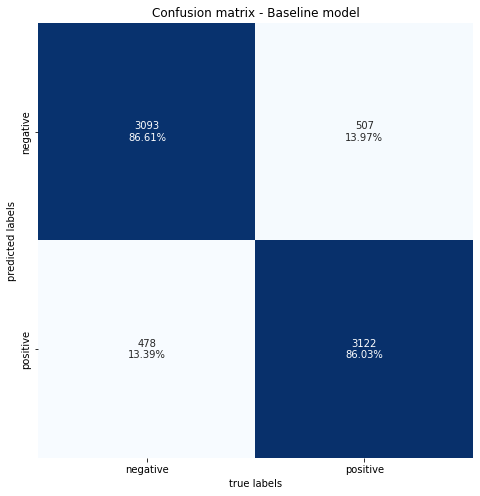

In [ ]:
prediction_matrix = confusion_matrix(y_val, predicted, labels=y_val.sort_values().unique())
categories = ['negative', 'positive'] #since the labels are sorted in the prediction matrix, the labels should be in the order of the sorted integers they represent.

intuitive_confusion_matrix(y_val, prediction_matrix, categories, "Baseline model")
print(classification_report(y_val, predicted, target_names=categories))

get_evaluation_metrics(y_val, predicted, predicted_prob, "Baseline model")

Learning Curve of the Baseline LogistiRegression classifier

(32000, 1500)


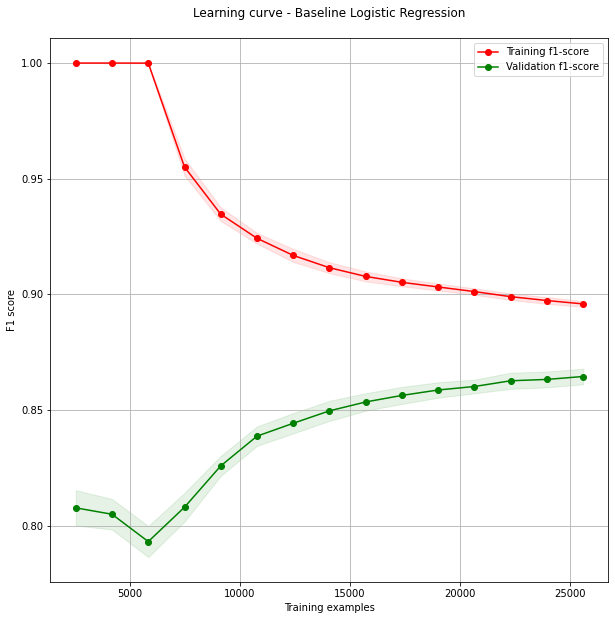

In [ ]:
print("trainable samples: ", all_trainable_vector_reviews.shape)
plot_learning_curve( n_splits = 15, test_size = 0.2, train_buckets = 15, trainable_vectors = all_trainable_vector_reviews, target_sample = y_train, model_estimator = baseline_logistic_regression )

Comments for the Learning curve

We can see that training and the cross-validated lines try to converge. However, they don't come close enough to conclude that the model has the optimum performance and generalization on the feeded training samples.

From this point we can follow two paths:

* Path 1: Feed the algorithm more training samples. Fit the algorithm with a training-test split on 90-10% instead of the 80-20% currently used. This will feed the baseline algorithm with more data. Then we should check if the generalization gap between the two lines (green, red) will be minized.

* Path 2: If the first path (1) does not yield improved results (meaning the converge between training and cross-validated lines), we could try to increase the number of iterations for the baseline model classifier or/and apply regularization penalties. By applying regularization we could cut off unnecessary weights that don't add information to the classification model and thus help the classifier to converge early with the cross-validation model.</br>
The tests of the second path (Path 2) can be applied concurrently by using the hyperparameter tuning approach. Hyperparameter tuning will try to test varius combinations of the hyper-parameters for the Logistic Regression classifier and select those that better fit the model.

* Path 3: If the two previous tests don't greatly improve/change the results, we could experiment with the following concept. Change the vector size of the trainable parameters by:
  * -1000. For example, from 1500 to 500 vector size.
  * +1000. For example, from 1500 to 2500 vector size.

#### 7.3 (path 1) Feed baseline logistic regression with more training samples

From [Section 5](https://colab.research.google.com/drive/1jK9JhTU9Qp4JTGcmPZiiqgyHJEWWyOF-#scrollTo=KQGX5awyn6RL&line=9&uniqifier=1) we have used a train-test split ration of 0.2 (20%).
* Training sample: 80% * 40,000
* Test sample: 20%* 40,000

For this experiment let's try a 90-10% split:
* Training sample: 90% * 40,000
* Test sample: 10%* 40,000

Plus I have decreased the split ration inside of each fold. From 20% (test samples) down to 10% (test samples). Leaving more trainable features on each fold (15 total folds have been used).

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(
#     x_features,
#     y_features,
#     shuffle=True,
#     test_size=0.1,
#     random_state=123
# )

all_trainable_vector_reviews = vectorizer.transform(x_train) # all trainable samples (90%* 40,000 = x_train), without having a validation samples
print(all_trainable_vector_reviews.shape)

(36000, 1500)


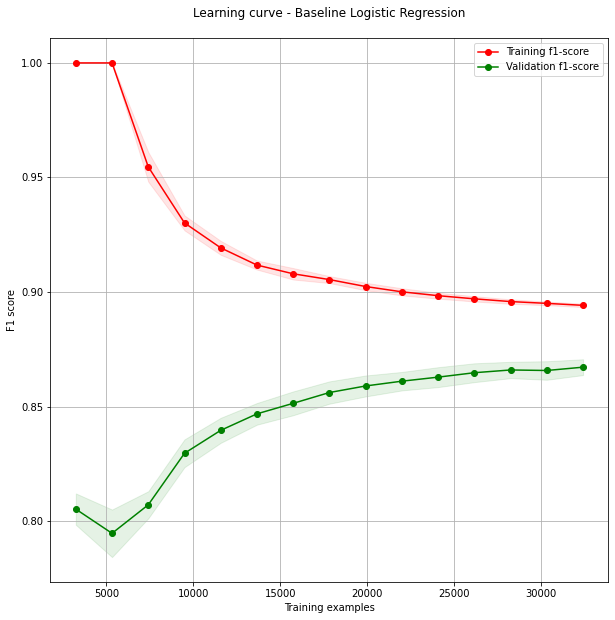

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.1,
    train_buckets = 15,
    trainable_vectors = all_trainable_vector_reviews,
    target_sample = y_train,
    model_estimator = baseline_logistic_regression,
    graph_name = "Baseline Logistic Regression"
)

Comments on the results of **Path 1**

With 36,000 total samples (90%) instead of 32,000 (80%) we have a slight improvement towards a converge between the two learning curves. The two lines are clearly closer to each other compared to the first pair of learning curves.

However, 4,000 extra training samples didn't fully converged. Thus, we have to try the hyperparameter tuning of **Path 2**.

#### 7.4 (path 2) Hyperparameter tuning of the Baseline Logistic Regression model

In [ ]:
parameters_grid = {
    'penalty':['l1', 'l2'],
    'solver':['lbfgs', 'liblinear', 'saga'],
    'C':list(np.linspace(0.5, 0.9, 3)),
    'max_iter':[int(x) for x in list(np.linspace(25, 150, 4))]
}

scoring = {
            'f1_scoring': 'f1',
            'precision_scoring': 'precision',
            'recall_scoring': 'recall'
          }
refit_score = scoring['f1_scoring']

# Create stratified and shuffled cross validation rounds
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.1, random_state=np.random.RandomState(0))

gridsearch_classifier = GridSearchCV(
    estimator=LogisticRegression(
        random_state=np.random.RandomState(0),
        multi_class  = "ovr",
        verbose=10,
        n_jobs = -1
    ),
    param_grid=parameters_grid,
    cv=cv,
    verbose=10,
    n_jobs=1,
    scoring=scoring,
    refit="f1_scoring",
    return_train_score=True
)

# Fit the gridsearch object
gridsearch_classifier.fit(trainable_vector_reviews, y_train_fit.values)
print(f'\nbest parameters: {gridsearch_classifier.best_params_}')

Fitting 15 folds for each of 72 candidates, totalling 1080 fits
[CV 1/15; 1/72] START C=0.5, max_iter=25, penalty=l1, solver=lbfgs..............
[CV 1/15; 1/72] END C=0.5, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 1/72] START C=0.5, max_iter=25, penalty=l1, solver=lbfgs..............
[CV 2/15; 1/72] END C=0.5, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 1/72] START C=0.5, max_iter=25, penalty=l1, solver=lbfgs..............
[CV 3/15; 1/72] END C=0.5, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 4/15; 1/72] START C=0.5, max_iter=25, penalty=l1, solver=lbfgs..............
[CV 4/15; 1/72] EN

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 2/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.907, test=0.865) total time=   0.2s
[CV 3/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.906, test=0.876) total time=   0.2s
[CV 4/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.852) recall_scoring: (train=0.909, test=0.874) total time=   0.2s
[CV 5/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.905, test=0.867) total time=   0.2s
[CV 6/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 7/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.895, test=0.887) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.904, test=0.909) total time=   0.2s
[CV 8/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.905, test=0.886) total time=   0.5s
[CV 9/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.905, test=0.885) total time=   0.3s
[CV 10/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.869) total time=   0.3s
[CV 11/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.878) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.905, test=0.885) total time=   0.3s
[CV 12/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.872) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.887) total time=   0.3s
[CV 13/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.891) total time=   0.3s
[CV 14/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.889, test=0.862) recall_scoring: (train=0.907, test=0.868) total time=   0.7s
[CV 15/15; 2/72] START C=0.5, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 2/72] END C=0.5, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.882) precision_scoring: (train=0.887, test=0.876) recall_scoring: (train=0.905, test=0.888) total time=   0.3s
[CV 1/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.869) recall_scoring: (train=0.899, test=0.887) total time=   4.1s
[CV 2/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.863) precision_scoring: (train=0.883, test=0.854) recall_scoring: (train=0.904, test=0.872) total time=   4.0s
[CV 3/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.869) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.900, test=0.877) total time=   3.5s
[CV 4/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.870) precision_scoring: (train=0.876, test=0.858) recall_scoring: (train=0.900, test=0.882) total time=   3.6s
[CV 5/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.892, test=0.864) precision_scoring: (train=0.881, test=0.859) recall_scoring: (train=0.903, test=0.869) total time=   3.6s
[CV 6/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.871) precision_scoring: (train=0.876, test=0.855) recall_scoring: (train=0.898, test=0.887) total time=   6.1s
[CV 7/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.861) recall_scoring: (train=0.898, test=0.905) total time=   4.0s
[CV 8/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.877, test=0.865) recall_scoring: (train=0.899, test=0.871) total time=   5.0s
[CV 9/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.875) precision_scoring: (train=0.877, test=0.858) recall_scoring: (train=0.899, test=0.893) total time=   3.6s
[CV 10/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.879) precision_scoring: (train=0.876, test=0.878) recall_scoring: (train=0.898, test=0.881) total time=   3.7s
[CV 11/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.872) precision_scoring: (train=0.877, test=0.860) recall_scoring: (train=0.899, test=0.885) total time=   3.6s
[CV 12/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.900, test=0.894) total time=   3.6s
[CV 13/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.877) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.899, test=0.899) total time=   3.8s
[CV 14/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.860) recall_scoring: (train=0.900, test=0.872) total time=   3.6s
[CV 15/15; 3/72] START C=0.5, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 3/72] END C=0.5, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.871) recall_scoring: (train=0.900, test=0.885) total time=   3.5s
[CV 1/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.871) precision_scoring: (train=0.890, test=0.866) recall_scoring: (train=0.901, test=0.876) total time=   2.1s
[CV 2/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 2/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.862) precision_scoring: (train=0.886, test=0.855) recall_scoring: (train=0.908, test=0.869) total time=   2.0s
[CV 3/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 3/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.867) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.900, test=0.865) total time=   1.8s
[CV 4/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 4/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.864) precision_scoring: (train=0.888, test=0.855) recall_scoring: (train=0.903, test=0.874) total time=   1.6s
[CV 5/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 5/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.862) precision_scoring: (train=0.884, test=0.852) recall_scoring: (train=0.907, test=0.872) total time=   1.6s
[CV 6/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


[CV 6/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.904, test=0.885) total time=   1.5s
[CV 7/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 7/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.885) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.904, test=0.909) total time=   1.5s
[CV 8/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 8/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.872) precision_scoring: (train=0.886, test=0.864) recall_scoring: (train=0.905, test=0.880) total time=   1.9s
[CV 9/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.875) precision_scoring: (train=0.885, test=0.862) recall_scoring: (train=0.901, test=0.888) total time=   2.0s
[CV 10/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 10/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.868) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.901, test=0.863) total time=   1.8s
[CV 11/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 11/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.889, test=0.872) recall_scoring: (train=0.898, test=0.877) total time=   1.6s
[CV 12/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


[CV 12/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.874) precision_scoring: (train=0.881, test=0.853) recall_scoring: (train=0.908, test=0.895) total time=   1.4s
[CV 13/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 13/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.887, test=0.867) recall_scoring: (train=0.899, test=0.881) total time=   1.6s
[CV 14/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 14/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.867) precision_scoring: (train=0.890, test=0.865) recall_scoring: (train=0.903, test=0.869) total time=   1.6s
[CV 15/15; 4/72] START C=0.5, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 15/15; 4/72] END C=0.5, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.882, test=0.867) recall_scoring: (train=0.905, test=0.889) total time=   1.5s
[CV 1/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.864) total time=   1.1s
[CV 3/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.866) total time=   1.0s
[CV 4/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.864) total time=   1.2s
[CV 5/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.862) total time=   1.2s
[CV 6/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.872) total time=   1.1s
[CV 7/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   1.1s
[CV 8/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.903, test=0.878) total time=   1.1s
[CV 9/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.904, test=0.882) total time=   1.1s
[CV 10/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.1s
[CV 11/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.893, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   1.1s
[CV 13/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.887) total time=   1.1s
[CV 14/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.2s
[CV 15/15; 5/72] START C=0.5, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 5/72] END C=0.5, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   1.1s
[CV 1/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.878, test=0.869) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 2/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.855) recall_scoring: (train=0.904, test=0.870) total time=   0.7s
[CV 3/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 3/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.861) recall_scoring: (train=0.900, test=0.876) total time=   0.7s
[CV 4/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 4/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.857) recall_scoring: (train=0.900, test=0.880) total time=   1.0s
[CV 5/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.892, test=0.866) precision_scoring: (train=0.883, test=0.861) recall_scoring: (train=0.902, test=0.872) total time=   1.0s
[CV 6/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.871) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 7/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.883) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.898, test=0.906) total time=   0.7s
[CV 8/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.877, test=0.867) recall_scoring: (train=0.900, test=0.872) total time=   0.7s
[CV 9/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.878, test=0.858) recall_scoring: (train=0.900, test=0.890) total time=   0.7s
[CV 10/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.877) precision_scoring: (train=0.876, test=0.877) recall_scoring: (train=0.899, test=0.878) total time=   0.7s
[CV 11/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.873) precision_scoring: (train=0.877, test=0.862) recall_scoring: (train=0.898, test=0.884) total time=   0.7s
[CV 12/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.878, test=0.856) recall_scoring: (train=0.900, test=0.894) total time=   0.7s
[CV 13/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.858) recall_scoring: (train=0.899, test=0.897) total time=   0.7s
[CV 14/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.879, test=0.860) recall_scoring: (train=0.901, test=0.872) total time=   0.7s
[CV 15/15; 6/72] START C=0.5, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 15/15; 6/72] END C=0.5, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.880) precision_scoring: (train=0.878, test=0.873) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 1/15; 7/72] START C=0.5, max_iter=66, penalty=l1, solver=lbfgs..............
[CV 1/15; 7/72] END C=0.5, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 7/72] START C=0.5, max_iter=66, penalty=l1, solver=lbfgs..............
[CV 2/15; 7/72] END C=0.5, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 7/72] START C=0.5, max_iter=66, penalty=l1, solver=lbfgs..............
[CV 3/15; 7/72] END C=0.5, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_sco

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 2/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.907, test=0.865) total time=   0.2s
[CV 3/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.906, test=0.876) total time=   0.2s
[CV 4/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.852) recall_scoring: (train=0.909, test=0.874) total time=   0.2s
[CV 5/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.905, test=0.867) total time=   0.2s
[CV 6/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 7/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.895, test=0.887) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.904, test=0.909) total time=   0.2s
[CV 8/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.905, test=0.886) total time=   0.4s
[CV 9/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear..........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 10/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear][CV 10/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.869) total time=   0.2s
[CV 11/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 11/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.878) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 12/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.872) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.887) total time=   0.2s
[CV 13/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.891) total time=   0.2s
[CV 14/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.889, test=0.862) recall_scoring: (train=0.907, test=0.868) total time=   0.2s
[CV 15/15; 8/72] START C=0.5, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 8/72] END C=0.5, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.882) precision_scoring: (train=0.887, test=0.876) recall_scoring: (train=0.905, test=0.888) total time=   0.3s
[CV 1/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.877) precision_scoring: (train=0.885, test=0.867) recall_scoring: (train=0.904, test=0.888) total time=   8.8s
[CV 2/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.888, test=0.855) recall_scoring: (train=0.908, test=0.867) total time=   9.4s
[CV 3/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.905, test=0.881) total time=  10.6s
[CV 4/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.870) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.906, test=0.883) total time=   8.9s
[CV 5/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.862) precision_scoring: (train=0.886, test=0.856) recall_scoring: (train=0.905, test=0.868) total time=   9.1s
[CV 6/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.904, test=0.892) total time=   8.9s
[CV 7/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.892, test=0.888) precision_scoring: (train=0.882, test=0.868) recall_scoring: (train=0.903, test=0.910) total time=   8.9s
[CV 8/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.874) precision_scoring: (train=0.884, test=0.868) recall_scoring: (train=0.904, test=0.879) total time=   9.0s
[CV 9/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.904, test=0.891) total time=   8.9s
[CV 10/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.882, test=0.876) recall_scoring: (train=0.905, test=0.879) total time=   9.2s
[CV 11/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.878) precision_scoring: (train=0.884, test=0.869) recall_scoring: (train=0.904, test=0.887) total time=   8.9s
[CV 12/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.873) precision_scoring: (train=0.883, test=0.854) recall_scoring: (train=0.905, test=0.894) total time=   9.0s
[CV 13/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.882, test=0.863) recall_scoring: (train=0.904, test=0.893) total time=   9.2s
[CV 14/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.866) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.907, test=0.869) total time=   8.8s
[CV 15/15; 9/72] START C=0.5, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 9/72] END C=0.5, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.883) precision_scoring: (train=0.884, test=0.876) recall_scoring: (train=0.904, test=0.890) total time=   8.8s
[CV 1/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 1/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.878) total time=   3.7s
[CV 2/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 2/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.866) total time=   2.6s
[CV 3/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 3/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.866) precision_scoring: (train=0.892, test=0.867) recall_scoring: (train=0.904, test=0.866) total time=   2.7s
[CV 4/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 4/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.860) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.866) total time=   2.5s
[CV 5/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.892, test=0.860) recall_scoring: (train=0.905, test=0.863) total time=   2.4s
[CV 6/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.904, test=0.872) total time=   2.2s
[CV 7/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   2.4s
[CV 8/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 8/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.890, test=0.867) recall_scoring: (train=0.904, test=0.879) total time=   2.5s
[CV 9/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   2.5s
[CV 10/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   2.5s
[CV 11/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 11/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.904, test=0.873) total time=   3.0s
[CV 12/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 12/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   2.7s
[CV 13/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.903, test=0.888) total time=   2.6s
[CV 14/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 14/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.890, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   2.5s
[CV 15/15; 10/72] START C=0.5, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 15/15; 10/72] END C=0.5, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.880) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.884) total time=   2.2s
[CV 1/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.864) total time=   1.0s
[CV 3/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.866) total time=   0.9s
[CV 4/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.864) total time=   1.0s
[CV 5/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.862) total time=   0.9s
[CV 6/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.872) total time=   0.9s
[CV 7/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   1.0s
[CV 8/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.903, test=0.878) total time=   1.0s
[CV 9/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.904, test=0.882) total time=   0.9s
[CV 10/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.0s
[CV 11/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.893, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   1.1s
[CV 13/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.887) total time=   0.9s
[CV 14/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.0s
[CV 15/15; 11/72] START C=0.5, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 11/72] END C=0.5, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   1.1s
[CV 1/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.877) precision_scoring: (train=0.885, test=0.867) recall_scoring: (train=0.905, test=0.887) total time=   1.7s
[CV 2/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.863) precision_scoring: (train=0.888, test=0.858) recall_scoring: (train=0.906, test=0.869) total time=   1.6s
[CV 3/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.872) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.880) total time=   1.7s
[CV 4/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.907, test=0.880) total time=   1.6s
[CV 5/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.862) precision_scoring: (train=0.888, test=0.856) recall_scoring: (train=0.904, test=0.869) total time=   1.7s
[CV 6/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.886, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   1.7s
[CV 7/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.887) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.908) total time=   1.6s
[CV 8/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.904, test=0.881) total time=   1.6s
[CV 9/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.885, test=0.863) recall_scoring: (train=0.904, test=0.889) total time=   1.7s
[CV 10/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.876) precision_scoring: (train=0.883, test=0.876) recall_scoring: (train=0.904, test=0.876) total time=   1.7s
[CV 11/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.878) precision_scoring: (train=0.885, test=0.870) recall_scoring: (train=0.904, test=0.886) total time=   1.7s
[CV 12/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.906, test=0.892) total time=   1.6s
[CV 13/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.875) precision_scoring: (train=0.883, test=0.860) recall_scoring: (train=0.904, test=0.890) total time=   1.8s
[CV 14/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.885, test=0.864) recall_scoring: (train=0.906, test=0.871) total time=   2.0s
[CV 15/15; 12/72] START C=0.5, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 15/15; 12/72] END C=0.5, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.880) precision_scoring: (train=0.885, test=0.872) recall_scoring: (train=0.904, test=0.887) total time=   2.1s
[CV 1/15; 13/72] START C=0.5, max_iter=108, penalty=l1, solver=lbfgs............
[CV 1/15; 13/72] END C=0.5, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 13/72] START C=0.5, max_iter=108, penalty=l1, solver=lbfgs............
[CV 2/15; 13/72] END C=0.5, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 13/72] START C=0.5, max_iter=108, penalty=l1, solver=lbfgs............
[CV 3/15; 13/72] END C=0.5, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) rec

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 2/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.907, test=0.865) total time=   0.2s
[CV 3/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.906, test=0.876) total time=   0.2s
[CV 4/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.852) recall_scoring: (train=0.909, test=0.874) total time=   0.2s
[CV 5/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.905, test=0.867) total time=   0.2s
[CV 6/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 7/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.895, test=0.887) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.904, test=0.909) total time=   0.2s
[CV 8/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.905, test=0.886) total time=   0.4s
[CV 9/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 10/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear][CV 10/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.869) total time=   0.2s
[CV 11/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 11/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.878) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 12/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.872) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.887) total time=   0.2s
[CV 13/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.891) total time=   0.2s
[CV 14/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.889, test=0.862) recall_scoring: (train=0.907, test=0.868) total time=   0.2s
[CV 15/15; 14/72] START C=0.5, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 14/72] END C=0.5, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.882) precision_scoring: (train=0.887, test=0.876) recall_scoring: (train=0.905, test=0.888) total time=   0.3s
[CV 1/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.876) precision_scoring: (train=0.886, test=0.869) recall_scoring: (train=0.905, test=0.884) total time=  14.4s
[CV 2/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.907, test=0.867) total time=  14.3s
[CV 3/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.886, test=0.863) recall_scoring: (train=0.906, test=0.876) total time=  14.3s
[CV 4/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.868) precision_scoring: (train=0.887, test=0.855) recall_scoring: (train=0.908, test=0.881) total time=  14.3s
[CV 5/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.860) precision_scoring: (train=0.888, test=0.856) recall_scoring: (train=0.905, test=0.864) total time=  14.2s
[CV 6/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.876) precision_scoring: (train=0.887, test=0.861) recall_scoring: (train=0.906, test=0.892) total time=  14.5s
[CV 7/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.887) precision_scoring: (train=0.884, test=0.867) recall_scoring: (train=0.904, test=0.908) total time=  14.5s
[CV 8/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.867) recall_scoring: (train=0.906, test=0.882) total time=  14.5s
[CV 9/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.905, test=0.888) total time=  15.5s
[CV 10/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.885, test=0.874) recall_scoring: (train=0.906, test=0.874) total time=  14.4s
[CV 11/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.879) precision_scoring: (train=0.886, test=0.870) recall_scoring: (train=0.905, test=0.887) total time=  14.3s
[CV 12/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.906, test=0.892) total time=  14.5s
[CV 13/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.905, test=0.886) total time=  14.5s
[CV 14/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.887, test=0.863) recall_scoring: (train=0.907, test=0.872) total time=  14.4s
[CV 15/15; 15/72] START C=0.5, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 15/72] END C=0.5, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.879) precision_scoring: (train=0.885, test=0.874) recall_scoring: (train=0.905, test=0.885) total time=  14.5s
[CV 1/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 1/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   4.0s
[CV 2/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 2/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.906, test=0.863) total time=   3.1s
[CV 3/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 3/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.905, test=0.866) total time=   3.3s
[CV 4/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 4/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.859) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.865) total time=   3.4s
[CV 5/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 5/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   3.3s
[CV 6/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 6/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.891, test=0.856) recall_scoring: (train=0.904, test=0.870) total time=   3.0s
[CV 7/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 7/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.886) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   3.3s
[CV 8/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 8/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.903, test=0.878) total time=   3.7s
[CV 9/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV 9/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.904, test=0.881) total time=   4.9s
[CV 10/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 10/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   3.4s
[CV 11/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 11/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.871) total time=   3.5s
[CV 12/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 12/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.893, test=0.856) recall_scoring: (train=0.904, test=0.883) total time=   3.4s
[CV 13/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 13/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.903, test=0.886) total time=   3.6s
[CV 14/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 14/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   3.4s
[CV 15/15; 16/72] START C=0.5, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 15/15; 16/72] END C=0.5, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   3.3s
[CV 1/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.864) total time=   0.9s
[CV 3/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.866) total time=   1.0s
[CV 4/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.864) total time=   1.0s
[CV 5/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.862) total time=   0.9s
[CV 6/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.872) total time=   1.0s
[CV 7/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   1.0s
[CV 8/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.903, test=0.878) total time=   1.1s
[CV 9/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.904, test=0.882) total time=   1.1s
[CV 10/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   0.9s
[CV 11/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.893, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   1.1s
[CV 13/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.887) total time=   1.0s
[CV 14/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.1s
[CV 15/15; 17/72] START C=0.5, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 17/72] END C=0.5, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   1.0s
[CV 1/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.868) recall_scoring: (train=0.905, test=0.883) total time=   2.7s
[CV 2/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.906, test=0.866) total time=   2.8s
[CV 3/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.876) total time=   2.8s
[CV 4/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.889, test=0.854) recall_scoring: (train=0.907, test=0.874) total time=   2.8s
[CV 5/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.862) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.904, test=0.866) total time=   2.8s
[CV 6/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.888, test=0.858) recall_scoring: (train=0.905, test=0.888) total time=   2.7s
[CV 7/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.886) precision_scoring: (train=0.886, test=0.866) recall_scoring: (train=0.903, test=0.908) total time=   2.7s
[CV 8/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.868) recall_scoring: (train=0.905, test=0.882) total time=   2.8s
[CV 9/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.904, test=0.886) total time=   2.8s
[CV 10/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.875) recall_scoring: (train=0.905, test=0.868) total time=   2.7s
[CV 11/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.878) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.906, test=0.884) total time=   2.7s
[CV 12/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.887, test=0.857) recall_scoring: (train=0.905, test=0.890) total time=   2.8s
[CV 13/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.876) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.888) total time=   2.8s
[CV 14/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.907, test=0.871) total time=   2.7s
[CV 15/15; 18/72] START C=0.5, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 15/15; 18/72] END C=0.5, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.880) precision_scoring: (train=0.886, test=0.875) recall_scoring: (train=0.904, test=0.886) total time=   2.7s
[CV 1/15; 19/72] START C=0.5, max_iter=150, penalty=l1, solver=lbfgs............
[CV 1/15; 19/72] END C=0.5, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 19/72] START C=0.5, max_iter=150, penalty=l1, solver=lbfgs............
[CV 2/15; 19/72] END C=0.5, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 19/72] START C=0.5, max_iter=150, penalty=l1, solver=lbfgs............
[CV 3/15; 19/72] END C=0.5, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) re

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 2/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.907, test=0.865) total time=   0.2s
[CV 3/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.906, test=0.876) total time=   0.2s
[CV 4/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.852) recall_scoring: (train=0.909, test=0.874) total time=   0.2s
[CV 5/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.905, test=0.867) total time=   0.2s
[CV 6/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.879) total time=   0.2s
[CV 7/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.895, test=0.887) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.904, test=0.909) total time=   0.2s
[CV 8/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.905, test=0.886) total time=   0.4s
[CV 9/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 10/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear][CV 10/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.869) total time=   0.2s
[CV 11/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 11/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.878) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 12/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.872) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.887) total time=   0.2s
[CV 13/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.891) total time=   0.2s
[CV 14/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.889, test=0.862) recall_scoring: (train=0.907, test=0.868) total time=   0.2s
[CV 15/15; 20/72] START C=0.5, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 20/72] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.882) precision_scoring: (train=0.887, test=0.876) recall_scoring: (train=0.905, test=0.888) total time=   0.3s
[CV 1/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.869) recall_scoring: (train=0.906, test=0.881) total time=  19.9s
[CV 2/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.890, test=0.859) recall_scoring: (train=0.908, test=0.869) total time=  19.7s
[CV 3/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.887, test=0.864) recall_scoring: (train=0.905, test=0.877) total time=  19.9s
[CV 4/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.887, test=0.856) recall_scoring: (train=0.909, test=0.878) total time=  20.0s
[CV 5/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.860) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.905, test=0.863) total time=  19.9s
[CV 6/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.906, test=0.887) total time=  21.1s
[CV 7/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.887) precision_scoring: (train=0.885, test=0.866) recall_scoring: (train=0.904, test=0.909) total time=  19.9s
[CV 8/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.867) recall_scoring: (train=0.905, test=0.883) total time=  19.9s
[CV 9/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.863) recall_scoring: (train=0.905, test=0.886) total time=  19.8s
[CV 10/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.872) precision_scoring: (train=0.886, test=0.873) recall_scoring: (train=0.905, test=0.870) total time=  19.6s
[CV 11/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.877) precision_scoring: (train=0.887, test=0.869) recall_scoring: (train=0.906, test=0.885) total time=  19.9s
[CV 12/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.876) precision_scoring: (train=0.887, test=0.860) recall_scoring: (train=0.907, test=0.892) total time=  20.0s
[CV 13/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.885, test=0.863) recall_scoring: (train=0.904, test=0.886) total time=  20.2s
[CV 14/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.866) precision_scoring: (train=0.887, test=0.862) recall_scoring: (train=0.907, test=0.869) total time=  19.8s
[CV 15/15; 21/72] START C=0.5, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 21/72] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.880) precision_scoring: (train=0.886, test=0.874) recall_scoring: (train=0.904, test=0.887) total time=  19.9s
[CV 1/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV 1/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.905, test=0.881) total time=   4.9s
[CV 2/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished


[CV 2/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.864) total time=   5.1s
[CV 3/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 3/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.865) total time=   4.2s
[CV 4/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV 4/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.864) total time=   4.3s
[CV 5/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV 5/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.861) recall_scoring: (train=0.904, test=0.861) total time=   4.7s
[CV 6/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 6/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.872) total time=   4.4s
[CV 7/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV 7/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   4.0s
[CV 8/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV 8/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.904, test=0.878) total time=   4.5s
[CV 9/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV 9/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.904, test=0.881) total time=   5.7s
[CV 10/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 10/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   4.5s
[CV 11/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV 11/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   4.9s
[CV 12/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 12/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   4.1s
[CV 13/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV 13/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.903, test=0.887) total time=   4.5s
[CV 14/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 14/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   4.2s
[CV 15/15; 22/72] START C=0.5, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV 15/15; 22/72] END C=0.5, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   5.0s
[CV 1/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.1s
[CV 2/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.864) total time=   1.1s
[CV 3/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.866) total time=   1.1s
[CV 4/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.864) total time=   1.1s
[CV 5/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.862) total time=   1.0s
[CV 6/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.872) total time=   0.9s
[CV 7/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.903, test=0.909) total time=   1.1s
[CV 8/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.903, test=0.878) total time=   1.0s
[CV 9/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.904, test=0.882) total time=   1.0s
[CV 10/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.0s
[CV 11/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.893, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   1.1s
[CV 13/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.887) total time=   1.1s
[CV 14/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.0s
[CV 15/15; 23/72] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 23/72] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   1.1s
[CV 1/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.889, test=0.869) recall_scoring: (train=0.906, test=0.885) total time=   3.7s
[CV 2/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.906, test=0.867) total time=   3.8s
[CV 3/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.888, test=0.865) recall_scoring: (train=0.905, test=0.874) total time=   3.7s
[CV 4/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.854) recall_scoring: (train=0.907, test=0.872) total time=   3.7s
[CV 5/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.863) total time=   3.8s
[CV 6/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.881) total time=   3.7s
[CV 7/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.885) precision_scoring: (train=0.887, test=0.864) recall_scoring: (train=0.904, test=0.908) total time=   3.7s
[CV 8/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.889, test=0.866) recall_scoring: (train=0.906, test=0.881) total time=   3.7s
[CV 9/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.905, test=0.884) total time=   3.8s
[CV 10/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.868) precision_scoring: (train=0.886, test=0.872) recall_scoring: (train=0.905, test=0.863) total time=   3.7s
[CV 11/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.888, test=0.873) recall_scoring: (train=0.906, test=0.880) total time=   3.7s
[CV 12/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.905, test=0.890) total time=   4.9s
[CV 13/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.886, test=0.861) recall_scoring: (train=0.904, test=0.888) total time=   3.8s
[CV 14/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.888, test=0.865) recall_scoring: (train=0.907, test=0.870) total time=   3.8s
[CV 15/15; 24/72] START C=0.5, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 15/15; 24/72] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.882) precision_scoring: (train=0.887, test=0.875) recall_scoring: (train=0.903, test=0.888) total time=   3.8s
[CV 1/15; 25/72] START C=0.7, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 1/15; 25/72] END C=0.7, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 25/72] START C=0.7, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 2/15; 25/72] END C=0.7, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 25/72] START C=0.7, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 3/15; 25/72] END C=0.7, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recal

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.866) total time=   0.3s
[CV 3/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.905, test=0.873) total time=   0.2s
[CV 4/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.862) precision_scoring: (train=0.891, test=0.852) recall_scoring: (train=0.908, test=0.871) total time=   0.2s
[CV 5/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.865) total time=   0.3s
[CV 6/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.876) total time=   0.4s
[CV 7/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.888) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.910) total time=   0.3s
[CV 8/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.905, test=0.881) total time=   0.3s
[CV 9/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   0.2s
[CV 10/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.904, test=0.880) total time=   0.2s
[CV 12/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 13/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   0.2s
[CV 14/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 26/72] START C=0.7, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 26/72] END C=0.7, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.883) precision_scoring: (train=0.888, test=0.878) recall_scoring: (train=0.906, test=0.888) total time=   0.4s
[CV 1/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.879) precision_scoring: (train=0.877, test=0.870) recall_scoring: (train=0.899, test=0.888) total time=   3.6s
[CV 2/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.883, test=0.854) recall_scoring: (train=0.903, test=0.871) total time=   3.6s
[CV 3/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.878, test=0.860) recall_scoring: (train=0.900, test=0.876) total time=   3.6s
[CV 4/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.869) precision_scoring: (train=0.877, test=0.857) recall_scoring: (train=0.900, test=0.882) total time=   3.7s
[CV 5/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.881, test=0.859) recall_scoring: (train=0.903, test=0.871) total time=   3.6s
[CV 6/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.870) precision_scoring: (train=0.876, test=0.855) recall_scoring: (train=0.898, test=0.885) total time=   3.8s
[CV 7/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.882) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.899, test=0.905) total time=   3.7s
[CV 8/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.877, test=0.865) recall_scoring: (train=0.900, test=0.871) total time=   3.7s
[CV 9/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.875) precision_scoring: (train=0.877, test=0.857) recall_scoring: (train=0.900, test=0.894) total time=   3.7s
[CV 10/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.879) precision_scoring: (train=0.876, test=0.878) recall_scoring: (train=0.899, test=0.881) total time=   3.6s
[CV 11/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.899, test=0.884) total time=   3.7s
[CV 12/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.900, test=0.894) total time=   3.8s
[CV 13/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.877) precision_scoring: (train=0.876, test=0.857) recall_scoring: (train=0.899, test=0.899) total time=   3.7s
[CV 14/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.865) precision_scoring: (train=0.878, test=0.859) recall_scoring: (train=0.901, test=0.871) total time=   3.8s
[CV 15/15; 27/72] START C=0.7, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 27/72] END C=0.7, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.871) recall_scoring: (train=0.899, test=0.885) total time=   3.7s
[CV 1/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.897, test=0.874) total time=   2.1s
[CV 2/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 2/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.861) precision_scoring: (train=0.887, test=0.854) recall_scoring: (train=0.907, test=0.867) total time=   2.0s
[CV 3/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 3/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.869) precision_scoring: (train=0.887, test=0.869) recall_scoring: (train=0.903, test=0.869) total time=   2.0s
[CV 4/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 4/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.862) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.907, test=0.874) total time=   1.5s
[CV 5/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 5/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.862) precision_scoring: (train=0.884, test=0.852) recall_scoring: (train=0.906, test=0.872) total time=   1.6s
[CV 6/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 6/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.892, test=0.866) recall_scoring: (train=0.895, test=0.876) total time=   1.6s
[CV 7/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 7/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.899, test=0.903) total time=   1.7s
[CV 8/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 8/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.872) precision_scoring: (train=0.886, test=0.865) recall_scoring: (train=0.905, test=0.880) total time=   1.9s
[CV 9/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.862) recall_scoring: (train=0.901, test=0.887) total time=   2.1s
[CV 10/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 10/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.867) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.902, test=0.863) total time=   2.0s
[CV 11/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 11/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.889, test=0.873) recall_scoring: (train=0.898, test=0.877) total time=   1.7s
[CV 12/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 12/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.906, test=0.893) total time=   1.6s
[CV 13/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


[CV 13/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.873) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.906, test=0.887) total time=   1.4s
[CV 14/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 14/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.905, test=0.870) total time=   1.5s
[CV 15/15; 28/72] START C=0.7, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 15/15; 28/72] END C=0.7, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.883, test=0.869) recall_scoring: (train=0.903, test=0.888) total time=   1.7s
[CV 1/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   0.9s
[CV 3/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   0.9s
[CV 4/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.900, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.862) total time=   1.1s
[CV 5/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   0.9s
[CV 6/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.905, test=0.872) total time=   1.1s
[CV 7/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.903, test=0.908) total time=   1.1s
[CV 8/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.0s
[CV 10/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   1.0s
[CV 11/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.883) total time=   0.9s
[CV 13/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.885) total time=   1.1s
[CV 14/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   1.0s
[CV 15/15; 29/72] START C=0.7, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 29/72] END C=0.7, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.882) total time=   1.1s
[CV 1/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.878, test=0.869) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 2/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.863) precision_scoring: (train=0.884, test=0.855) recall_scoring: (train=0.904, test=0.870) total time=   0.7s
[CV 3/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.861) recall_scoring: (train=0.900, test=0.876) total time=   0.8s
[CV 4/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.857) recall_scoring: (train=0.901, test=0.880) total time=   0.8s
[CV 5/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.892, test=0.866) precision_scoring: (train=0.882, test=0.861) recall_scoring: (train=0.902, test=0.872) total time=   0.8s
[CV 6/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.871) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.899, test=0.887) total time=   0.8s
[CV 7/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.883) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.898, test=0.906) total time=   0.7s
[CV 8/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.900, test=0.872) total time=   0.8s
[CV 9/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.878, test=0.858) recall_scoring: (train=0.900, test=0.889) total time=   0.7s
[CV 10/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.877) precision_scoring: (train=0.876, test=0.877) recall_scoring: (train=0.899, test=0.878) total time=   0.7s
[CV 11/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.862) recall_scoring: (train=0.898, test=0.884) total time=   0.7s
[CV 12/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.878, test=0.856) recall_scoring: (train=0.900, test=0.894) total time=   0.8s
[CV 13/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.858) recall_scoring: (train=0.899, test=0.897) total time=   0.8s
[CV 14/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.879, test=0.860) recall_scoring: (train=0.901, test=0.872) total time=   0.8s
[CV 15/15; 30/72] START C=0.7, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 15/15; 30/72] END C=0.7, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.880) precision_scoring: (train=0.878, test=0.873) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 1/15; 31/72] START C=0.7, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 1/15; 31/72] END C=0.7, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 31/72] START C=0.7, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 2/15; 31/72] END C=0.7, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 31/72] START C=0.7, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 3/15; 31/72] END C=0.7, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.866) total time=   0.3s
[CV 3/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.905, test=0.873) total time=   0.2s
[CV 4/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.862) precision_scoring: (train=0.891, test=0.852) recall_scoring: (train=0.908, test=0.871) total time=   0.2s
[CV 5/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.865) total time=   0.3s
[CV 6/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.876) total time=   0.4s
[CV 7/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.888) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.910) total time=   0.3s
[CV 8/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.905, test=0.881) total time=   0.3s
[CV 9/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   0.2s
[CV 10/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.904, test=0.880) total time=   0.2s
[CV 12/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 13/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   0.2s
[CV 14/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 32/72] START C=0.7, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 32/72] END C=0.7, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.883) precision_scoring: (train=0.888, test=0.878) recall_scoring: (train=0.906, test=0.888) total time=   0.4s
[CV 1/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.879) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.905, test=0.889) total time=   9.2s
[CV 2/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.907, test=0.867) total time=   9.1s
[CV 3/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.905, test=0.880) total time=   9.2s
[CV 4/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.870) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.906, test=0.882) total time=   9.1s
[CV 5/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.861) precision_scoring: (train=0.887, test=0.855) recall_scoring: (train=0.905, test=0.866) total time=   9.1s
[CV 6/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.904, test=0.892) total time=   9.3s
[CV 7/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.889) precision_scoring: (train=0.883, test=0.868) recall_scoring: (train=0.903, test=0.910) total time=   9.5s
[CV 8/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.885, test=0.869) recall_scoring: (train=0.904, test=0.881) total time=   9.2s
[CV 9/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.904, test=0.890) total time=   9.3s
[CV 10/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.876) precision_scoring: (train=0.882, test=0.876) recall_scoring: (train=0.904, test=0.877) total time=   9.2s
[CV 11/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.877) precision_scoring: (train=0.885, test=0.869) recall_scoring: (train=0.904, test=0.885) total time=   9.1s
[CV 12/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.906, test=0.893) total time=   9.2s
[CV 13/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.905, test=0.892) total time=   9.3s
[CV 14/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.867) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.906, test=0.871) total time=   9.2s
[CV 15/15; 33/72] START C=0.7, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 33/72] END C=0.7, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.882) precision_scoring: (train=0.884, test=0.875) recall_scoring: (train=0.904, test=0.890) total time=   9.5s
[CV 1/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 1/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.890, test=0.866) recall_scoring: (train=0.905, test=0.881) total time=   3.6s
[CV 2/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 2/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.865) total time=   2.5s
[CV 3/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.866) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.867) total time=   2.2s
[CV 4/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 4/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.859) precision_scoring: (train=0.891, test=0.854) recall_scoring: (train=0.907, test=0.864) total time=   2.5s
[CV 5/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 5/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.860) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.860) total time=   2.7s
[CV 6/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 6/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.856) recall_scoring: (train=0.904, test=0.872) total time=   2.6s
[CV 7/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.890, test=0.866) recall_scoring: (train=0.902, test=0.909) total time=   2.5s
[CV 8/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 8/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.877) total time=   2.7s
[CV 9/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 9/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.866) precision_scoring: (train=0.890, test=0.854) recall_scoring: (train=0.903, test=0.879) total time=   2.8s
[CV 10/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 10/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   2.8s
[CV 11/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 11/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.890, test=0.870) recall_scoring: (train=0.904, test=0.874) total time=   3.6s
[CV 12/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 12/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.904, test=0.885) total time=   2.5s
[CV 13/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.903, test=0.885) total time=   2.6s
[CV 14/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 14/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   3.0s
[CV 15/15; 34/72] START C=0.7, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 15/15; 34/72] END C=0.7, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.884) total time=   4.1s
[CV 1/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   1.0s
[CV 3/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   0.9s
[CV 4/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.900, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.862) total time=   1.0s
[CV 5/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   1.1s
[CV 6/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.905, test=0.872) total time=   0.9s
[CV 7/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.903, test=0.908) total time=   1.1s
[CV 8/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.0s
[CV 10/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   0.9s
[CV 11/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.0s
[CV 12/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.883) total time=   1.1s
[CV 13/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.885) total time=   0.9s
[CV 14/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   0.9s
[CV 15/15; 35/72] START C=0.7, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 35/72] END C=0.7, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.882) total time=   1.0s
[CV 1/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.877) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.905, test=0.887) total time=   1.7s
[CV 2/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.863) precision_scoring: (train=0.888, test=0.858) recall_scoring: (train=0.906, test=0.869) total time=   1.7s
[CV 3/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.872) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.880) total time=   1.7s
[CV 4/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.907, test=0.879) total time=   1.6s
[CV 5/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.862) precision_scoring: (train=0.888, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   1.8s
[CV 6/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.886, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   1.7s
[CV 7/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.887) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.908) total time=   1.8s
[CV 8/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.904, test=0.881) total time=   1.7s
[CV 9/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.885, test=0.863) recall_scoring: (train=0.904, test=0.889) total time=   1.8s
[CV 10/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.883, test=0.876) recall_scoring: (train=0.904, test=0.877) total time=   1.7s
[CV 11/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.877) precision_scoring: (train=0.885, test=0.870) recall_scoring: (train=0.904, test=0.885) total time=   1.7s
[CV 12/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.906, test=0.892) total time=   1.7s
[CV 13/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.883, test=0.860) recall_scoring: (train=0.904, test=0.890) total time=   2.0s
[CV 14/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.867) precision_scoring: (train=0.886, test=0.864) recall_scoring: (train=0.906, test=0.871) total time=   2.0s
[CV 15/15; 36/72] START C=0.7, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 15/15; 36/72] END C=0.7, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.880) precision_scoring: (train=0.885, test=0.872) recall_scoring: (train=0.904, test=0.887) total time=   2.0s
[CV 1/15; 37/72] START C=0.7, max_iter=108, penalty=l1, solver=lbfgs............
[CV 1/15; 37/72] END C=0.7, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 37/72] START C=0.7, max_iter=108, penalty=l1, solver=lbfgs............
[CV 2/15; 37/72] END C=0.7, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 37/72] START C=0.7, max_iter=108, penalty=l1, solver=lbfgs............
[CV 3/15; 37/72] END C=0.7, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) rec

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.866) total time=   0.3s
[CV 3/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.905, test=0.873) total time=   0.2s
[CV 4/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.862) precision_scoring: (train=0.891, test=0.852) recall_scoring: (train=0.908, test=0.871) total time=   0.2s
[CV 5/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.865) total time=   0.3s
[CV 6/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.876) total time=   0.4s
[CV 7/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.888) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.910) total time=   0.3s
[CV 8/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.905, test=0.881) total time=   0.3s
[CV 9/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   0.2s
[CV 10/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.904, test=0.880) total time=   0.2s
[CV 12/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 13/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   0.2s
[CV 14/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 38/72] START C=0.7, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 38/72] END C=0.7, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.883) precision_scoring: (train=0.888, test=0.878) recall_scoring: (train=0.906, test=0.888) total time=   0.4s
[CV 1/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.877) precision_scoring: (train=0.887, test=0.868) recall_scoring: (train=0.905, test=0.885) total time=  14.7s
[CV 2/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.907, test=0.869) total time=  14.7s
[CV 3/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.886, test=0.863) recall_scoring: (train=0.905, test=0.875) total time=  14.8s
[CV 4/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.887, test=0.855) recall_scoring: (train=0.908, test=0.879) total time=  14.8s
[CV 5/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.861) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.904, test=0.865) total time=  14.8s
[CV 6/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.906, test=0.890) total time=  14.8s
[CV 7/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.888) precision_scoring: (train=0.884, test=0.869) recall_scoring: (train=0.904, test=0.909) total time=  14.6s
[CV 8/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.886, test=0.868) recall_scoring: (train=0.906, test=0.883) total time=  14.8s
[CV 9/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.886, test=0.862) recall_scoring: (train=0.904, test=0.888) total time=  14.7s
[CV 10/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.885, test=0.874) recall_scoring: (train=0.905, test=0.872) total time=  14.6s
[CV 11/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.877) precision_scoring: (train=0.887, test=0.869) recall_scoring: (train=0.906, test=0.885) total time=  14.7s
[CV 12/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.906, test=0.893) total time=  14.9s
[CV 13/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.873) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.904, test=0.886) total time=  14.9s
[CV 14/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.887, test=0.864) recall_scoring: (train=0.907, test=0.871) total time=  14.8s
[CV 15/15; 39/72] START C=0.7, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 39/72] END C=0.7, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.880) precision_scoring: (train=0.886, test=0.874) recall_scoring: (train=0.904, test=0.885) total time=  14.8s
[CV 1/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV 1/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.891, test=0.869) recall_scoring: (train=0.905, test=0.881) total time=   4.7s
[CV 2/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 2/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.860) recall_scoring: (train=0.905, test=0.863) total time=   3.6s
[CV 3/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 3/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.904, test=0.865) total time=   3.5s
[CV 4/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 4/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.859) precision_scoring: (train=0.892, test=0.855) recall_scoring: (train=0.907, test=0.864) total time=   3.7s
[CV 5/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV 5/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.860) precision_scoring: (train=0.893, test=0.860) recall_scoring: (train=0.904, test=0.860) total time=   4.3s
[CV 6/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 6/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.871) total time=   3.9s
[CV 7/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 7/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.886) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   3.8s
[CV 8/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV 8/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.866) recall_scoring: (train=0.904, test=0.878) total time=   4.5s
[CV 9/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 9/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.882) total time=   4.2s
[CV 10/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 10/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   3.3s
[CV 11/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 11/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.903, test=0.871) total time=   3.2s
[CV 12/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 12/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.904, test=0.883) total time=   3.5s
[CV 13/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 13/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   3.9s
[CV 14/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 14/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   3.5s
[CV 15/15; 40/72] START C=0.7, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 15/15; 40/72] END C=0.7, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   3.6s
[CV 1/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.2s
[CV 2/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   1.0s
[CV 3/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   1.0s
[CV 4/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.900, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.862) total time=   1.0s
[CV 5/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   1.1s
[CV 6/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.905, test=0.872) total time=   0.9s
[CV 7/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.903, test=0.908) total time=   1.0s
[CV 8/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.0s
[CV 10/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   0.9s
[CV 11/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.883) total time=   1.1s
[CV 13/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.885) total time=   0.9s
[CV 14/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   1.1s
[CV 15/15; 41/72] START C=0.7, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 41/72] END C=0.7, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.882) total time=   1.0s
[CV 1/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.867) recall_scoring: (train=0.906, test=0.883) total time=   2.8s
[CV 2/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.906, test=0.867) total time=   2.7s
[CV 3/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.905, test=0.874) total time=   2.7s
[CV 4/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.889, test=0.854) recall_scoring: (train=0.907, test=0.874) total time=   2.8s
[CV 5/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.863) precision_scoring: (train=0.890, test=0.860) recall_scoring: (train=0.904, test=0.866) total time=   2.8s
[CV 6/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.905, test=0.886) total time=   2.9s
[CV 7/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.886) precision_scoring: (train=0.886, test=0.866) recall_scoring: (train=0.903, test=0.908) total time=   2.7s
[CV 8/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.868) recall_scoring: (train=0.905, test=0.883) total time=   2.8s
[CV 9/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.904, test=0.885) total time=   2.7s
[CV 10/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.871) precision_scoring: (train=0.887, test=0.875) recall_scoring: (train=0.905, test=0.868) total time=   2.7s
[CV 11/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.906, test=0.883) total time=   2.7s
[CV 12/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.887, test=0.857) recall_scoring: (train=0.905, test=0.889) total time=   2.8s
[CV 13/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.876) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.888) total time=   2.8s
[CV 14/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.907, test=0.871) total time=   2.9s
[CV 15/15; 42/72] START C=0.7, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 15/15; 42/72] END C=0.7, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.880) precision_scoring: (train=0.886, test=0.875) recall_scoring: (train=0.904, test=0.886) total time=   2.8s
[CV 1/15; 43/72] START C=0.7, max_iter=150, penalty=l1, solver=lbfgs............
[CV 1/15; 43/72] END C=0.7, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 43/72] START C=0.7, max_iter=150, penalty=l1, solver=lbfgs............
[CV 2/15; 43/72] END C=0.7, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 43/72] START C=0.7, max_iter=150, penalty=l1, solver=lbfgs............
[CV 3/15; 43/72] END C=0.7, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) re

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.866) total time=   0.3s
[CV 3/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.905, test=0.873) total time=   0.2s
[CV 4/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.862) precision_scoring: (train=0.891, test=0.852) recall_scoring: (train=0.908, test=0.871) total time=   0.2s
[CV 5/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.865) total time=   0.3s
[CV 6/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.876) total time=   0.4s
[CV 7/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.888) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.910) total time=   0.3s
[CV 8/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.905, test=0.881) total time=   0.3s
[CV 9/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   0.2s
[CV 10/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.870) recall_scoring: (train=0.904, test=0.880) total time=   0.2s
[CV 12/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.905, test=0.885) total time=   0.2s
[CV 13/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   0.2s
[CV 14/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 44/72] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 44/72] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.883) precision_scoring: (train=0.888, test=0.878) recall_scoring: (train=0.906, test=0.888) total time=   0.4s
[CV 1/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.868) recall_scoring: (train=0.906, test=0.882) total time=  20.2s
[CV 2/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.907, test=0.868) total time=  20.1s
[CV 3/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.888, test=0.864) recall_scoring: (train=0.905, test=0.876) total time=  20.0s
[CV 4/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.866) precision_scoring: (train=0.888, test=0.856) recall_scoring: (train=0.908, test=0.876) total time=  20.1s
[CV 5/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.859) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.905, test=0.860) total time=  20.1s
[CV 6/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.906, test=0.884) total time=  20.7s
[CV 7/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.887) precision_scoring: (train=0.885, test=0.866) recall_scoring: (train=0.904, test=0.908) total time=  20.4s
[CV 8/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.888, test=0.866) recall_scoring: (train=0.906, test=0.882) total time=  20.7s
[CV 9/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.863) recall_scoring: (train=0.905, test=0.887) total time=  20.2s
[CV 10/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.870) precision_scoring: (train=0.886, test=0.873) recall_scoring: (train=0.905, test=0.868) total time=  20.1s
[CV 11/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.876) precision_scoring: (train=0.887, test=0.870) recall_scoring: (train=0.906, test=0.881) total time=  20.9s
[CV 12/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.887, test=0.859) recall_scoring: (train=0.906, test=0.891) total time=  20.2s
[CV 13/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.904, test=0.887) total time=  20.2s
[CV 14/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.866) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.907, test=0.869) total time=  20.2s
[CV 15/15; 45/72] START C=0.7, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 45/72] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.881) precision_scoring: (train=0.886, test=0.875) recall_scoring: (train=0.904, test=0.887) total time=  20.2s
[CV 1/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 1/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.905, test=0.881) total time=   4.7s
[CV 2/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 2/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.860) recall_scoring: (train=0.905, test=0.863) total time=   4.2s
[CV 3/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 3/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.866) precision_scoring: (train=0.892, test=0.866) recall_scoring: (train=0.904, test=0.865) total time=   4.2s
[CV 4/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV 4/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.863) total time=   4.7s
[CV 5/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV 5/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.861) precision_scoring: (train=0.893, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   4.8s
[CV 6/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV 6/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.904, test=0.872) total time=   4.0s
[CV 7/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV 7/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.886) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   4.6s
[CV 8/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 8/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.877) total time=   4.1s
[CV 9/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 9/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   4.1s
[CV 10/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 10/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   4.4s
[CV 11/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV 11/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   5.3s
[CV 12/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV 12/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.903, test=0.883) total time=   4.3s
[CV 13/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 13/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.885) total time=   4.1s
[CV 14/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 14/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   4.6s
[CV 15/15; 46/72] START C=0.7, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 15/15; 46/72] END C=0.7, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.875) recall_scoring: (train=0.904, test=0.882) total time=   4.6s
[CV 1/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.890, test=0.868) recall_scoring: (train=0.905, test=0.881) total time=   1.0s
[CV 2/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   1.0s
[CV 3/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   1.0s
[CV 4/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.900, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.862) total time=   1.1s
[CV 5/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.861) total time=   1.1s
[CV 6/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.905, test=0.872) total time=   1.0s
[CV 7/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.903, test=0.908) total time=   1.1s
[CV 8/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.0s
[CV 10/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   0.9s
[CV 11/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.0s
[CV 12/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.883) total time=   1.0s
[CV 13/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.885) total time=   0.9s
[CV 14/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.864) total time=   0.9s
[CV 15/15; 47/72] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 47/72] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.882) total time=   0.9s
[CV 1/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.877) precision_scoring: (train=0.889, test=0.869) recall_scoring: (train=0.906, test=0.885) total time=   3.7s
[CV 2/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.867) total time=   3.9s
[CV 3/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.905, test=0.874) total time=   3.8s
[CV 4/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.854) recall_scoring: (train=0.907, test=0.872) total time=   3.8s
[CV 5/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.891, test=0.859) recall_scoring: (train=0.905, test=0.863) total time=   3.7s
[CV 6/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.881) total time=   3.8s
[CV 7/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.885) precision_scoring: (train=0.887, test=0.864) recall_scoring: (train=0.904, test=0.908) total time=   3.9s
[CV 8/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.889, test=0.866) recall_scoring: (train=0.905, test=0.881) total time=   3.7s
[CV 9/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   3.7s
[CV 10/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.867) precision_scoring: (train=0.887, test=0.871) recall_scoring: (train=0.904, test=0.863) total time=   3.8s
[CV 11/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.888, test=0.873) recall_scoring: (train=0.906, test=0.880) total time=   3.8s
[CV 12/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.905, test=0.890) total time=   3.8s
[CV 13/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.886, test=0.861) recall_scoring: (train=0.904, test=0.888) total time=   3.8s
[CV 14/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.907, test=0.869) total time=   3.9s
[CV 15/15; 48/72] START C=0.7, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV 15/15; 48/72] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.882) precision_scoring: (train=0.887, test=0.876) recall_scoring: (train=0.903, test=0.888) total time=   4.0s
[CV 1/15; 49/72] START C=0.9, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 1/15; 49/72] END C=0.9, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 49/72] START C=0.9, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 2/15; 49/72] END C=0.9, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 49/72] START C=0.9, max_iter=25, penalty=l1, solver=lbfgs.............
[CV 3/15; 49/72] END C=0.9, max_iter=25, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recal

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.890, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.906, test=0.865) total time=   0.3s
[CV 3/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.891, test=0.868) recall_scoring: (train=0.906, test=0.871) total time=   0.2s
[CV 4/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.900, test=0.863) precision_scoring: (train=0.891, test=0.855) recall_scoring: (train=0.908, test=0.871) total time=   0.3s
[CV 5/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.865) total time=   0.4s
[CV 6/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.904, test=0.876) total time=   0.4s
[CV 7/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.908) total time=   0.3s
[CV 8/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.904, test=0.879) total time=   0.4s
[CV 9/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 10/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.869) recall_scoring: (train=0.904, test=0.876) total time=   0.2s
[CV 12/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 13/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.903, test=0.888) total time=   0.2s
[CV 14/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 50/72] START C=0.9, max_iter=25, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 50/72] END C=0.9, max_iter=25, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.882) precision_scoring: (train=0.888, test=0.877) recall_scoring: (train=0.906, test=0.887) total time=   0.3s
[CV 1/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.880) precision_scoring: (train=0.877, test=0.870) recall_scoring: (train=0.899, test=0.890) total time=   3.7s
[CV 2/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.883, test=0.854) recall_scoring: (train=0.903, test=0.869) total time=   3.6s
[CV 3/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.860) recall_scoring: (train=0.900, test=0.876) total time=   3.7s
[CV 4/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.869) precision_scoring: (train=0.877, test=0.857) recall_scoring: (train=0.900, test=0.881) total time=   3.7s
[CV 5/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.881, test=0.858) recall_scoring: (train=0.903, test=0.871) total time=   3.8s
[CV 6/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.870) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.898, test=0.886) total time=   3.6s
[CV 7/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.860) recall_scoring: (train=0.898, test=0.906) total time=   3.7s
[CV 8/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.871) total time=   3.7s
[CV 9/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.878, test=0.857) recall_scoring: (train=0.900, test=0.892) total time=   3.7s
[CV 10/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.878) precision_scoring: (train=0.876, test=0.877) recall_scoring: (train=0.899, test=0.879) total time=   3.7s
[CV 11/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.872) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.898, test=0.884) total time=   3.7s
[CV 12/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.900, test=0.894) total time=   3.7s
[CV 13/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.887, test=0.878) precision_scoring: (train=0.876, test=0.858) recall_scoring: (train=0.899, test=0.899) total time=   3.8s
[CV 14/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.860) recall_scoring: (train=0.901, test=0.872) total time=   3.7s
[CV 15/15; 51/72] START C=0.9, max_iter=25, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 51/72] END C=0.9, max_iter=25, penalty=l1, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.878, test=0.871) recall_scoring: (train=0.899, test=0.885) total time=   3.7s
[CV 1/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.900, test=0.877) total time=   2.1s
[CV 2/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 2/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.860) precision_scoring: (train=0.887, test=0.854) recall_scoring: (train=0.907, test=0.867) total time=   2.0s
[CV 3/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 3/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.867) precision_scoring: (train=0.886, test=0.865) recall_scoring: (train=0.903, test=0.869) total time=   1.8s
[CV 4/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 4/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.863) precision_scoring: (train=0.885, test=0.850) recall_scoring: (train=0.909, test=0.876) total time=   1.7s
[CV 5/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 5/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.862) precision_scoring: (train=0.884, test=0.852) recall_scoring: (train=0.906, test=0.872) total time=   1.6s
[CV 6/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 6/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.869) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.905, test=0.883) total time=   1.7s
[CV 7/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 7/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.884) precision_scoring: (train=0.883, test=0.862) recall_scoring: (train=0.905, test=0.906) total time=   1.6s
[CV 8/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 8/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.886, test=0.865) recall_scoring: (train=0.905, test=0.881) total time=   1.7s
[CV 9/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 9/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.876) precision_scoring: (train=0.884, test=0.862) recall_scoring: (train=0.902, test=0.890) total time=   1.6s
[CV 10/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


[CV 10/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.867) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.902, test=0.862) total time=   1.5s
[CV 11/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 11/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.889, test=0.873) recall_scoring: (train=0.898, test=0.876) total time=   1.7s
[CV 12/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 12/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.883, test=0.854) recall_scoring: (train=0.907, test=0.893) total time=   1.8s
[CV 13/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 13/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.873) precision_scoring: (train=0.885, test=0.862) recall_scoring: (train=0.904, test=0.884) total time=   1.6s
[CV 14/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.909, test=0.873) total time=   2.1s
[CV 15/15; 52/72] START C=0.9, max_iter=25, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 15/15; 52/72] END C=0.9, max_iter=25, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.883, test=0.869) recall_scoring: (train=0.903, test=0.887) total time=   1.9s
[CV 1/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.891, test=0.870) recall_scoring: (train=0.906, test=0.880) total time=   1.0s
[CV 2/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.863) total time=   0.9s
[CV 3/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   0.9s
[CV 4/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.857) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.861) total time=   0.9s
[CV 5/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.862) total time=   1.0s
[CV 6/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.872) total time=   0.9s
[CV 7/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   1.3s
[CV 8/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.0s
[CV 10/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.0s
[CV 11/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.903, test=0.882) total time=   1.2s
[CV 13/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   1.1s
[CV 14/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.1s
[CV 15/15; 53/72] START C=0.9, max_iter=25, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 53/72] END C=0.9, max_iter=25, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   1.0s
[CV 1/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.878, test=0.869) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 2/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.863) precision_scoring: (train=0.884, test=0.855) recall_scoring: (train=0.904, test=0.870) total time=   0.7s
[CV 3/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.861) recall_scoring: (train=0.900, test=0.876) total time=   0.8s
[CV 4/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.868) precision_scoring: (train=0.878, test=0.857) recall_scoring: (train=0.901, test=0.880) total time=   0.8s
[CV 5/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.892, test=0.866) precision_scoring: (train=0.883, test=0.861) recall_scoring: (train=0.902, test=0.872) total time=   0.7s
[CV 6/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.871) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.898, test=0.887) total time=   0.8s
[CV 7/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.883) precision_scoring: (train=0.877, test=0.861) recall_scoring: (train=0.898, test=0.906) total time=   0.8s
[CV 8/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.877, test=0.867) recall_scoring: (train=0.900, test=0.872) total time=   0.8s
[CV 9/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.878, test=0.858) recall_scoring: (train=0.900, test=0.889) total time=   0.7s
[CV 10/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.887, test=0.877) precision_scoring: (train=0.876, test=0.877) recall_scoring: (train=0.899, test=0.878) total time=   0.7s
[CV 11/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.862) recall_scoring: (train=0.898, test=0.884) total time=   0.8s
[CV 12/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.889, test=0.874) precision_scoring: (train=0.878, test=0.856) recall_scoring: (train=0.900, test=0.894) total time=   0.8s
[CV 13/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.859) recall_scoring: (train=0.899, test=0.898) total time=   0.8s
[CV 14/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.860) recall_scoring: (train=0.901, test=0.872) total time=   0.8s
[CV 15/15; 54/72] START C=0.9, max_iter=25, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


[CV 15/15; 54/72] END C=0.9, max_iter=25, penalty=l2, solver=saga; f1_scoring: (train=0.888, test=0.880) precision_scoring: (train=0.878, test=0.873) recall_scoring: (train=0.899, test=0.887) total time=   0.7s
[CV 1/15; 55/72] START C=0.9, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 1/15; 55/72] END C=0.9, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 55/72] START C=0.9, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 2/15; 55/72] END C=0.9, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 55/72] START C=0.9, max_iter=66, penalty=l1, solver=lbfgs.............
[CV 3/15; 55/72] END C=0.9, max_iter=66, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.890, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.906, test=0.865) total time=   0.3s
[CV 3/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.891, test=0.868) recall_scoring: (train=0.906, test=0.871) total time=   0.2s
[CV 4/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.900, test=0.863) precision_scoring: (train=0.891, test=0.855) recall_scoring: (train=0.908, test=0.871) total time=   0.3s
[CV 5/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.865) total time=   0.4s
[CV 6/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.904, test=0.876) total time=   0.4s
[CV 7/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.908) total time=   0.3s
[CV 8/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.904, test=0.879) total time=   0.4s
[CV 9/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 10/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.869) recall_scoring: (train=0.904, test=0.876) total time=   0.2s
[CV 12/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 13/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.903, test=0.888) total time=   0.2s
[CV 14/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 56/72] START C=0.9, max_iter=66, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 56/72] END C=0.9, max_iter=66, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.882) precision_scoring: (train=0.888, test=0.877) recall_scoring: (train=0.906, test=0.887) total time=   0.3s
[CV 1/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.879) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.905, test=0.889) total time=   9.3s
[CV 2/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.862) precision_scoring: (train=0.888, test=0.856) recall_scoring: (train=0.906, test=0.868) total time=   9.2s
[CV 3/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.885, test=0.866) recall_scoring: (train=0.905, test=0.879) total time=   9.3s
[CV 4/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.869) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.906, test=0.881) total time=   9.3s
[CV 5/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.861) precision_scoring: (train=0.887, test=0.855) recall_scoring: (train=0.905, test=0.867) total time=   9.3s
[CV 6/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.877) precision_scoring: (train=0.885, test=0.861) recall_scoring: (train=0.904, test=0.893) total time=   9.3s
[CV 7/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.892, test=0.888) precision_scoring: (train=0.882, test=0.868) recall_scoring: (train=0.902, test=0.909) total time=   9.2s
[CV 8/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.875) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.904, test=0.882) total time=   9.3s
[CV 9/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.885, test=0.862) recall_scoring: (train=0.904, test=0.890) total time=   9.3s
[CV 10/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.875) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.905, test=0.876) total time=   9.3s
[CV 11/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.904, test=0.885) total time=   9.3s
[CV 12/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.884, test=0.855) recall_scoring: (train=0.906, test=0.892) total time=   9.4s
[CV 13/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.893, test=0.878) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.905, test=0.892) total time=   9.3s
[CV 14/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.868) precision_scoring: (train=0.885, test=0.863) recall_scoring: (train=0.906, test=0.872) total time=   9.3s
[CV 15/15; 57/72] START C=0.9, max_iter=66, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 57/72] END C=0.9, max_iter=66, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.881) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.904, test=0.888) total time=   9.2s
[CV 1/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 1/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.873) precision_scoring: (train=0.890, test=0.866) recall_scoring: (train=0.905, test=0.879) total time=   3.3s
[CV 2/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 2/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.859) recall_scoring: (train=0.905, test=0.863) total time=   2.7s
[CV 3/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 3/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.863) recall_scoring: (train=0.904, test=0.865) total time=   2.5s
[CV 4/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 4/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.891, test=0.852) recall_scoring: (train=0.907, test=0.863) total time=   3.2s
[CV 5/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.893, test=0.859) recall_scoring: (train=0.904, test=0.862) total time=   2.4s
[CV 6/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 6/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.892, test=0.855) recall_scoring: (train=0.904, test=0.871) total time=   2.4s
[CV 7/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 7/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.886) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.902, test=0.908) total time=   2.6s
[CV 8/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.903, test=0.877) total time=   2.4s
[CV 9/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.866) precision_scoring: (train=0.889, test=0.853) recall_scoring: (train=0.903, test=0.880) total time=   2.4s
[CV 10/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 10/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   2.6s
[CV 11/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.891, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   2.4s
[CV 12/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 12/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.903, test=0.884) total time=   2.6s
[CV 13/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.903, test=0.885) total time=   2.6s
[CV 14/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   2.4s
[CV 15/15; 58/72] START C=0.9, max_iter=66, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 15/15; 58/72] END C=0.9, max_iter=66, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.879) precision_scoring: (train=0.889, test=0.875) recall_scoring: (train=0.904, test=0.883) total time=   3.2s
[CV 1/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.891, test=0.870) recall_scoring: (train=0.906, test=0.880) total time=   1.1s
[CV 2/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.863) total time=   0.9s
[CV 3/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   0.9s
[CV 4/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.857) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.861) total time=   0.8s
[CV 5/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.862) total time=   0.8s
[CV 6/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.872) total time=   0.9s
[CV 7/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   1.1s
[CV 8/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   0.9s
[CV 10/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.1s
[CV 11/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.2s
[CV 12/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.903, test=0.882) total time=   1.1s
[CV 13/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   1.0s
[CV 14/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.1s
[CV 15/15; 59/72] START C=0.9, max_iter=66, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 59/72] END C=0.9, max_iter=66, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   1.1s
[CV 1/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.877) precision_scoring: (train=0.885, test=0.868) recall_scoring: (train=0.905, test=0.887) total time=   1.7s
[CV 2/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.864) precision_scoring: (train=0.888, test=0.858) recall_scoring: (train=0.906, test=0.869) total time=   1.7s
[CV 3/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.872) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.879) total time=   1.7s
[CV 4/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.869) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.907, test=0.879) total time=   1.7s
[CV 5/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.861) precision_scoring: (train=0.888, test=0.856) recall_scoring: (train=0.904, test=0.866) total time=   1.8s
[CV 6/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.886, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=   1.7s
[CV 7/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.887) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.908) total time=   1.7s
[CV 8/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.886, test=0.868) recall_scoring: (train=0.904, test=0.881) total time=   1.8s
[CV 9/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.876) precision_scoring: (train=0.885, test=0.863) recall_scoring: (train=0.904, test=0.889) total time=   1.7s
[CV 10/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.883, test=0.876) recall_scoring: (train=0.904, test=0.878) total time=   1.7s
[CV 11/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.878) precision_scoring: (train=0.885, test=0.870) recall_scoring: (train=0.904, test=0.886) total time=   1.7s
[CV 12/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.906, test=0.892) total time=   1.7s
[CV 13/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.874) precision_scoring: (train=0.883, test=0.860) recall_scoring: (train=0.904, test=0.890) total time=   1.7s
[CV 14/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.867) precision_scoring: (train=0.886, test=0.864) recall_scoring: (train=0.906, test=0.871) total time=   1.7s
[CV 15/15; 60/72] START C=0.9, max_iter=66, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 15/15; 60/72] END C=0.9, max_iter=66, penalty=l2, solver=saga; f1_scoring: (train=0.894, test=0.880) precision_scoring: (train=0.885, test=0.872) recall_scoring: (train=0.904, test=0.887) total time=   1.8s
[CV 1/15; 61/72] START C=0.9, max_iter=108, penalty=l1, solver=lbfgs............
[CV 1/15; 61/72] END C=0.9, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 61/72] START C=0.9, max_iter=108, penalty=l1, solver=lbfgs............
[CV 2/15; 61/72] END C=0.9, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 61/72] START C=0.9, max_iter=108, penalty=l1, solver=lbfgs............
[CV 3/15; 61/72] END C=0.9, max_iter=108, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) rec

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.890, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.906, test=0.865) total time=   0.3s
[CV 3/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.891, test=0.868) recall_scoring: (train=0.906, test=0.871) total time=   0.2s
[CV 4/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.900, test=0.863) precision_scoring: (train=0.891, test=0.855) recall_scoring: (train=0.908, test=0.871) total time=   0.3s
[CV 5/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.865) total time=   0.4s
[CV 6/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.904, test=0.876) total time=   0.4s
[CV 7/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.908) total time=   0.3s
[CV 8/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.904, test=0.879) total time=   0.4s
[CV 9/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 10/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.869) recall_scoring: (train=0.904, test=0.876) total time=   0.2s
[CV 12/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 13/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.903, test=0.888) total time=   0.2s
[CV 14/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.2s
[CV 15/15; 62/72] START C=0.9, max_iter=108, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 62/72] END C=0.9, max_iter=108, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.882) precision_scoring: (train=0.888, test=0.877) recall_scoring: (train=0.906, test=0.887) total time=   0.3s
[CV 1/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.876) precision_scoring: (train=0.887, test=0.868) recall_scoring: (train=0.905, test=0.884) total time=  15.0s
[CV 2/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.907, test=0.869) total time=  14.8s
[CV 3/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.905, test=0.876) total time=  15.9s
[CV 4/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.866) precision_scoring: (train=0.887, test=0.855) recall_scoring: (train=0.908, test=0.877) total time=  14.9s
[CV 5/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.861) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.904, test=0.865) total time=  14.8s
[CV 6/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.888, test=0.860) recall_scoring: (train=0.906, test=0.889) total time=  15.0s
[CV 7/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.888) precision_scoring: (train=0.884, test=0.868) recall_scoring: (train=0.903, test=0.908) total time=  14.7s
[CV 8/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.887, test=0.868) recall_scoring: (train=0.905, test=0.882) total time=  14.8s
[CV 9/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.876) precision_scoring: (train=0.886, test=0.863) recall_scoring: (train=0.904, test=0.889) total time=  15.0s
[CV 10/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.873) precision_scoring: (train=0.886, test=0.874) recall_scoring: (train=0.905, test=0.871) total time=  14.8s
[CV 11/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.877) precision_scoring: (train=0.887, test=0.870) recall_scoring: (train=0.906, test=0.884) total time=  14.8s
[CV 12/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.886, test=0.858) recall_scoring: (train=0.905, test=0.892) total time=  15.0s
[CV 13/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.874) precision_scoring: (train=0.885, test=0.862) recall_scoring: (train=0.905, test=0.887) total time=  14.9s
[CV 14/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.887, test=0.865) recall_scoring: (train=0.907, test=0.871) total time=  14.8s
[CV 15/15; 63/72] START C=0.9, max_iter=108, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 63/72] END C=0.9, max_iter=108, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.881) precision_scoring: (train=0.885, test=0.876) recall_scoring: (train=0.904, test=0.886) total time=  14.9s
[CV 1/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 1/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.905, test=0.881) total time=   3.7s
[CV 2/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 2/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   3.1s
[CV 3/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 3/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   3.4s
[CV 4/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 4/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.861) total time=   3.3s
[CV 5/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 5/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.860) recall_scoring: (train=0.904, test=0.862) total time=   3.6s
[CV 6/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 6/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.904, test=0.872) total time=   3.1s
[CV 7/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 7/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.889, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   3.7s
[CV 8/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 8/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.891, test=0.867) recall_scoring: (train=0.903, test=0.879) total time=   3.5s
[CV 9/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 9/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.889, test=0.855) recall_scoring: (train=0.903, test=0.882) total time=   4.2s
[CV 10/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 10/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   3.1s
[CV 11/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 11/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.891, test=0.869) recall_scoring: (train=0.903, test=0.870) total time=   3.5s
[CV 12/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 12/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.868) precision_scoring: (train=0.892, test=0.855) recall_scoring: (train=0.904, test=0.881) total time=   3.4s
[CV 13/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 13/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.889, test=0.863) recall_scoring: (train=0.903, test=0.887) total time=   3.3s
[CV 14/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 14/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.864) precision_scoring: (train=0.891, test=0.864) recall_scoring: (train=0.907, test=0.865) total time=   3.6s
[CV 15/15; 64/72] START C=0.9, max_iter=108, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 15/15; 64/72] END C=0.9, max_iter=108, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.880) total time=   3.7s
[CV 1/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.891, test=0.870) recall_scoring: (train=0.906, test=0.880) total time=   1.1s
[CV 2/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.863) total time=   1.0s
[CV 3/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   0.9s
[CV 4/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.857) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.861) total time=   1.0s
[CV 5/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.862) total time=   0.9s
[CV 6/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.872) total time=   1.1s
[CV 7/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   1.2s
[CV 8/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.0s
[CV 9/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.2s
[CV 10/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.1s
[CV 11/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.903, test=0.882) total time=   1.1s
[CV 13/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   1.0s
[CV 14/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.2s
[CV 15/15; 65/72] START C=0.9, max_iter=108, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 65/72] END C=0.9, max_iter=108, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   1.0s
[CV 1/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.867) recall_scoring: (train=0.906, test=0.883) total time=   2.7s
[CV 2/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.867) total time=   2.6s
[CV 3/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.887, test=0.866) recall_scoring: (train=0.905, test=0.874) total time=   2.8s
[CV 4/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.889, test=0.854) recall_scoring: (train=0.907, test=0.874) total time=   2.8s
[CV 5/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.863) precision_scoring: (train=0.890, test=0.860) recall_scoring: (train=0.904, test=0.865) total time=   2.7s
[CV 6/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.889, test=0.858) recall_scoring: (train=0.905, test=0.885) total time=   2.9s
[CV 7/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.886) precision_scoring: (train=0.886, test=0.866) recall_scoring: (train=0.903, test=0.908) total time=   2.7s
[CV 8/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.888, test=0.868) recall_scoring: (train=0.905, test=0.883) total time=   2.8s
[CV 9/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.904, test=0.885) total time=   2.7s
[CV 10/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.887, test=0.873) recall_scoring: (train=0.905, test=0.867) total time=   2.6s
[CV 11/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.888, test=0.871) recall_scoring: (train=0.906, test=0.883) total time=   2.7s
[CV 12/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.887, test=0.857) recall_scoring: (train=0.905, test=0.889) total time=   2.7s
[CV 13/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.876) precision_scoring: (train=0.885, test=0.865) recall_scoring: (train=0.904, test=0.888) total time=   3.3s
[CV 14/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.907, test=0.871) total time=   2.8s
[CV 15/15; 66/72] START C=0.9, max_iter=108, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 15/15; 66/72] END C=0.9, max_iter=108, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.880) precision_scoring: (train=0.886, test=0.874) recall_scoring: (train=0.904, test=0.885) total time=   2.8s
[CV 1/15; 67/72] START C=0.9, max_iter=150, penalty=l1, solver=lbfgs............
[CV 1/15; 67/72] END C=0.9, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 67/72] START C=0.9, max_iter=150, penalty=l1, solver=lbfgs............
[CV 2/15; 67/72] END C=0.9, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 67/72] START C=0.9, max_iter=150, penalty=l1, solver=lbfgs............
[CV 3/15; 67/72] END C=0.9, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) re

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.875) precision_scoring: (train=0.890, test=0.870) recall_scoring: (train=0.905, test=0.880) total time=   0.2s
[CV 2/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.906, test=0.865) total time=   0.3s
[CV 3/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.891, test=0.868) recall_scoring: (train=0.906, test=0.871) total time=   0.2s
[CV 4/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.900, test=0.863) precision_scoring: (train=0.891, test=0.855) recall_scoring: (train=0.908, test=0.871) total time=   0.3s
[CV 5/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.865) total time=   0.4s
[CV 6/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.867) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.904, test=0.876) total time=   0.4s
[CV 7/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.887) precision_scoring: (train=0.889, test=0.867) recall_scoring: (train=0.903, test=0.908) total time=   0.3s
[CV 8/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.890, test=0.863) recall_scoring: (train=0.904, test=0.879) total time=   0.4s
[CV 9/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.904, test=0.884) total time=   0.2s
[CV 10/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.888, test=0.872) recall_scoring: (train=0.905, test=0.865) total time=   0.2s
[CV 11/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.873) precision_scoring: (train=0.888, test=0.869) recall_scoring: (train=0.904, test=0.876) total time=   0.3s
[CV 12/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.898, test=0.871) precision_scoring: (train=0.891, test=0.858) recall_scoring: (train=0.904, test=0.884) total time=   0.3s
[CV 13/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.861) recall_scoring: (train=0.903, test=0.888) total time=   0.3s
[CV 14/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.899, test=0.863) precision_scoring: (train=0.890, test=0.862) recall_scoring: (train=0.907, test=0.864) total time=   0.3s
[CV 15/15; 68/72] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 68/72] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.897, test=0.882) precision_scoring: (train=0.888, test=0.877) recall_scoring: (train=0.906, test=0.887) total time=   0.4s
[CV 1/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.876) precision_scoring: (train=0.888, test=0.869) recall_scoring: (train=0.906, test=0.883) total time=  20.4s
[CV 2/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.907, test=0.868) total time=  20.2s
[CV 3/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.871) precision_scoring: (train=0.888, test=0.866) recall_scoring: (train=0.905, test=0.876) total time=  20.3s
[CV 4/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.888, test=0.855) recall_scoring: (train=0.908, test=0.875) total time=  20.1s
[CV 5/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.860) precision_scoring: (train=0.890, test=0.860) recall_scoring: (train=0.905, test=0.860) total time=  20.4s
[CV 6/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.898, test=0.870) precision_scoring: (train=0.889, test=0.857) recall_scoring: (train=0.906, test=0.884) total time=  20.5s
[CV 7/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.894, test=0.886) precision_scoring: (train=0.885, test=0.866) recall_scoring: (train=0.903, test=0.908) total time=  22.2s
[CV 8/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.888, test=0.866) recall_scoring: (train=0.906, test=0.881) total time=  20.3s
[CV 9/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.874) precision_scoring: (train=0.888, test=0.862) recall_scoring: (train=0.905, test=0.886) total time=  20.4s
[CV 10/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.870) precision_scoring: (train=0.886, test=0.873) recall_scoring: (train=0.905, test=0.867) total time=  20.5s
[CV 11/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.896, test=0.876) precision_scoring: (train=0.887, test=0.871) recall_scoring: (train=0.906, test=0.881) total time=  20.5s
[CV 12/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.888, test=0.857) recall_scoring: (train=0.906, test=0.890) total time=  20.3s
[CV 13/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.874) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.904, test=0.889) total time=  20.4s
[CV 14/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.897, test=0.866) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.907, test=0.869) total time=  20.3s
[CV 15/15; 69/72] START C=0.9, max_iter=150, penalty=l1, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 15/15; 69/72] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.895, test=0.881) precision_scoring: (train=0.887, test=0.875) recall_scoring: (train=0.904, test=0.887) total time=  22.3s
[CV 1/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV 1/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.874) precision_scoring: (train=0.891, test=0.870) recall_scoring: (train=0.905, test=0.878) total time=   4.8s
[CV 2/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 2/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.863) total time=   4.2s
[CV 3/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 3/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   4.1s
[CV 4/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 4/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.858) precision_scoring: (train=0.892, test=0.854) recall_scoring: (train=0.907, test=0.861) total time=   4.4s
[CV 5/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 5/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.905, test=0.863) total time=   4.2s
[CV 6/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 6/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.891, test=0.857) recall_scoring: (train=0.904, test=0.871) total time=   4.4s
[CV 7/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV 7/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   4.5s
[CV 8/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 8/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   4.2s
[CV 9/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 9/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.880) total time=   4.2s
[CV 10/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 10/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.872) recall_scoring: (train=0.905, test=0.863) total time=   4.1s
[CV 11/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 11/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   4.6s
[CV 12/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 12/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.904, test=0.882) total time=   3.9s
[CV 13/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV 13/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   4.8s
[CV 14/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 14/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   4.4s
[CV 15/15; 70/72] START C=0.9, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 15/15; 70/72] END C=0.9, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   4.4s
[CV 1/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.875) precision_scoring: (train=0.891, test=0.870) recall_scoring: (train=0.906, test=0.880) total time=   1.1s
[CV 2/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.863) total time=   0.9s
[CV 3/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.865) precision_scoring: (train=0.892, test=0.865) recall_scoring: (train=0.904, test=0.865) total time=   1.0s
[CV 4/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.857) precision_scoring: (train=0.892, test=0.853) recall_scoring: (train=0.907, test=0.861) total time=   1.0s
[CV 5/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.892, test=0.861) recall_scoring: (train=0.904, test=0.862) total time=   1.0s
[CV 6/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.864) precision_scoring: (train=0.892, test=0.857) recall_scoring: (train=0.904, test=0.872) total time=   1.1s
[CV 7/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.885) precision_scoring: (train=0.890, test=0.864) recall_scoring: (train=0.903, test=0.908) total time=   1.1s
[CV 8/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.904, test=0.878) total time=   1.1s
[CV 9/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.868) precision_scoring: (train=0.890, test=0.856) recall_scoring: (train=0.903, test=0.881) total time=   1.1s
[CV 10/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.890, test=0.873) recall_scoring: (train=0.905, test=0.865) total time=   1.0s
[CV 11/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.897, test=0.870) precision_scoring: (train=0.890, test=0.869) recall_scoring: (train=0.903, test=0.872) total time=   1.1s
[CV 12/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.892, test=0.856) recall_scoring: (train=0.903, test=0.882) total time=   1.2s
[CV 13/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.888, test=0.863) recall_scoring: (train=0.903, test=0.886) total time=   1.0s
[CV 14/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.899, test=0.865) precision_scoring: (train=0.891, test=0.865) recall_scoring: (train=0.907, test=0.865) total time=   1.1s
[CV 15/15; 71/72] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 71/72] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.896, test=0.878) precision_scoring: (train=0.888, test=0.876) recall_scoring: (train=0.904, test=0.881) total time=   1.2s
[CV 1/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.889, test=0.870) recall_scoring: (train=0.906, test=0.885) total time=   3.8s
[CV 2/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.862) precision_scoring: (train=0.890, test=0.858) recall_scoring: (train=0.906, test=0.867) total time=   3.7s
[CV 3/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 3/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.869) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.905, test=0.874) total time=   3.8s
[CV 4/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 4/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.863) precision_scoring: (train=0.889, test=0.855) recall_scoring: (train=0.907, test=0.872) total time=   4.1s
[CV 5/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 5/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.861) precision_scoring: (train=0.891, test=0.860) recall_scoring: (train=0.905, test=0.863) total time=   3.8s
[CV 6/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 6/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.869) precision_scoring: (train=0.890, test=0.857) recall_scoring: (train=0.906, test=0.881) total time=   3.8s
[CV 7/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 7/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.885) precision_scoring: (train=0.888, test=0.864) recall_scoring: (train=0.904, test=0.907) total time=   3.8s
[CV 8/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 8/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.874) precision_scoring: (train=0.889, test=0.866) recall_scoring: (train=0.905, test=0.882) total time=   4.4s
[CV 9/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 9/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.872) precision_scoring: (train=0.889, test=0.860) recall_scoring: (train=0.905, test=0.884) total time=   3.7s
[CV 10/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 10/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.896, test=0.868) precision_scoring: (train=0.887, test=0.872) recall_scoring: (train=0.905, test=0.864) total time=   3.8s
[CV 11/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 11/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.877) precision_scoring: (train=0.888, test=0.873) recall_scoring: (train=0.906, test=0.880) total time=   3.7s
[CV 12/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 12/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.897, test=0.873) precision_scoring: (train=0.889, test=0.856) recall_scoring: (train=0.905, test=0.890) total time=   3.7s
[CV 13/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 13/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.875) precision_scoring: (train=0.886, test=0.861) recall_scoring: (train=0.904, test=0.888) total time=   3.8s
[CV 14/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 14/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.898, test=0.867) precision_scoring: (train=0.889, test=0.865) recall_scoring: (train=0.907, test=0.869) total time=   3.7s
[CV 15/15; 72/72] START C=0.9, max_iter=150, penalty=l2, solver=saga............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/lo

[CV 15/15; 72/72] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.895, test=0.882) precision_scoring: (train=0.887, test=0.877) recall_scoring: (train=0.903, test=0.887) total time=   3.9s
max_iter reached after 10 seconds

best parameters: {'C': 0.5, 'max_iter': 66, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished


In [ ]:
# Save Logistic Regression GridSearchCV model
logistic_regression_best_estimator = gridsearch_classifier.best_estimator_
dump(logistic_regression_best_estimator, "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/logistic_regression_gridsearchCV_best_estimator.joblib")

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/logistic_regression_gridsearchCV_best_estimator.joblib']

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      3600
    positive       0.87      0.87      0.87      3600

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200

Evaluation metrics: Baseline model | GridSearchCV LogisticRegression model 

precision score: 0.8689 
recall_score: 0.8689 
f1_score: 0.8689

model bias: 0.1189
model variance: 0.25




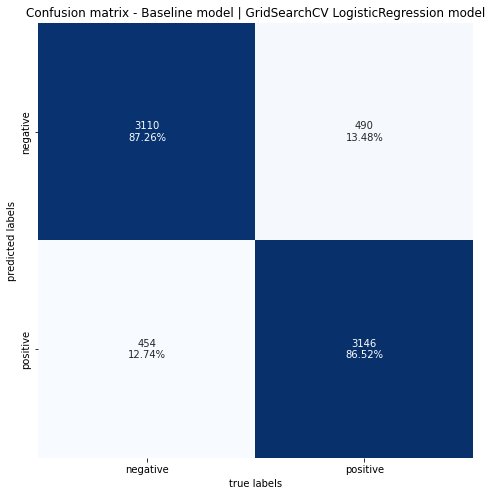

In [ ]:
# Evaluation report
graph_name = "Baseline model | GridSearchCV LogisticRegression model"
evaluation_report(
    logistic_regression_best_estimator,
    vectorizer,
    x_val,
    y_val,
    graph_name
)

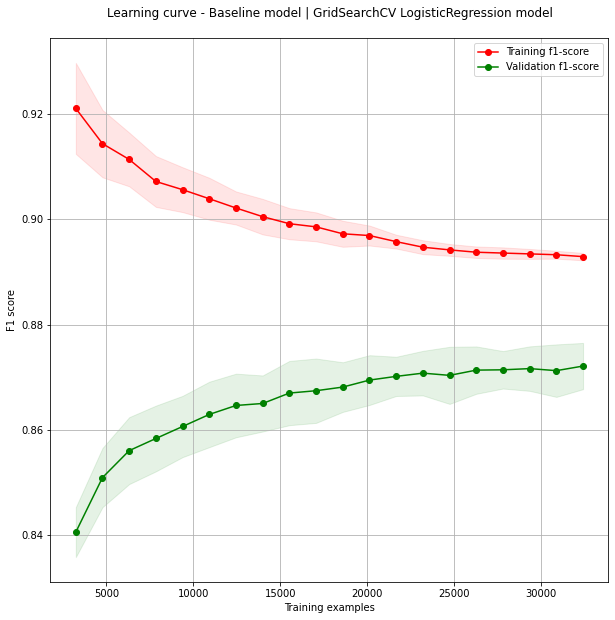

In [ ]:
plot_learning_curve( 
    n_splits = 15,
    test_size = 0.1,
    train_buckets = 20,
    trainable_vectors = all_trainable_vector_reviews,
    target_sample = y_train,
    model_estimator = logistic_regression_best_estimator,
    graph_name = graph_name
)

#### 7.5 (Path 3) Testing regularization

##### 7.5.1 Testing L1 regularization

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 29 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   28.7s finished


              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      3600
    positive       0.87      0.87      0.87      3600

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200

Evaluation metrics: Penalized L1 LogisticRegression model 

precision score: 0.8693 
recall_score: 0.8693 
f1_score: 0.8693

model bias: 0.1193
model variance: 0.25




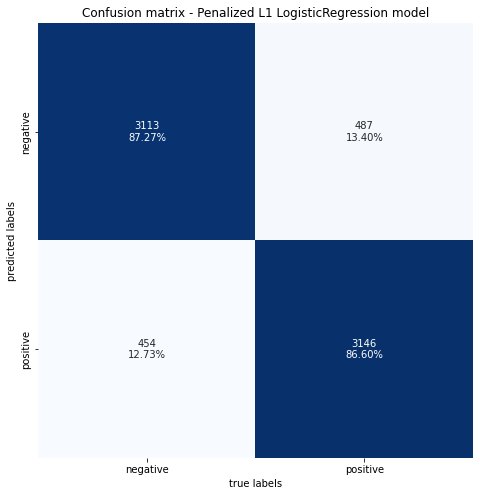

In [ ]:
# Logistic Regression with Penalty

# Classifier
logistic_regression_l1 = LogisticRegression(
    random_state = np.random.RandomState(0),
    penalty = "l1", #initially we won't use any regularization penalty technique.
    C = 0.8,
    solver = "saga",
    multi_class  = "ovr",
    max_iter = 150, #doesn't seem to really affect the model results after testing values like [10,25,50,150,200,1000]
    verbose = 10,
    n_jobs = -1
)

# Fit the model
logistic_regression_l1.fit(trainable_vector_reviews, y_train_fit.values)

graph_name = "Penalized L1 LogisticRegression model"
# Evaluation report
evaluation_report(
    logistic_regression_l1,
    vectorizer,
    x_val,
    y_val,
    graph_name
)

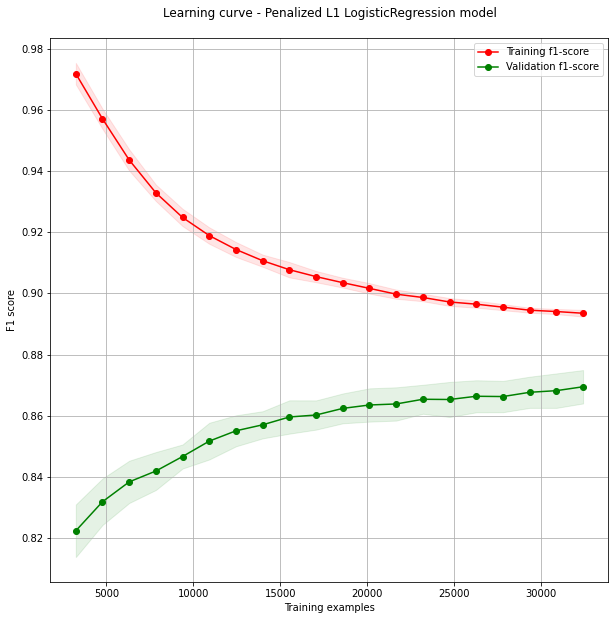

In [ ]:
# Learning Curve
plot_learning_curve( n_splits = 15, test_size = 0.1, train_buckets = 20, trainable_vectors = all_trainable_vector_reviews, target_sample = y_train, model_estimator = logistic_regression_l1, graph_name = graph_name )

##### 7.5.2 Testing L2 regularization

In [ ]:
# Logistic Regression with Penalty

# Classifier
logistic_regression_l2 = LogisticRegression(
    random_state = np.random.RandomState(0),
    penalty = "l2", #initially we won't use any regularization penalty technique.
    C = 0.8,
    solver = "lbfgs",
    multi_class  = "ovr",
    max_iter = 150,
    verbose = 10,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.7s finished


              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      3600
    positive       0.86      0.87      0.86      3600

    accuracy                           0.86      7200
   macro avg       0.86      0.86      0.86      7200
weighted avg       0.86      0.86      0.86      7200

Evaluation metrics: Penalized L2 LogisticRegression model 

precision score: 0.8642 
recall_score: 0.8642 
f1_score: 0.8642

model bias: 0.1142
model variance: 0.25




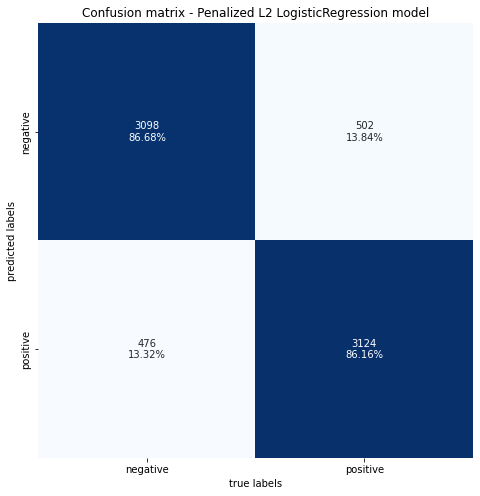

In [ ]:
# Fit the model
logistic_regression_l2.fit(trainable_vector_reviews, y_train_fit.values)

graph_name = "Penalized L2 LogisticRegression model"
# Evaluation report
evaluation_report(
    logistic_regression_l2,
    vectorizer,
    x_val,
    y_val,
    graph_name
)

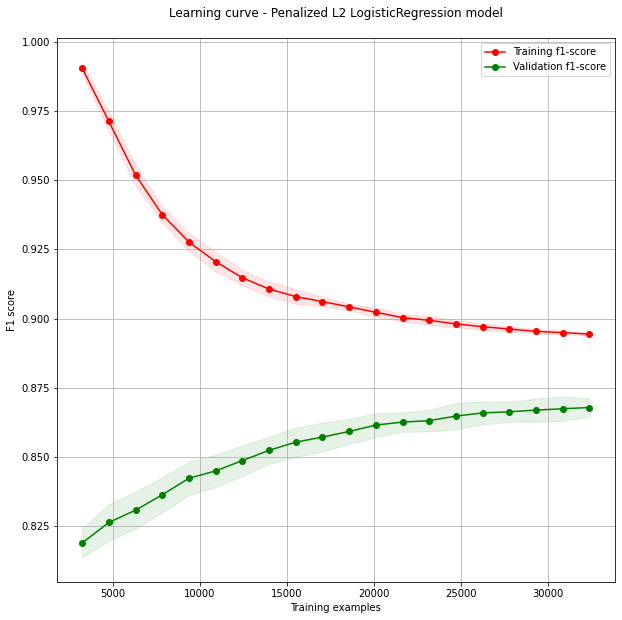

In [ ]:
# Learning Curve
plot_learning_curve( n_splits = 15, test_size = 0.1, train_buckets = 20, trainable_vectors = all_trainable_vector_reviews, target_sample = y_train, model_estimator = logistic_regression_l2, graph_name = graph_name )

#### 7.6 (path 4) Increase/Decrease the vector size of CountVectorizer object

> Input model classifier: CLassifier object of Path 2

##### 7.6.1 Increase vector size (+1000)

In [ ]:
reviews = x_features.values # Use all the sentences/reviews of the sample

vectorizer = CountVectorizer(
    lowercase = True,
    analyzer = 'word',
    ngram_range = (1,2), # unigrams & bigrams
    min_df = 5, # When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature.
    max_df = 0.95, # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    max_features = 2500
)

# tokenize and build vocab
vectorizer.fit(reviews)

print("index of word 'good': ", vectorizer.vocabulary_["good"]) # index of a unigram word in the our created vocabulary
print("index of word 'good movie': ", vectorizer.vocabulary_["good movie"]) # index of a bigram word in the created vocabulary

print("total vocabulary length: ", len(vectorizer.vocabulary_))

dump(vectorizer, checkpoint_3) # checkpoint 3

index of word 'good':  924
index of word 'good movie':  931
total vocabulary length:  2500


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_2500vectors.pkl']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished


              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      3600
    positive       0.86      0.87      0.87      3600

    accuracy                           0.86      7200
   macro avg       0.86      0.86      0.86      7200
weighted avg       0.86      0.86      0.86      7200

Evaluation metrics: 2500 vector size 

precision score: 0.8646 
recall_score: 0.8646 
f1_score: 0.8646

model bias: 0.1146
model variance: 0.25




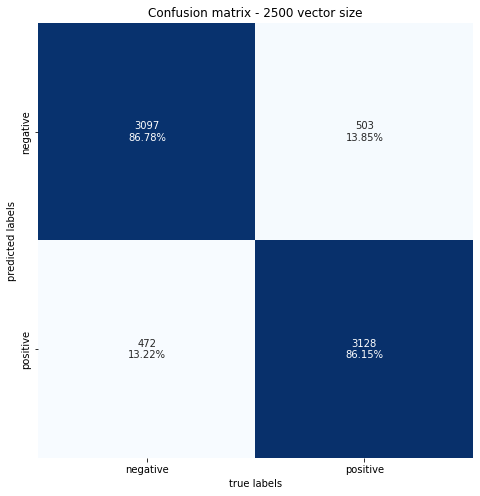

In [ ]:
vectorizer = load(checkpoint_3)

# Trainable features vectorized
trainable_vector_reviews = vectorizer.transform(x_train_fit) # subset of x_train (0.8 for fit() and 0.2 for validation)
all_trainable_vector_reviews = vectorizer.transform(x_train) # x_train

# Model fit
# Fit the model
logistic_regression_l2.fit(trainable_vector_reviews, y_train_fit.values)

# Model metrics
graph_name = "2500 vector size"
# Evaluation report
evaluation_report(
    logistic_regression_l2,
    vectorizer,
    x_val,
    y_val,
    graph_name
)

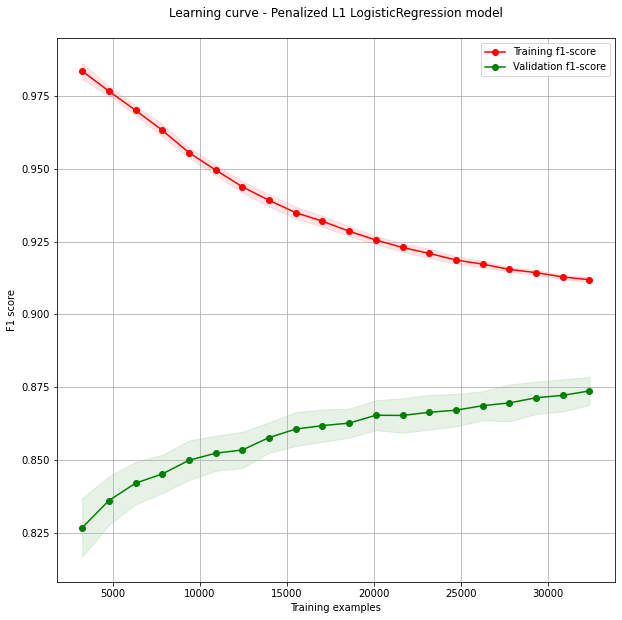

In [ ]:
plot_learning_curve( n_splits = 15, test_size = 0.1, train_buckets = 20, trainable_vectors = all_trainable_vector_reviews, target_sample = y_train, model_estimator = logistic_regression_l1, graph_name = graph_name )

##### 7.6.2 Decrease vector size (-1000)

In [ ]:
reviews = x_features.values # Use all the sentences/reviews of the sample

vectorizer = CountVectorizer(
    lowercase = True,
    analyzer = 'word',
    ngram_range = (1,2), # unigrams & bigrams
    min_df = 5, # When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature.
    max_df = 0.95, # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    max_features = 500
)

# tokenize and build vocab
vectorizer.fit(reviews)

# print("index of word 'good': ", vectorizer.vocabulary_["good"]) # index of a unigram word in the our created vocabulary
# print("index of word 'good movie': ", vectorizer.vocabulary_["good movie"]) # index of a bigram word in the created vocabulary

print("total vocabulary length: ", len(vectorizer.vocabulary_))

dump(vectorizer, checkpoint_4) # checkpoint 4

total vocabulary length:  500


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/countVectorizer_500vectors.pkl']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear]              precision    recall  f1-score   support

    negative       0.86      0.83      0.84      3621
    positive       0.83      0.86      0.85      3579

    accuracy                           0.84      7200
   macro avg       0.84      0.84      0.84      7200
weighted avg       0.84      0.84      0.84      7200

Evaluation metrics: GridSearchCV LogisticRegression model 

precision score: 0.8447 
recall_score: 0.8444 
f1_score: 0.8443

model bias: 0.094
model variance: 0.2497




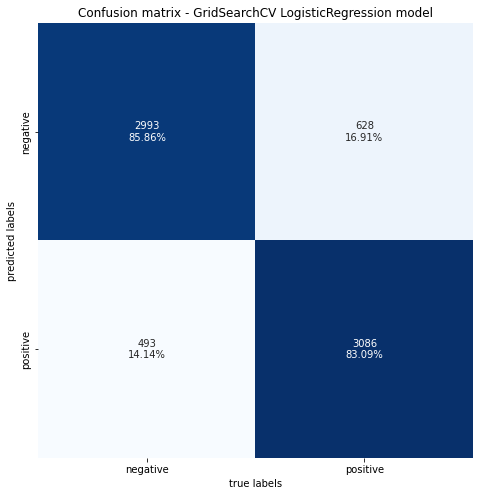

In [ ]:
# Trainable features vectorized
trainable_vector_reviews = vectorizer.transform(x_train_fit) # subset of x_train (0.8 for fit() and 0.2 for validation)
all_trainable_vector_reviews = vectorizer.transform(x_train) # x_train

# Model fit
# Fit the model
gridsearch_classifier.best_estimator_.fit(trainable_vector_reviews, y_train_fit.values)

# Model metrics
graph_name = "GridSearchCV LogisticRegression model"
# Evaluation report
evaluation_report(
    gridsearch_classifier.best_estimator_,
    vectorizer,
    x_val,
    y_val,
    graph_name
)

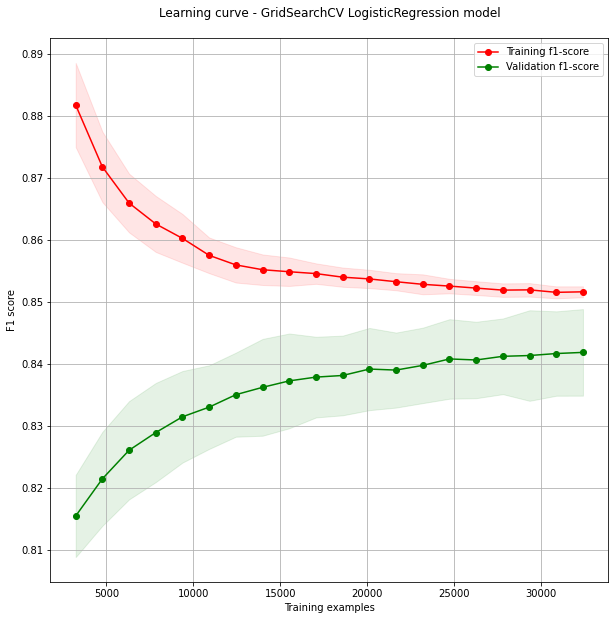

In [ ]:
plot_learning_curve( n_splits = 15, test_size = 0.1, train_buckets = 20, trainable_vectors = all_trainable_vector_reviews, target_sample = y_train, model_estimator = gridsearch_classifier.best_estimator_, graph_name = graph_name )

### Section 8: TF-IDF vectorizer | Model training

In [ ]:
trainable_vector_reviews = tfidf_vectorizer.transform(x_train_fit)
all_trainable_vector_reviews = tfidf_vectorizer.transform(x_train)

# summarize encoded vector
print(trainable_vector_reviews.shape)
print(all_trainable_vector_reviews.shape)

(28800, 1500)
(36000, 1500)


#### 8.1 Default values without regularization & cross-validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      3600
    positive       0.86      0.87      0.87      3600

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200

Evaluation metrics: TFIDF | Baseline Logistic Regression 

precision score: 0.8664 
recall_score: 0.8664 
f1_score: 0.8664

model bias: 0.1164
model variance: 0.25




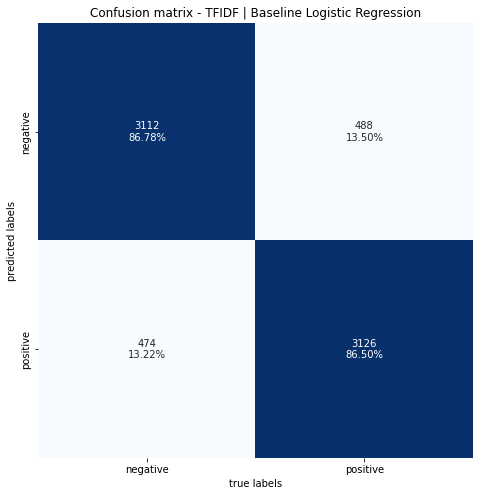

In [ ]:
baseline_logistic_regression.fit(trainable_vector_reviews, y_train_fit.values)

graph_name = "TFIDF | Baseline Logistic Regression"
evaluation_report(
    baseline_logistic_regression,
    tfidf_vectorizer,
    x_val,
    y_val,
    graph_name
)

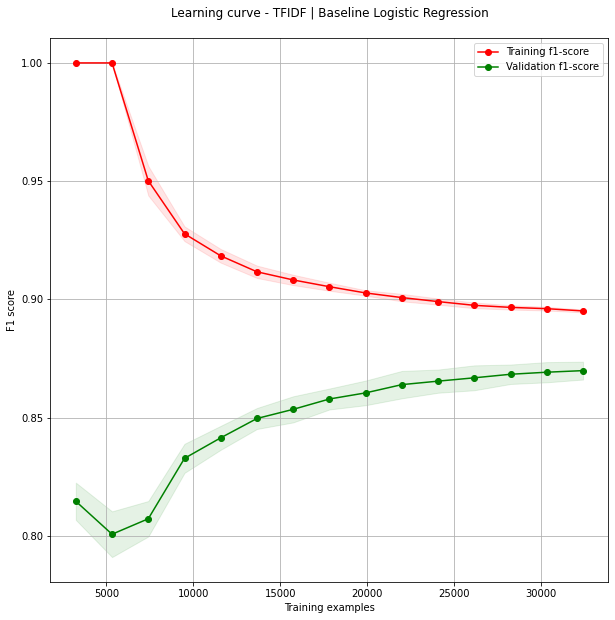

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.1,
    train_buckets = 15,
    trainable_vectors = all_trainable_vector_reviews,
    target_sample = y_train,
    model_estimator = baseline_logistic_regression,
    graph_name = graph_name
)

#### 8.2 L2 Regularization

              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      3600
    positive       0.87      0.87      0.87      3600

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200

Evaluation metrics: TFIDF | Baseline Logistic Regression 

precision score: 0.8710 
recall_score: 0.8710 
f1_score: 0.8710

model bias: 0.121
model variance: 0.25




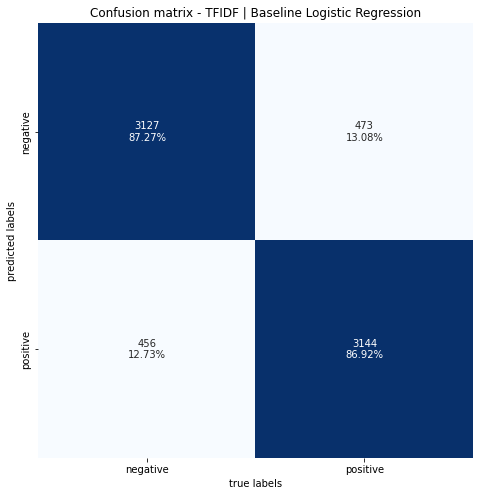

In [ ]:
logistic_regression_l2.fit(trainable_vector_reviews, y_train_fit.values)

# Evaluation report
graph_name = "TFIDF | Baseline Logistic Regression"
evaluation_report(
    logistic_regression_l2,
    tfidf_vectorizer,
    x_val,
    y_val,
    graph_name
)

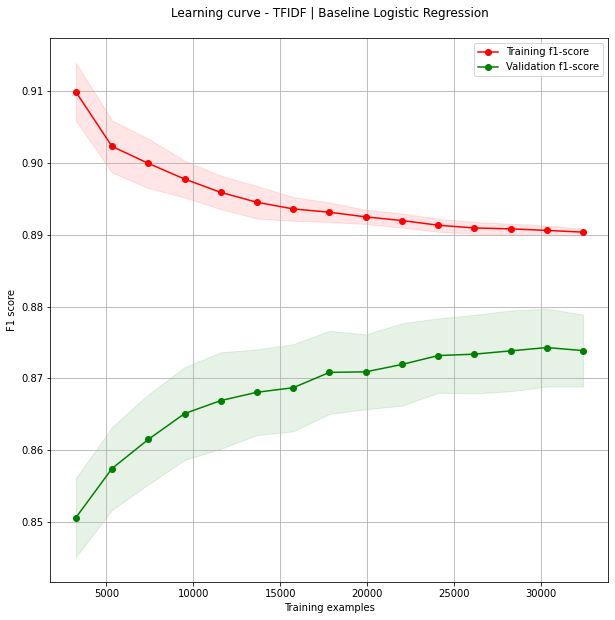

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.1,
    train_buckets = 15,
    trainable_vectors = all_trainable_vector_reviews,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name
)

#### 8.3 GridSearchCV with regularization & cross-validation 

In [ ]:
parameters_grid = {
    'penalty':['l1', 'l2'],
    'solver':['lbfgs', 'liblinear', 'saga'],
    'C':list(np.linspace(0.5, 0.9, 3)),
    'max_iter':[int(x) for x in list(np.linspace(25, 150, 4))]
}

scoring = {
            'f1_scoring': 'f1',
            'precision_scoring': 'precision',
            'recall_scoring': 'recall'
          }
refit_score = scoring['f1_scoring']

# Create stratified and shuffled cross validation rounds
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.1, random_state=np.random.RandomState(0))

gridsearch_classifier = GridSearchCV(
    estimator=LogisticRegression(
        random_state=np.random.RandomState(0),
        multi_class  = "ovr",
        verbose=10,
        n_jobs = -1
    ),
    param_grid=parameters_grid,
    cv=cv,
    verbose=10,
    n_jobs=1,
    scoring=scoring,
    refit="f1_scoring",
    return_train_score=True
)

# Fit the gridsearch object
gridsearch_classifier.fit(trainable_vector_reviews, y_train_fit.values)
print(f'\nbest parameters: {gridsearch_classifier.best_params_}')

# Save Logistic Regression GridSearchCV model
logistic_regression_best_estimator_tfdidf_vectorizer = gridsearch_classifier.best_estimator_
dump(logistic_regression_best_estimator_tfdidf_vectorizer, "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/tfidf_logistic_regression_best_estimator.joblib")

Fitting 15 folds for each of 120 candidates, totalling 1800 fits
[CV 1/15; 1/120] START C=0.3, max_iter=50, penalty=l1, solver=lbfgs.............
[CV 1/15; 1/120] END C=0.3, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 1/120] START C=0.3, max_iter=50, penalty=l1, solver=lbfgs.............
[CV 2/15; 1/120] END C=0.3, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 1/120] START C=0.3, max_iter=50, penalty=l1, solver=lbfgs.............
[CV 3/15; 1/120] END C=0.3, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 4/15; 1/120] START C=0.3, max_iter=50, penalty=l1, solver=lbfgs.............
[CV 4/15; 1/12

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.8s
[CV 2/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.7s
[CV 3/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.6s
[CV 4/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.4s
[CV 5/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.5s
[CV 6/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.4s
[CV 7/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.5s
[CV 9/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.5s
[CV 10/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.5s
[CV 11/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.7s
[CV 12/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.5s
[CV 13/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.5s
[CV 14/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.8s
[CV 15/15; 2/120] START C=0.3, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 2/120] END C=0.3, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.8s
[CV 1/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 1/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   1.8s
[CV 2/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[CV 2/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   1.4s
[CV 3/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 3/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   1.8s
[CV 4/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 4/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   2.1s
[CV 5/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 5/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   1.9s
[CV 6/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 6/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   2.0s
[CV 7/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 7/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.0s
[CV 8/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 8/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   1.8s
[CV 9/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs.............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 10/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 10/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.1s
[CV 11/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 11/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   1.8s
[CV 12/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 12/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   1.9s
[CV 13/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 13/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   2.0s
[CV 14/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 14/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   1.9s
[CV 15/15; 3/120] START C=0.3, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 15/15; 3/120] END C=0.3, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   2.0s
[CV 1/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.6s
[CV 2/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 4/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.5s
[CV 5/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.5s
[CV 6/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.4s
[CV 7/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.4s
[CV 8/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.4s
[CV 9/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear.........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 10/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 11/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.6s
[CV 12/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.5s
[CV 13/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.4s
[CV 14/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.4s
[CV 15/15; 4/120] START C=0.3, max_iter=50, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 4/120] END C=0.3, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.4s
[CV 1/15; 5/120] START C=0.3, max_iter=100, penalty=l1, solver=lbfgs............
[CV 1/15; 5/120] END C=0.3, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 5/120] START C=0.3, max_iter=100, penalty=l1, solver=lbfgs............
[CV 2/15; 5/120] END C=0.3, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 5/120] START C=0.3, max_iter=100, penalty=l1, solver=lbfgs............
[CV 3/15; 5/120] END C=0.3, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.5s
[CV 2/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.5s
[CV 3/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.6s
[CV 4/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.5s
[CV 5/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.6s
[CV 6/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.5s
[CV 7/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.5s
[CV 9/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.4s
[CV 10/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.4s
[CV 11/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.5s
[CV 12/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.5s
[CV 13/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.5s
[CV 14/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.6s
[CV 15/15; 6/120] START C=0.3, max_iter=100, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 6/120] END C=0.3, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.5s
[CV 1/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 1/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   2.1s
[CV 2/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 2/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   1.9s
[CV 3/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 3/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.0s
[CV 4/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 4/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   1.8s
[CV 5/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 5/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   1.9s
[CV 6/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 6/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   1.9s
[CV 7/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 7/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.0s
[CV 8/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 8/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   2.0s
[CV 9/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   2.1s
[CV 10/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 10/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   1.9s
[CV 11/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 11/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   2.2s
[CV 12/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


[CV 12/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   1.8s
[CV 13/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 13/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   1.9s
[CV 14/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 14/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   1.8s
[CV 15/15; 7/120] START C=0.3, max_iter=100, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 15/15; 7/120] END C=0.3, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   1.9s
[CV 1/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.4s
[CV 2/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 4/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.4s
[CV 5/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.5s
[CV 6/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.5s
[CV 7/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.4s
[CV 8/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.4s
[CV 9/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 10/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 11/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 12/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.4s
[CV 13/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.5s
[CV 14/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.6s
[CV 15/15; 8/120] START C=0.3, max_iter=100, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 8/120] END C=0.3, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.4s
[CV 1/15; 9/120] START C=0.3, max_iter=150, penalty=l1, solver=lbfgs............
[CV 1/15; 9/120] END C=0.3, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 9/120] START C=0.3, max_iter=150, penalty=l1, solver=lbfgs............
[CV 2/15; 9/120] END C=0.3, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 9/120] START C=0.3, max_iter=150, penalty=l1, solver=lbfgs............
[CV 3/15; 9/120] END C=0.3, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=na

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.5s
[CV 2/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.5s
[CV 3/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.6s
[CV 4/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.5s
[CV 5/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.6s
[CV 6/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.5s
[CV 7/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.6s
[CV 9/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.6s
[CV 10/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.6s
[CV 11/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.7s
[CV 12/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.5s
[CV 13/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.5s
[CV 14/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.6s
[CV 15/15; 10/120] START C=0.3, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 10/120] END C=0.3, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.5s
[CV 1/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 1/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   2.0s
[CV 2/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 2/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   2.1s
[CV 3/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.2s
[CV 4/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 4/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   1.9s
[CV 5/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 5/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   1.9s
[CV 6/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 6/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   1.9s
[CV 7/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 7/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.0s
[CV 8/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 8/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   1.9s
[CV 9/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 10/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.1s
[CV 11/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 11/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 12/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 12/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   1.9s
[CV 13/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 13/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   1.9s
[CV 14/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 14/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   1.9s
[CV 15/15; 11/120] START C=0.3, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 15/15; 11/120] END C=0.3, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   2.1s
[CV 1/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.4s
[CV 2/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 4/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.4s
[CV 5/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.4s
[CV 6/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.4s
[CV 7/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.4s
[CV 8/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.6s
[CV 9/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.6s
[CV 10/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.6s
[CV 11/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.7s
[CV 12/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.6s
[CV 13/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.6s
[CV 14/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.5s
[CV 15/15; 12/120] START C=0.3, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 12/120] END C=0.3, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.5s
[CV 1/15; 13/120] START C=0.3, max_iter=200, penalty=l1, solver=lbfgs...........
[CV 1/15; 13/120] END C=0.3, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 13/120] START C=0.3, max_iter=200, penalty=l1, solver=lbfgs...........
[CV 2/15; 13/120] END C=0.3, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 13/120] START C=0.3, max_iter=200, penalty=l1, solver=lbfgs...........
[CV 3/15; 13/120] END C=0.3, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, tes

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.6s
[CV 2/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.6s
[CV 3/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.6s
[CV 4/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.5s
[CV 5/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.5s
[CV 6/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.5s
[CV 7/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.5s
[CV 9/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.6s
[CV 10/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.6s
[CV 11/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.6s
[CV 12/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.4s
[CV 13/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.5s
[CV 14/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.5s
[CV 15/15; 14/120] START C=0.3, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 14/120] END C=0.3, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.5s
[CV 1/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   2.2s
[CV 2/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 2/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   2.0s
[CV 3/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 3/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   1.9s
[CV 4/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 4/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   1.9s
[CV 5/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 5/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   2.1s
[CV 6/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 6/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   2.0s
[CV 7/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 7/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.1s
[CV 8/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 8/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   2.0s
[CV 9/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 9/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   4.0s
[CV 10/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.2s
[CV 11/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 11/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 12/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   2.2s
[CV 13/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 13/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   1.8s
[CV 14/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


[CV 14/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   1.8s
[CV 15/15; 15/120] START C=0.3, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 15/15; 15/120] END C=0.3, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   1.9s
[CV 1/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.4s
[CV 2/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 4/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.4s
[CV 5/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.4s
[CV 6/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.6s
[CV 7/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.6s
[CV 8/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.6s
[CV 9/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.5s
[CV 10/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.5s
[CV 11/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 12/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.4s
[CV 13/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.4s
[CV 14/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.4s
[CV 15/15; 16/120] START C=0.3, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 16/120] END C=0.3, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.5s
[CV 1/15; 17/120] START C=0.3, max_iter=250, penalty=l1, solver=lbfgs...........
[CV 1/15; 17/120] END C=0.3, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 17/120] START C=0.3, max_iter=250, penalty=l1, solver=lbfgs...........
[CV 2/15; 17/120] END C=0.3, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 17/120] START C=0.3, max_iter=250, penalty=l1, solver=lbfgs...........
[CV 3/15; 17/120] END C=0.3, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, tes

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.6s
[CV 2/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.6s
[CV 3/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.7s
[CV 4/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.5s
[CV 5/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.6s
[CV 6/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.6s
[CV 7/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.5s
[CV 9/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.5s
[CV 10/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.5s
[CV 11/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.6s
[CV 12/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.4s
[CV 13/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.5s
[CV 14/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.5s
[CV 15/15; 18/120] START C=0.3, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 18/120] END C=0.3, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.5s
[CV 1/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 1/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   2.0s
[CV 2/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 2/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   2.3s
[CV 3/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 3/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.0s
[CV 4/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 4/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   2.0s
[CV 5/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 5/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   2.0s
[CV 6/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 6/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   2.0s
[CV 7/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 7/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.0s
[CV 8/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 8/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   2.0s
[CV 9/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 9/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 10/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.2s
[CV 11/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 11/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 12/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 12/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   1.9s
[CV 13/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 13/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   2.0s
[CV 14/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   2.4s
[CV 15/15; 19/120] START C=0.3, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 15/15; 19/120] END C=0.3, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   2.0s
[CV 1/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.5s
[CV 2/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 4/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.4s
[CV 5/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.4s
[CV 6/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.4s
[CV 7/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.4s
[CV 8/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.4s
[CV 9/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 10/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 11/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.6s
[CV 12/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.4s
[CV 13/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.4s
[CV 14/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.4s
[CV 15/15; 20/120] START C=0.3, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 20/120] END C=0.3, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.6s
[CV 1/15; 21/120] START C=0.3, max_iter=300, penalty=l1, solver=lbfgs...........
[CV 1/15; 21/120] END C=0.3, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 21/120] START C=0.3, max_iter=300, penalty=l1, solver=lbfgs...........
[CV 2/15; 21/120] END C=0.3, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 21/120] START C=0.3, max_iter=300, penalty=l1, solver=lbfgs...........
[CV 3/15; 21/120] END C=0.3, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, tes

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.860) precision_scoring: (train=0.858, test=0.842) recall_scoring: (train=0.889, test=0.879) total time=   0.6s
[CV 2/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.859, test=0.837) recall_scoring: (train=0.889, test=0.876) total time=   0.5s
[CV 3/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.857, test=0.849) recall_scoring: (train=0.888, test=0.875) total time=   0.7s
[CV 4/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.862) precision_scoring: (train=0.858, test=0.841) recall_scoring: (train=0.888, test=0.885) total time=   0.5s
[CV 5/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.871) precision_scoring: (train=0.855, test=0.869) recall_scoring: (train=0.887, test=0.872) total time=   0.6s
[CV 6/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.849) precision_scoring: (train=0.857, test=0.832) recall_scoring: (train=0.887, test=0.867) total time=   0.6s
[CV 7/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.866) precision_scoring: (train=0.857, test=0.853) recall_scoring: (train=0.887, test=0.880) total time=   0.5s
[CV 8/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.873) precision_scoring: (train=0.857, test=0.862) recall_scoring: (train=0.886, test=0.883) total time=   0.5s
[CV 9/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.863) precision_scoring: (train=0.857, test=0.836) recall_scoring: (train=0.888, test=0.892) total time=   0.5s
[CV 10/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.853) precision_scoring: (train=0.857, test=0.838) recall_scoring: (train=0.887, test=0.868) total time=   0.5s
[CV 11/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.872, test=0.868) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.887, test=0.888) total time=   0.6s
[CV 12/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.850) precision_scoring: (train=0.858, test=0.838) recall_scoring: (train=0.888, test=0.863) total time=   0.4s
[CV 13/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.874, test=0.856) precision_scoring: (train=0.860, test=0.840) recall_scoring: (train=0.889, test=0.873) total time=   0.4s
[CV 14/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.873, test=0.858) precision_scoring: (train=0.858, test=0.849) recall_scoring: (train=0.888, test=0.867) total time=   0.5s
[CV 15/15; 22/120] START C=0.3, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 22/120] END C=0.3, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.871, test=0.877) precision_scoring: (train=0.857, test=0.864) recall_scoring: (train=0.886, test=0.890) total time=   0.5s
[CV 1/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 1/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   2.1s
[CV 2/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 2/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   2.2s
[CV 3/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 3/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   1.9s
[CV 4/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 4/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.871) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.897) total time=   2.0s
[CV 5/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 5/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.895, test=0.880) total time=   2.0s
[CV 6/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 6/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   2.3s
[CV 7/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 7/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   2.0s
[CV 8/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 8/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   2.0s
[CV 9/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 9/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   2.2s
[CV 10/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 10/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   2.0s
[CV 11/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 11/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   2.0s
[CV 12/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.874, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   2.2s
[CV 13/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 13/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   2.1s
[CV 14/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 14/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.885, test=0.867) precision_scoring: (train=0.874, test=0.853) recall_scoring: (train=0.896, test=0.881) total time=   1.9s
[CV 15/15; 23/120] START C=0.3, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 15/15; 23/120] END C=0.3, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   2.2s
[CV 1/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.876) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.895, test=0.898) total time=   0.4s
[CV 2/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.866) precision_scoring: (train=0.874, test=0.844) recall_scoring: (train=0.898, test=0.889) total time=   0.4s
[CV 3/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.6s
[CV 4/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.870) precision_scoring: (train=0.873, test=0.846) recall_scoring: (train=0.894, test=0.896) total time=   0.5s
[CV 5/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.871, test=0.881) recall_scoring: (train=0.895, test=0.880) total time=   0.4s
[CV 6/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.868) precision_scoring: (train=0.873, test=0.855) recall_scoring: (train=0.896, test=0.882) total time=   0.5s
[CV 7/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.876) precision_scoring: (train=0.872, test=0.863) recall_scoring: (train=0.896, test=0.889) total time=   0.6s
[CV 8/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.877) precision_scoring: (train=0.873, test=0.872) recall_scoring: (train=0.898, test=0.881) total time=   0.5s
[CV 9/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.868) precision_scoring: (train=0.874, test=0.842) recall_scoring: (train=0.897, test=0.895) total time=   0.4s
[CV 10/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.870) precision_scoring: (train=0.873, test=0.862) recall_scoring: (train=0.897, test=0.879) total time=   0.4s
[CV 11/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.872, test=0.861) recall_scoring: (train=0.897, test=0.895) total time=   0.6s
[CV 12/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.855) precision_scoring: (train=0.875, test=0.848) recall_scoring: (train=0.899, test=0.863) total time=   0.4s
[CV 13/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.886, test=0.862) precision_scoring: (train=0.875, test=0.846) recall_scoring: (train=0.898, test=0.879) total time=   0.4s
[CV 14/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.885, test=0.866) precision_scoring: (train=0.874, test=0.852) recall_scoring: (train=0.896, test=0.881) total time=   0.4s
[CV 15/15; 24/120] START C=0.3, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 24/120] END C=0.3, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.874, test=0.866) recall_scoring: (train=0.894, test=0.885) total time=   0.4s
[CV 1/15; 25/120] START C=0.475, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 1/15; 25/120] END C=0.475, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 25/120] START C=0.475, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 2/15; 25/120] END C=0.475, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 25/120] START C=0.475, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 3/15; 25/120] END C=0.475, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.8s
[CV 2/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.7s
[CV 3/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.7s
[CV 4/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.5s
[CV 5/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.6s
[CV 6/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.6s
[CV 7/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.6s
[CV 8/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.7s
[CV 9/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.5s
[CV 10/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.5s
[CV 11/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.6s
[CV 12/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.6s
[CV 13/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 14/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.6s
[CV 15/15; 26/120] START C=0.475, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 26/120] END C=0.475, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.6s
[CV 1/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   2.1s
[CV 2/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 2/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   2.2s
[CV 3/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.2s
[CV 4/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.3s
[CV 5/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 5/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.1s
[CV 6/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 6/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   2.0s
[CV 7/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.4s
[CV 8/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 9/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 9/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.2s
[CV 10/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 10/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.6s
[CV 11/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.3s
[CV 12/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.3s
[CV 13/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 13/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.1s
[CV 14/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.1s
[CV 15/15; 27/120] START C=0.475, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 15/15; 27/120] END C=0.475, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   2.2s
[CV 1/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.6s
[CV 2/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.7s
[CV 3/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.7s
[CV 4/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.5s
[CV 5/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 6/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.7s
[CV 7/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.7s
[CV 8/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 9/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.5s
[CV 10/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 11/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.5s
[CV 12/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.6s
[CV 13/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.7s
[CV 14/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.7s
[CV 15/15; 28/120] START C=0.475, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 28/120] END C=0.475, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.6s
[CV 1/15; 29/120] START C=0.475, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 1/15; 29/120] END C=0.475, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 29/120] START C=0.475, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 2/15; 29/120] END C=0.475, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 29/120] START C=0.475, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 3/15; 29/120] END C=0.475, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=n

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.6s
[CV 2/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.5s
[CV 3/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.5s
[CV 4/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.5s
[CV 5/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.5s
[CV 6/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.5s
[CV 7/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.6s
[CV 8/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.8s
[CV 9/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.6s
[CV 10/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 11/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.6s
[CV 12/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.7s
[CV 13/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.5s
[CV 14/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.5s
[CV 15/15; 30/120] START C=0.475, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 30/120] END C=0.475, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.6s
[CV 1/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 1/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   2.6s
[CV 2/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 2/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   2.1s
[CV 3/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.2s
[CV 4/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 4/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.0s
[CV 5/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.3s
[CV 6/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 6/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   2.0s
[CV 7/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.3s
[CV 8/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 8/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.3s
[CV 9/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 9/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.3s
[CV 10/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.4s
[CV 11/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 11/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.2s
[CV 12/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.1s
[CV 13/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 13/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.5s
[CV 14/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 14/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.0s
[CV 15/15; 31/120] START C=0.475, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 15/15; 31/120] END C=0.475, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   2.1s
[CV 1/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.7s
[CV 2/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.6s
[CV 3/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.5s
[CV 4/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.6s
[CV 5/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.6s
[CV 6/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.8s
[CV 7/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.8s
[CV 8/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.8s
[CV 9/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.8s
[CV 10/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.7s
[CV 11/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.7s
[CV 12/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.7s
[CV 13/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.6s
[CV 14/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 15/15; 32/120] START C=0.475, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 32/120] END C=0.475, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.6s
[CV 1/15; 33/120] START C=0.475, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 1/15; 33/120] END C=0.475, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 33/120] START C=0.475, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 2/15; 33/120] END C=0.475, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 33/120] START C=0.475, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 3/15; 33/120] END C=0.475, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.7s
[CV 2/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.6s
[CV 3/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.6s
[CV 4/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.6s
[CV 5/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.6s
[CV 6/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.6s
[CV 7/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.6s
[CV 8/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.8s
[CV 9/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.6s
[CV 10/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 11/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.6s
[CV 12/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.6s
[CV 13/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.5s
[CV 14/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.5s
[CV 15/15; 34/120] START C=0.475, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 34/120] END C=0.475, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.6s
[CV 1/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 1/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   2.3s
[CV 2/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 2/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   2.7s
[CV 3/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.4s
[CV 4/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.2s
[CV 5/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 5/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.1s
[CV 6/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 6/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   2.1s
[CV 7/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.2s
[CV 8/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 9/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 9/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.2s
[CV 10/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.2s
[CV 11/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 11/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.2s
[CV 12/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.4s
[CV 13/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.3s
[CV 14/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 14/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.3s
[CV 15/15; 35/120] START C=0.475, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 15/15; 35/120] END C=0.475, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   2.4s
[CV 1/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.5s
[CV 2/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.5s
[CV 3/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.7s
[CV 4/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.6s
[CV 5/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 6/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.6s
[CV 7/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.7s
[CV 8/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 9/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.5s
[CV 10/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 11/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.5s
[CV 12/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.5s
[CV 13/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.7s
[CV 14/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.7s
[CV 15/15; 36/120] START C=0.475, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 36/120] END C=0.475, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.6s
[CV 1/15; 37/120] START C=0.475, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 1/15; 37/120] END C=0.475, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 37/120] START C=0.475, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 2/15; 37/120] END C=0.475, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 37/120] START C=0.475, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 3/15; 37/120] END C=0.475, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.6s
[CV 2/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.5s
[CV 3/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.5s
[CV 4/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.5s
[CV 5/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.6s
[CV 6/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.6s
[CV 7/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.5s
[CV 8/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.7s
[CV 9/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.6s
[CV 10/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.5s
[CV 11/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.6s
[CV 12/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.8s
[CV 13/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 14/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.6s
[CV 15/15; 38/120] START C=0.475, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 38/120] END C=0.475, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   1.1s
[CV 1/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV 1/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   5.0s
[CV 2/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV 2/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   4.0s
[CV 3/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.5s
[CV 4/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 4/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.1s
[CV 5/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.5s
[CV 6/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 6/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   2.0s
[CV 7/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.4s
[CV 8/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 9/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 9/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.1s
[CV 10/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.2s
[CV 11/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 11/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.1s
[CV 12/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.1s
[CV 13/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.3s
[CV 14/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.1s
[CV 15/15; 39/120] START C=0.475, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 15/15; 39/120] END C=0.475, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   2.4s
[CV 1/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.6s
[CV 2/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.5s
[CV 3/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.6s
[CV 4/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.7s
[CV 5/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 6/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.5s
[CV 7/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.7s
[CV 8/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 9/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.5s
[CV 10/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 11/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.5s
[CV 12/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.7s
[CV 13/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.5s
[CV 14/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 15/15; 40/120] START C=0.475, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 40/120] END C=0.475, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.7s
[CV 1/15; 41/120] START C=0.475, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 1/15; 41/120] END C=0.475, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 41/120] START C=0.475, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 2/15; 41/120] END C=0.475, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 41/120] START C=0.475, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 3/15; 41/120] END C=0.475, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.7s
[CV 2/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.5s
[CV 3/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.5s
[CV 4/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.5s
[CV 5/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.7s
[CV 6/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.6s
[CV 7/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.6s
[CV 8/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.8s
[CV 9/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.6s
[CV 10/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 11/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.7s
[CV 12/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.8s
[CV 13/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 14/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.5s
[CV 15/15; 42/120] START C=0.475, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 42/120] END C=0.475, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.7s
[CV 1/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   2.1s
[CV 2/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   2.3s
[CV 3/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.2s
[CV 4/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.2s
[CV 5/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 5/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.7s
[CV 6/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 6/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   1.9s
[CV 7/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 7/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.1s
[CV 8/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 9/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 9/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.3s
[CV 10/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 10/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.3s
[CV 11/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 11/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.2s
[CV 12/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.3s
[CV 13/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.2s
[CV 14/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 14/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.3s
[CV 15/15; 43/120] START C=0.475, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 15/15; 43/120] END C=0.475, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   3.0s
[CV 1/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.7s
[CV 2/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.5s
[CV 3/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.5s
[CV 4/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.7s
[CV 5/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 6/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.5s
[CV 7/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.5s
[CV 8/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 9/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.7s
[CV 10/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.6s
[CV 11/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.5s
[CV 12/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.5s
[CV 13/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.5s
[CV 14/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.7s
[CV 15/15; 44/120] START C=0.475, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 44/120] END C=0.475, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.6s
[CV 1/15; 45/120] START C=0.475, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 1/15; 45/120] END C=0.475, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 45/120] START C=0.475, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 2/15; 45/120] END C=0.475, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 45/120] START C=0.475, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 3/15; 45/120] END C=0.475, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.868) precision_scoring: (train=0.868, test=0.849) recall_scoring: (train=0.895, test=0.889) total time=   0.6s
[CV 2/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.871, test=0.849) recall_scoring: (train=0.898, test=0.881) total time=   0.5s
[CV 3/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.856) recall_scoring: (train=0.896, test=0.872) total time=   0.5s
[CV 4/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.868) precision_scoring: (train=0.869, test=0.850) recall_scoring: (train=0.895, test=0.886) total time=   0.5s
[CV 5/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.875) precision_scoring: (train=0.868, test=0.873) recall_scoring: (train=0.896, test=0.877) total time=   0.6s
[CV 6/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.864) precision_scoring: (train=0.869, test=0.852) recall_scoring: (train=0.895, test=0.876) total time=   0.6s
[CV 7/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.873) precision_scoring: (train=0.868, test=0.862) recall_scoring: (train=0.895, test=0.883) total time=   0.6s
[CV 8/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.873) precision_scoring: (train=0.869, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.7s
[CV 9/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.866) precision_scoring: (train=0.870, test=0.843) recall_scoring: (train=0.896, test=0.892) total time=   0.5s
[CV 10/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.864) precision_scoring: (train=0.870, test=0.849) recall_scoring: (train=0.896, test=0.879) total time=   0.5s
[CV 11/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.871, test=0.863) recall_scoring: (train=0.894, test=0.895) total time=   0.6s
[CV 12/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.857) precision_scoring: (train=0.870, test=0.850) recall_scoring: (train=0.897, test=0.864) total time=   0.8s
[CV 13/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.861) precision_scoring: (train=0.872, test=0.843) recall_scoring: (train=0.896, test=0.879) total time=   0.6s
[CV 14/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.864) precision_scoring: (train=0.872, test=0.855) recall_scoring: (train=0.896, test=0.873) total time=   0.5s
[CV 15/15; 46/120] START C=0.475, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 46/120] END C=0.475, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.868, test=0.868) recall_scoring: (train=0.895, test=0.879) total time=   0.6s
[CV 1/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 1/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.877, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   2.9s
[CV 2/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 2/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   2.7s
[CV 3/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 3/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   2.3s
[CV 4/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   2.2s
[CV 5/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   2.2s
[CV 6/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV 6/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   2.0s
[CV 7/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 7/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.900, test=0.888) total time=   2.8s
[CV 8/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 8/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 9/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 9/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   2.1s
[CV 10/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   2.3s
[CV 11/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   2.3s
[CV 12/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 12/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   2.0s
[CV 13/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   2.3s
[CV 14/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   2.1s
[CV 15/15; 47/120] START C=0.475, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 15/15; 47/120] END C=0.475, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   2.1s
[CV 1/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.878, test=0.863) recall_scoring: (train=0.897, test=0.903) total time=   0.5s
[CV 2/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.868) precision_scoring: (train=0.880, test=0.848) recall_scoring: (train=0.900, test=0.889) total time=   0.5s
[CV 3/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.872) precision_scoring: (train=0.878, test=0.867) recall_scoring: (train=0.899, test=0.876) total time=   0.5s
[CV 4/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.874) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.898, test=0.896) total time=   0.5s
[CV 5/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.876, test=0.883) recall_scoring: (train=0.899, test=0.881) total time=   0.5s
[CV 6/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.870) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.885) total time=   0.5s
[CV 7/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.877) precision_scoring: (train=0.877, test=0.866) recall_scoring: (train=0.899, test=0.888) total time=   0.5s
[CV 8/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 9/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.869) precision_scoring: (train=0.879, test=0.846) recall_scoring: (train=0.899, test=0.892) total time=   0.5s
[CV 10/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.888, test=0.873) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 11/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.882) precision_scoring: (train=0.878, test=0.868) recall_scoring: (train=0.899, test=0.896) total time=   0.6s
[CV 12/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.861) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.902, test=0.867) total time=   0.7s
[CV 13/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.866) precision_scoring: (train=0.880, test=0.852) recall_scoring: (train=0.901, test=0.880) total time=   0.7s
[CV 14/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.867) precision_scoring: (train=0.879, test=0.854) recall_scoring: (train=0.899, test=0.881) total time=   0.6s
[CV 15/15; 48/120] START C=0.475, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 48/120] END C=0.475, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.887, test=0.880) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.897, test=0.888) total time=   0.5s
[CV 1/15; 49/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs
[CV 1/15; 49/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 49/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs
[CV 2/15; 49/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 49/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs
[CV 3/15; 49/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (tr

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.5s
[CV 2/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 3/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.6s
[CV 4/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.6s
[CV 5/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.6s
[CV 6/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 7/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.6s
[CV 8/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   0.5s
[CV 9/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   0.6s
[CV 10/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   0.6s
[CV 11/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.5s
[CV 12/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.6s
[CV 13/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.5s
[CV 14/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 50/120] START C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 50/120] END C=0.6499999999999999, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.5s
[CV 1/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 1/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   3.0s
[CV 2/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 2/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   3.5s
[CV 3/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 3/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.5s
[CV 4/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.3s
[CV 5/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   2.4s
[CV 6/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 6/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.5s
[CV 7/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.2s
[CV 8/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 8/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   2.2s
[CV 9/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 9/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   3.1s
[CV 10/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.4s
[CV 11/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.3s
[CV 12/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 12/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.2s
[CV 13/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 13/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.1s
[CV 14/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 14/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.3s
[CV 15/15; 51/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 15/15; 51/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.3s
[CV 1/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.7s
[CV 2/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   0.5s
[CV 3/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 4/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.5s
[CV 5/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.6s
[CV 6/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.7s
[CV 7/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.7s
[CV 8/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.6s
[CV 9/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.5s
[CV 11/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.5s
[CV 12/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.5s
[CV 13/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.5s
[CV 14/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 15/15; 52/120] START C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 52/120] END C=0.6499999999999999, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.6s
[CV 1/15; 53/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfgs
[CV 1/15; 53/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 53/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfgs
[CV 2/15; 53/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 53/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfgs
[CV 3/15; 53/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=lbfg

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.6s
[CV 2/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 3/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.6s
[CV 4/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.6s
[CV 5/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.7s
[CV 6/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 7/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.6s
[CV 8/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   0.6s
[CV 9/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   0.6s
[CV 10/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   0.7s
[CV 11/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.6s
[CV 12/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.6s
[CV 13/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.5s
[CV 14/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 54/120] START C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 54/120] END C=0.6499999999999999, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.5s
[CV 1/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 1/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   3.0s
[CV 2/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 2/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   2.6s
[CV 3/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.4s
[CV 4/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 4/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.5s
[CV 5/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV 5/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   4.4s
[CV 6/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 6/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.1s
[CV 7/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 7/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.2s
[CV 8/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 8/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   2.3s
[CV 9/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   2.4s
[CV 10/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 10/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.7s
[CV 11/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 11/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.7s
[CV 12/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.3s
[CV 13/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.3s
[CV 14/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 14/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 15/15; 55/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 15/15; 55/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.5s
[CV 1/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.8s
[CV 2/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   1.2s
[CV 3/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.7s
[CV 4/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.7s
[CV 5/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.7s
[CV 6/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.7s
[CV 7/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.7s
[CV 8/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.7s
[CV 9/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.7s
[CV 10/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.6s
[CV 11/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.5s
[CV 12/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.7s
[CV 13/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.7s
[CV 14/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 15/15; 56/120] START C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 56/120] END C=0.6499999999999999, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.7s
[CV 1/15; 57/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbfgs
[CV 1/15; 57/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 57/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbfgs
[CV 2/15; 57/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 57/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbfgs
[CV 3/15; 57/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=lbf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.6s
[CV 2/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 3/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.6s
[CV 4/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.5s
[CV 5/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.6s
[CV 6/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.8s
[CV 7/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.6s
[CV 8/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   0.6s
[CV 9/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   0.5s
[CV 10/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   0.7s
[CV 11/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.6s
[CV 12/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.6s
[CV 13/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.5s
[CV 14/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 58/120] START C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 58/120] END C=0.6499999999999999, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.5s
[CV 1/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 1/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   3.0s
[CV 2/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 2/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   2.5s
[CV 3/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.2s
[CV 4/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.3s
[CV 5/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   2.3s
[CV 6/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 6/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.2s
[CV 7/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.4s
[CV 8/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   2.2s
[CV 9/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   2.4s
[CV 10/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.5s
[CV 11/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 11/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.9s
[CV 12/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 12/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.2s
[CV 13/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 13/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.1s
[CV 14/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 14/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 15/15; 59/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 15/15; 59/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.2s
[CV 1/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.7s
[CV 2/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   0.6s
[CV 3/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 4/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.5s
[CV 5/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.5s
[CV 6/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.5s
[CV 7/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.5s
[CV 8/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.7s
[CV 9/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.5s
[CV 11/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.5s
[CV 12/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.5s
[CV 13/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.5s
[CV 14/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 15/15; 60/120] START C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 60/120] END C=0.6499999999999999, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.5s
[CV 1/15; 61/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbfgs
[CV 1/15; 61/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 61/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbfgs
[CV 2/15; 61/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 61/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbfgs
[CV 3/15; 61/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=lbf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.5s
[CV 2/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.5s
[CV 3/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.6s
[CV 4/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.6s
[CV 5/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.6s
[CV 6/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.8s
[CV 7/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.7s
[CV 8/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   0.6s
[CV 9/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   0.5s
[CV 10/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   0.6s
[CV 11/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.5s
[CV 12/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.7s
[CV 13/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.7s
[CV 14/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.6s
[CV 15/15; 62/120] START C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 62/120] END C=0.6499999999999999, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.6s
[CV 1/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 1/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   3.2s
[CV 2/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 2/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   2.4s
[CV 3/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 3/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.4s
[CV 4/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 4/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.5s
[CV 5/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 5/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   2.1s
[CV 6/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.2s
[CV 7/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.4s
[CV 8/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   2.4s
[CV 9/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   2.5s
[CV 10/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.1s
[CV 11/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 11/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.5s
[CV 12/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 12/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.3s
[CV 13/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.6s
[CV 14/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 15/15; 63/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 15/15; 63/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.5s
[CV 1/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.5s
[CV 2/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   0.5s
[CV 3/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 4/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.7s
[CV 5/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.6s
[CV 6/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.5s
[CV 7/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.6s
[CV 8/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.7s
[CV 9/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.5s
[CV 11/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.5s
[CV 12/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.6s
[CV 13/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.7s
[CV 14/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 15/15; 64/120] START C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 64/120] END C=0.6499999999999999, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.5s
[CV 1/15; 65/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbfgs
[CV 1/15; 65/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 65/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbfgs
[CV 2/15; 65/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 65/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbfgs
[CV 3/15; 65/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=lbf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.5s
[CV 2/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 3/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.6s
[CV 4/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.7s
[CV 5/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.7s
[CV 6/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 7/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.6s
[CV 8/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   0.7s
[CV 9/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   0.6s
[CV 10/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   0.6s
[CV 11/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.5s
[CV 12/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.6s
[CV 13/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.6s
[CV 14/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 66/120] START C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 66/120] END C=0.6499999999999999, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.5s
[CV 1/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 1/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   2.2s
[CV 2/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 2/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   2.9s
[CV 3/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.5s
[CV 4/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.4s
[CV 5/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   2.5s
[CV 6/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.2s
[CV 7/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.3s
[CV 8/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 8/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   3.4s
[CV 9/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   2.6s
[CV 10/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.4s
[CV 11/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 11/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.3s
[CV 12/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.1s
[CV 13/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.4s
[CV 14/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 14/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.8s
[CV 15/15; 67/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 15/15; 67/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.4s
[CV 1/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.7s
[CV 2/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   0.6s
[CV 3/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 4/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.6s
[CV 5/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.7s
[CV 6/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.7s
[CV 7/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.5s
[CV 8/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.5s
[CV 9/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.7s
[CV 10/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.6s
[CV 11/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.5s
[CV 12/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.7s
[CV 13/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.7s
[CV 14/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 15/15; 68/120] START C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 68/120] END C=0.6499999999999999, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.5s
[CV 1/15; 69/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbfgs
[CV 1/15; 69/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 69/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbfgs
[CV 2/15; 69/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 69/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbfgs
[CV 3/15; 69/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=lbf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.857) recall_scoring: (train=0.898, test=0.891) total time=   0.6s
[CV 2/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 3/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.863) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.872) total time=   0.5s
[CV 4/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.853) recall_scoring: (train=0.898, test=0.887) total time=   0.5s
[CV 5/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.880) precision_scoring: (train=0.874, test=0.880) recall_scoring: (train=0.899, test=0.879) total time=   0.6s
[CV 6/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.877, test=0.855) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 7/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.876) precision_scoring: (train=0.875, test=0.865) recall_scoring: (train=0.898, test=0.886) total time=   0.6s
[CV 8/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.878) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.898, test=0.882) total time=   1.4s
[CV 9/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.869) precision_scoring: (train=0.876, test=0.846) recall_scoring: (train=0.900, test=0.893) total time=   1.0s
[CV 10/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.888, test=0.868) precision_scoring: (train=0.876, test=0.856) recall_scoring: (train=0.900, test=0.881) total time=   1.0s
[CV 11/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.887, test=0.882) precision_scoring: (train=0.875, test=0.866) recall_scoring: (train=0.898, test=0.899) total time=   0.7s
[CV 12/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.860) precision_scoring: (train=0.877, test=0.851) recall_scoring: (train=0.901, test=0.870) total time=   0.7s
[CV 13/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.863) precision_scoring: (train=0.877, test=0.850) recall_scoring: (train=0.900, test=0.877) total time=   0.6s
[CV 14/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.866) precision_scoring: (train=0.878, test=0.854) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 70/120] START C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 70/120] END C=0.6499999999999999, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.886, test=0.874) precision_scoring: (train=0.875, test=0.871) recall_scoring: (train=0.898, test=0.878) total time=   0.5s
[CV 1/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 1/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   2.4s
[CV 2/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 2/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   2.6s
[CV 3/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 3/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   2.7s
[CV 4/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 4/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   2.1s
[CV 5/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   2.2s
[CV 6/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 6/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   2.1s
[CV 7/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   2.3s
[CV 8/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.878) total time=   2.4s
[CV 9/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.848) recall_scoring: (train=0.902, test=0.890) total time=   2.4s
[CV 10/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 10/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   2.3s
[CV 11/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 11/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   2.2s
[CV 12/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 12/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.868) total time=   2.5s
[CV 13/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   2.2s
[CV 14/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 14/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 15/15; 71/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 15/15; 71/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   2.7s
[CV 1/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.889, test=0.881) precision_scoring: (train=0.880, test=0.864) recall_scoring: (train=0.899, test=0.899) total time=   0.7s
[CV 2/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.882, test=0.849) recall_scoring: (train=0.901, test=0.889) total time=   0.7s
[CV 3/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.901, test=0.879) total time=   0.6s
[CV 4/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.880, test=0.856) recall_scoring: (train=0.899, test=0.895) total time=   0.5s
[CV 5/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.879, test=0.885) recall_scoring: (train=0.901, test=0.882) total time=   0.5s
[CV 6/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.901, test=0.882) total time=   0.5s
[CV 7/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.900, test=0.888) total time=   0.5s
[CV 8/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.876) precision_scoring: (train=0.881, test=0.875) recall_scoring: (train=0.900, test=0.877) total time=   0.5s
[CV 9/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.869) precision_scoring: (train=0.881, test=0.849) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.902, test=0.880) total time=   0.6s
[CV 11/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.883) precision_scoring: (train=0.881, test=0.870) recall_scoring: (train=0.901, test=0.897) total time=   0.7s
[CV 12/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.868) total time=   0.5s
[CV 13/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.854) recall_scoring: (train=0.902, test=0.877) total time=   0.5s
[CV 14/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.870) precision_scoring: (train=0.882, test=0.858) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 15/15; 72/120] START C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 72/120] END C=0.6499999999999999, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.890, test=0.879) precision_scoring: (train=0.880, test=0.873) recall_scoring: (train=0.899, test=0.884) total time=   0.5s
[CV 1/15; 73/120] START C=0.825, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 1/15; 73/120] END C=0.825, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 73/120] START C=0.825, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 2/15; 73/120] END C=0.825, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 73/120] START C=0.825, max_iter=50, penalty=l1, solver=lbfgs..........
[CV 3/15; 73/120] END C=0.825, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scorin

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.7s
[CV 2/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.5s
[CV 3/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 4/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.7s
[CV 5/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.7s
[CV 6/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.7s
[CV 7/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.8s
[CV 8/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.7s
[CV 9/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.7s
[CV 10/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.7s
[CV 11/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.7s
[CV 12/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.6s
[CV 13/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 14/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 15/15; 74/120] START C=0.825, max_iter=50, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 74/120] END C=0.825, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.6s
[CV 1/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 1/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.3s
[CV 2/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 2/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.5s
[CV 3/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.4s
[CV 4/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 4/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.7s
[CV 5/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 5/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.6s
[CV 6/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 6/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.5s
[CV 7/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.2s
[CV 8/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 8/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   2.3s
[CV 9/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.5s
[CV 10/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 10/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.3s
[CV 11/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.4s
[CV 12/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   2.4s
[CV 13/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.4s
[CV 14/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.4s
[CV 15/15; 75/120] START C=0.825, max_iter=50, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 15/15; 75/120] END C=0.825, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.5s
[CV 1/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.5s
[CV 2/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.5s
[CV 3/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.5s
[CV 4/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.5s
[CV 5/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 6/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.6s
[CV 7/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.5s
[CV 8/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.5s
[CV 9/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.5s
[CV 10/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 11/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.6s
[CV 12/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.5s
[CV 13/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.5s
[CV 14/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 76/120] START C=0.825, max_iter=50, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 76/120] END C=0.825, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 77/120] START C=0.825, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 1/15; 77/120] END C=0.825, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 77/120] START C=0.825, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 2/15; 77/120] END C=0.825, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 77/120] START C=0.825, max_iter=100, penalty=l1, solver=lbfgs.........
[CV 3/15; 77/120] END C=0.825, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=n

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.7s
[CV 2/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.4s
[CV 3/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.5s
[CV 4/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.6s
[CV 5/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 6/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.6s
[CV 7/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.7s
[CV 8/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.5s
[CV 9/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 10/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.7s
[CV 11/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.6s
[CV 12/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.6s
[CV 13/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 14/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.6s
[CV 15/15; 78/120] START C=0.825, max_iter=100, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 78/120] END C=0.825, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.6s
[CV 1/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 1/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.8s
[CV 2/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 2/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.5s
[CV 3/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 3/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.3s
[CV 4/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 4/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.5s
[CV 5/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 6/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 6/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.9s
[CV 7/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.3s
[CV 8/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   2.2s
[CV 9/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.5s
[CV 10/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.2s
[CV 11/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.4s
[CV 12/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 12/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   2.3s
[CV 13/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 13/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.5s
[CV 14/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.5s
[CV 15/15; 79/120] START C=0.825, max_iter=100, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 15/15; 79/120] END C=0.825, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.3s
[CV 1/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.5s
[CV 2/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.7s
[CV 3/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 4/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.7s
[CV 5/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 6/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.5s
[CV 8/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.5s
[CV 9/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.5s
[CV 10/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.5s
[CV 11/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.5s
[CV 12/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.7s
[CV 13/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.6s
[CV 14/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 80/120] START C=0.825, max_iter=100, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 80/120] END C=0.825, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 81/120] START C=0.825, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 1/15; 81/120] END C=0.825, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 81/120] START C=0.825, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 2/15; 81/120] END C=0.825, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 81/120] START C=0.825, max_iter=150, penalty=l1, solver=lbfgs.........
[CV 3/15; 81/120] END C=0.825, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.7s
[CV 2/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.4s
[CV 3/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.5s
[CV 4/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.6s
[CV 5/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 6/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.6s
[CV 7/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.7s
[CV 8/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.6s
[CV 9/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 10/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 11/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.6s
[CV 12/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.7s
[CV 13/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.7s
[CV 14/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.6s
[CV 15/15; 82/120] START C=0.825, max_iter=150, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 82/120] END C=0.825, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.5s
[CV 1/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 1/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.9s
[CV 2/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.3s
[CV 3/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.3s
[CV 4/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.3s
[CV 5/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.2s
[CV 6/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 6/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.4s
[CV 7/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 7/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.6s
[CV 8/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 8/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   3.0s
[CV 9/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.5s
[CV 10/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.4s
[CV 11/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 11/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.5s
[CV 12/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 12/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   3.3s
[CV 13/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.2s
[CV 14/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 14/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.2s
[CV 15/15; 83/120] START C=0.825, max_iter=150, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 15/15; 83/120] END C=0.825, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.2s
[CV 1/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.5s
[CV 2/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.5s
[CV 3/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.5s
[CV 4/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 5/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 6/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.7s
[CV 7/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.6s
[CV 8/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.5s
[CV 9/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.7s
[CV 10/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.6s
[CV 11/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.5s
[CV 12/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.5s
[CV 13/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.5s
[CV 14/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.7s
[CV 15/15; 84/120] START C=0.825, max_iter=150, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 84/120] END C=0.825, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.6s
[CV 1/15; 85/120] START C=0.825, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 1/15; 85/120] END C=0.825, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 85/120] START C=0.825, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 2/15; 85/120] END C=0.825, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 85/120] START C=0.825, max_iter=200, penalty=l1, solver=lbfgs.........
[CV 3/15; 85/120] END C=0.825, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.7s
[CV 2/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.4s
[CV 3/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.5s
[CV 4/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.5s
[CV 5/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.6s
[CV 6/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.6s
[CV 7/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.7s
[CV 8/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.6s
[CV 9/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 10/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.7s
[CV 11/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.7s
[CV 12/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.6s
[CV 13/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 14/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.5s
[CV 15/15; 86/120] START C=0.825, max_iter=200, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 86/120] END C=0.825, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.5s
[CV 1/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 1/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.9s
[CV 2/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 2/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.4s
[CV 3/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.4s
[CV 4/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.3s
[CV 5/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 6/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.3s
[CV 7/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.3s
[CV 8/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 8/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   2.8s
[CV 9/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 9/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.8s
[CV 10/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.2s
[CV 11/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.3s
[CV 12/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   2.3s
[CV 13/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.7s
[CV 14/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.1s
[CV 15/15; 87/120] START C=0.825, max_iter=200, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 15/15; 87/120] END C=0.825, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.4s
[CV 1/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.5s
[CV 2/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.7s
[CV 3/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 4/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.7s
[CV 5/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.7s
[CV 6/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.5s
[CV 8/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 9/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.7s
[CV 10/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 11/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.7s
[CV 12/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.5s
[CV 13/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.6s
[CV 14/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.7s
[CV 15/15; 88/120] START C=0.825, max_iter=200, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 88/120] END C=0.825, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.7s
[CV 1/15; 89/120] START C=0.825, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 1/15; 89/120] END C=0.825, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 89/120] START C=0.825, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 2/15; 89/120] END C=0.825, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 89/120] START C=0.825, max_iter=250, penalty=l1, solver=lbfgs.........
[CV 3/15; 89/120] END C=0.825, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.9s
[CV 2/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.5s
[CV 3/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 4/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.6s
[CV 5/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 6/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.6s
[CV 7/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.9s
[CV 8/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.6s
[CV 9/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 10/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 11/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.7s
[CV 12/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.7s
[CV 13/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.7s
[CV 14/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.6s
[CV 15/15; 90/120] START C=0.825, max_iter=250, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 90/120] END C=0.825, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.6s
[CV 1/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 1/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.8s
[CV 2/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.3s
[CV 3/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.4s
[CV 4/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.3s
[CV 5/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.4s
[CV 6/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 6/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.3s
[CV 7/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.5s
[CV 8/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 8/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   2.4s
[CV 9/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 9/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.8s
[CV 10/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.1s
[CV 11/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.3s
[CV 12/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 12/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   2.3s
[CV 13/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 13/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.4s
[CV 14/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.5s
[CV 15/15; 91/120] START C=0.825, max_iter=250, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 15/15; 91/120] END C=0.825, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.1s
[CV 1/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.5s
[CV 2/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.6s
[CV 3/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 4/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.5s
[CV 5/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 6/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.6s
[CV 8/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 9/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.5s
[CV 10/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.5s
[CV 11/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.5s
[CV 12/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.6s
[CV 13/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.7s
[CV 14/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 92/120] START C=0.825, max_iter=250, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 92/120] END C=0.825, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 93/120] START C=0.825, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 1/15; 93/120] END C=0.825, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 93/120] START C=0.825, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 2/15; 93/120] END C=0.825, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 93/120] START C=0.825, max_iter=300, penalty=l1, solver=lbfgs.........
[CV 3/15; 93/120] END C=0.825, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.879) precision_scoring: (train=0.879, test=0.861) recall_scoring: (train=0.900, test=0.897) total time=   0.8s
[CV 2/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.880, test=0.851) recall_scoring: (train=0.903, test=0.885) total time=   0.4s
[CV 3/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.868) precision_scoring: (train=0.881, test=0.860) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 4/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.889, test=0.871) precision_scoring: (train=0.879, test=0.856) recall_scoring: (train=0.899, test=0.888) total time=   0.7s
[CV 5/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.881) precision_scoring: (train=0.880, test=0.882) recall_scoring: (train=0.901, test=0.881) total time=   0.6s
[CV 6/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.882, test=0.856) recall_scoring: (train=0.902, test=0.881) total time=   0.6s
[CV 7/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.876) precision_scoring: (train=0.880, test=0.867) recall_scoring: (train=0.900, test=0.884) total time=   0.9s
[CV 8/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.877) precision_scoring: (train=0.881, test=0.877) recall_scoring: (train=0.900, test=0.878) total time=   0.6s
[CV 9/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.880, test=0.849) recall_scoring: (train=0.901, test=0.895) total time=   0.6s
[CV 10/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.872) precision_scoring: (train=0.880, test=0.862) recall_scoring: (train=0.902, test=0.883) total time=   0.6s
[CV 11/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.884) precision_scoring: (train=0.880, test=0.869) recall_scoring: (train=0.900, test=0.901) total time=   0.7s
[CV 12/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.862) precision_scoring: (train=0.881, test=0.855) recall_scoring: (train=0.903, test=0.869) total time=   0.6s
[CV 13/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.865) precision_scoring: (train=0.882, test=0.853) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 14/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.867) precision_scoring: (train=0.882, test=0.857) recall_scoring: (train=0.902, test=0.879) total time=   0.6s
[CV 15/15; 94/120] START C=0.825, max_iter=300, penalty=l1, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 94/120] END C=0.825, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.890, test=0.875) precision_scoring: (train=0.878, test=0.872) recall_scoring: (train=0.902, test=0.878) total time=   0.6s
[CV 1/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 1/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   2.9s
[CV 2/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 2/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   2.5s
[CV 3/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   2.2s
[CV 4/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 4/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   2.5s
[CV 5/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 5/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   2.3s
[CV 6/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 6/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.4s
[CV 7/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 7/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   2.2s
[CV 8/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   2.4s
[CV 9/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 9/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   2.3s
[CV 10/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   2.2s
[CV 11/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 11/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   2.6s
[CV 12/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 12/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   2.5s
[CV 13/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 13/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   2.2s
[CV 14/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 14/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   2.4s
[CV 15/15; 95/120] START C=0.825, max_iter=300, penalty=l2, solver=lbfgs........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 15/15; 95/120] END C=0.825, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   2.4s
[CV 1/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.881) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.900, test=0.900) total time=   0.7s
[CV 2/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.850) recall_scoring: (train=0.901, test=0.888) total time=   0.7s
[CV 3/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 4/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.859) recall_scoring: (train=0.901, test=0.895) total time=   0.5s
[CV 5/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.885) precision_scoring: (train=0.882, test=0.886) recall_scoring: (train=0.900, test=0.883) total time=   0.5s
[CV 6/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.869) precision_scoring: (train=0.883, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.882, test=0.873) recall_scoring: (train=0.902, test=0.884) total time=   0.6s
[CV 8/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.882, test=0.875) recall_scoring: (train=0.901, test=0.877) total time=   0.7s
[CV 9/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.882, test=0.848) recall_scoring: (train=0.901, test=0.890) total time=   0.5s
[CV 10/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.882, test=0.870) recall_scoring: (train=0.903, test=0.879) total time=   0.6s
[CV 11/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.884) precision_scoring: (train=0.883, test=0.871) recall_scoring: (train=0.902, test=0.898) total time=   0.7s
[CV 12/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.862) precision_scoring: (train=0.884, test=0.856) recall_scoring: (train=0.902, test=0.867) total time=   0.7s
[CV 13/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.866) precision_scoring: (train=0.883, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.6s
[CV 14/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.868) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.900, test=0.879) total time=   0.5s
[CV 15/15; 96/120] START C=0.825, max_iter=300, penalty=l2, solver=liblinear....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 96/120] END C=0.825, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.878) precision_scoring: (train=0.882, test=0.874) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 97/120] START C=1.0, max_iter=50, penalty=l1, solver=lbfgs............
[CV 1/15; 97/120] END C=1.0, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 97/120] START C=1.0, max_iter=50, penalty=l1, solver=lbfgs............
[CV 2/15; 97/120] END C=1.0, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 97/120] START C=1.0, max_iter=50, penalty=l1, solver=lbfgs............
[CV 3/15; 97/120] END C=1.0, max_iter=50, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.4s
[CV 2/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.6s
[CV 3/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.7s
[CV 4/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.6s
[CV 5/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 6/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.7s
[CV 7/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.4s
[CV 8/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   0.8s
[CV 9/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear........
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.5s
[CV 10/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.7s
[CV 11/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.5s
[CV 12/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.8s
[CV 13/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.9s
[CV 14/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.6s
[CV 15/15; 98/120] START C=1.0, max_iter=50, penalty=l1, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 98/120] END C=1.0, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.6s
[CV 1/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 1/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   3.2s
[CV 2/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.3s
[CV 3/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   2.4s
[CV 4/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.3s
[CV 5/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.3s
[CV 6/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.2s
[CV 7/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.3s
[CV 8/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.4s
[CV 9/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.6s
[CV 10/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 10/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.1s
[CV 11/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.5s
[CV 12/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 12/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.5s
[CV 13/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 13/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   2.6s
[CV 14/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 14/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.3s
[CV 15/15; 99/120] START C=1.0, max_iter=50, penalty=l2, solver=lbfgs...........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 15/15; 99/120] END C=1.0, max_iter=50, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   3.7s
[CV 1/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.8s
[CV 2/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.8s
[CV 3/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.7s
[CV 4/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.7s
[CV 5/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.5s
[CV 6/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.5s
[CV 8/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.7s
[CV 9/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear.......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.7s
[CV 10/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.7s
[CV 11/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.5s
[CV 12/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.5s
[CV 13/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.6s
[CV 14/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 15/15; 100/120] START C=1.0, max_iter=50, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 100/120] END C=1.0, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 101/120] START C=1.0, max_iter=100, penalty=l1, solver=lbfgs..........
[CV 1/15; 101/120] END C=1.0, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 101/120] START C=1.0, max_iter=100, penalty=l1, solver=lbfgs..........
[CV 2/15; 101/120] END C=1.0, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 101/120] START C=1.0, max_iter=100, penalty=l1, solver=lbfgs..........
[CV 3/15; 101/120] END C=1.0, max_iter=100, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.5s
[CV 2/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.6s
[CV 3/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.6s
[CV 4/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.6s
[CV 5/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 6/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.6s
[CV 7/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.4s
[CV 8/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   1.0s
[CV 9/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.6s
[CV 10/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.8s
[CV 11/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.5s
[CV 12/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.7s
[CV 13/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.7s
[CV 14/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.6s
[CV 15/15; 102/120] START C=1.0, max_iter=100, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 102/120] END C=1.0, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.6s
[CV 1/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 1/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   2.8s
[CV 2/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.3s
[CV 3/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 3/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   2.2s
[CV 4/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 4/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.5s
[CV 5/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 5/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.3s
[CV 6/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 6/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.3s
[CV 7/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 7/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.4s
[CV 8/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 8/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.2s
[CV 9/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 9/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.5s
[CV 10/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.3s
[CV 11/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 11/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.5s
[CV 12/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 12/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.4s
[CV 13/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 13/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   3.0s
[CV 14/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 14/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.5s
[CV 15/15; 103/120] START C=1.0, max_iter=100, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 15/15; 103/120] END C=1.0, max_iter=100, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   2.5s
[CV 1/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.7s
[CV 2/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.8s
[CV 3/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.7s
[CV 4/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.8s
[CV 5/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.6s
[CV 6/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.5s
[CV 8/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.5s
[CV 9/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.5s
[CV 11/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.7s
[CV 12/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.6s
[CV 13/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.5s
[CV 14/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 15/15; 104/120] START C=1.0, max_iter=100, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 104/120] END C=1.0, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 105/120] START C=1.0, max_iter=150, penalty=l1, solver=lbfgs..........
[CV 1/15; 105/120] END C=1.0, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 105/120] START C=1.0, max_iter=150, penalty=l1, solver=lbfgs..........
[CV 2/15; 105/120] END C=1.0, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 105/120] START C=1.0, max_iter=150, penalty=l1, solver=lbfgs..........
[CV 3/15; 105/120] END C=1.0, max_iter=150, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.4s
[CV 2/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.5s
[CV 3/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.6s
[CV 4/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.5s
[CV 5/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.6s
[CV 6/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.7s
[CV 7/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.4s
[CV 8/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 9/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.5s
[CV 10/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.8s
[CV 11/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.5s
[CV 12/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.7s
[CV 13/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.7s
[CV 14/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.6s
[CV 15/15; 106/120] START C=1.0, max_iter=150, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 106/120] END C=1.0, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.6s
[CV 1/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 1/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   2.4s
[CV 2/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 2/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.7s
[CV 3/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 3/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   2.3s
[CV 4/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.4s
[CV 5/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.4s
[CV 6/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 6/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.6s
[CV 7/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.3s
[CV 8/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 8/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.1s
[CV 9/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 9/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.9s
[CV 10/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 10/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.4s
[CV 11/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.4s
[CV 12/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 12/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.3s
[CV 13/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   2.3s
[CV 14/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 14/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.8s
[CV 15/15; 107/120] START C=1.0, max_iter=150, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 15/15; 107/120] END C=1.0, max_iter=150, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   2.7s
[CV 1/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.5s
[CV 2/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.7s
[CV 3/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 4/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.5s
[CV 5/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.7s
[CV 6/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.6s
[CV 7/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.5s
[CV 8/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.6s
[CV 9/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.7s
[CV 10/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.7s
[CV 11/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.7s
[CV 12/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.6s
[CV 13/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.5s
[CV 14/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.5s
[CV 15/15; 108/120] START C=1.0, max_iter=150, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 108/120] END C=1.0, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 109/120] START C=1.0, max_iter=200, penalty=l1, solver=lbfgs..........
[CV 1/15; 109/120] END C=1.0, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 109/120] START C=1.0, max_iter=200, penalty=l1, solver=lbfgs..........
[CV 2/15; 109/120] END C=1.0, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 109/120] START C=1.0, max_iter=200, penalty=l1, solver=lbfgs..........
[CV 3/15; 109/120] END C=1.0, max_iter=200, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.5s
[CV 2/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.6s
[CV 3/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.7s
[CV 4/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.6s
[CV 5/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 6/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.6s
[CV 7/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.4s
[CV 8/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   0.8s
[CV 9/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.6s
[CV 10/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.8s
[CV 11/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.5s
[CV 12/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.8s
[CV 13/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.9s
[CV 14/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.7s
[CV 15/15; 110/120] START C=1.0, max_iter=200, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 110/120] END C=1.0, max_iter=200, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.6s
[CV 1/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 1/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   2.5s
[CV 2/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 2/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.2s
[CV 3/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 3/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   3.0s
[CV 4/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 4/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.3s
[CV 5/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 5/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.1s
[CV 6/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 6/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.4s
[CV 7/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 7/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.2s
[CV 8/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 8/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.4s
[CV 9/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 9/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.7s
[CV 10/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 10/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.3s
[CV 11/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 11/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.4s
[CV 12/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


[CV 12/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.1s
[CV 13/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   2.4s
[CV 14/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.2s
[CV 15/15; 111/120] START C=1.0, max_iter=200, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 15/15; 111/120] END C=1.0, max_iter=200, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   2.5s
[CV 1/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.7s
[CV 2/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.6s
[CV 3/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.5s
[CV 4/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.7s
[CV 5/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.7s
[CV 6/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.7s
[CV 7/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.5s
[CV 8/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.6s
[CV 9/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.7s
[CV 10/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.7s
[CV 11/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.6s
[CV 12/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.5s
[CV 13/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.7s
[CV 14/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.6s
[CV 15/15; 112/120] START C=1.0, max_iter=200, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 112/120] END C=1.0, max_iter=200, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.5s
[CV 1/15; 113/120] START C=1.0, max_iter=250, penalty=l1, solver=lbfgs..........
[CV 1/15; 113/120] END C=1.0, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 113/120] START C=1.0, max_iter=250, penalty=l1, solver=lbfgs..........
[CV 2/15; 113/120] END C=1.0, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 113/120] START C=1.0, max_iter=250, penalty=l1, solver=lbfgs..........
[CV 3/15; 113/120] END C=1.0, max_iter=250, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.5s
[CV 2/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.6s
[CV 3/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.6s
[CV 4/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.5s
[CV 5/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.6s
[CV 6/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.6s
[CV 7/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.3s
[CV 8/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 9/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.5s
[CV 10/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.7s
[CV 11/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.6s
[CV 12/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.8s
[CV 13/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.7s
[CV 14/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.5s
[CV 15/15; 114/120] START C=1.0, max_iter=250, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 114/120] END C=1.0, max_iter=250, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.5s
[CV 1/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 1/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   2.3s
[CV 2/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 2/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.6s
[CV 3/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 3/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   2.3s
[CV 4/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.3s
[CV 5/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.4s
[CV 6/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 6/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.2s
[CV 7/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 7/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.4s
[CV 8/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 8/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.4s
[CV 9/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 9/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.7s
[CV 10/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 10/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.2s
[CV 11/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 11/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.7s
[CV 12/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.2s
[CV 13/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 13/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   2.2s
[CV 14/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 14/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.1s
[CV 15/15; 115/120] START C=1.0, max_iter=250, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 15/15; 115/120] END C=1.0, max_iter=250, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   2.3s
[CV 1/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.5s
[CV 2/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.7s
[CV 3/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.6s
[CV 4/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.5s
[CV 5/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.5s
[CV 6/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.5s
[CV 7/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.5s
[CV 8/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.5s
[CV 9/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.5s
[CV 10/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.5s
[CV 11/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.5s
[CV 12/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.7s
[CV 13/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.8s
[CV 14/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.8s
[CV 15/15; 116/120] START C=1.0, max_iter=250, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 116/120] END C=1.0, max_iter=250, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.6s
[CV 1/15; 117/120] START C=1.0, max_iter=300, penalty=l1, solver=lbfgs..........
[CV 1/15; 117/120] END C=1.0, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 2/15; 117/120] START C=1.0, max_iter=300, penalty=l1, solver=lbfgs..........
[CV 2/15; 117/120] END C=1.0, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan, test=nan) recall_scoring: (train=nan, test=nan) total time=   0.0s
[CV 3/15; 117/120] START C=1.0, max_iter=300, penalty=l1, solver=lbfgs..........
[CV 3/15; 117/120] END C=1.0, max_iter=300, penalty=l1, solver=lbfgs; f1_scoring: (train=nan, test=nan) precision_scoring: (train=nan,

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.883) precision_scoring: (train=0.882, test=0.864) recall_scoring: (train=0.901, test=0.902) total time=   0.5s
[CV 2/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.869) precision_scoring: (train=0.884, test=0.851) recall_scoring: (train=0.905, test=0.888) total time=   0.6s
[CV 3/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.904, test=0.876) total time=   0.6s
[CV 4/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.871) precision_scoring: (train=0.882, test=0.855) recall_scoring: (train=0.901, test=0.888) total time=   0.5s
[CV 5/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.882, test=0.885) recall_scoring: (train=0.903, test=0.879) total time=   0.7s
[CV 6/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.871) precision_scoring: (train=0.884, test=0.859) recall_scoring: (train=0.903, test=0.883) total time=   0.7s
[CV 7/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.883, test=0.866) recall_scoring: (train=0.902, test=0.881) total time=   0.4s
[CV 8/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.884, test=0.874) recall_scoring: (train=0.902, test=0.879) total time=   0.7s
[CV 9/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.853) recall_scoring: (train=0.902, test=0.896) total time=   0.5s
[CV 10/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.893, test=0.871) precision_scoring: (train=0.884, test=0.863) recall_scoring: (train=0.903, test=0.880) total time=   0.8s
[CV 11/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.892, test=0.886) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.901) total time=   0.5s
[CV 12/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.862) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.904, test=0.867) total time=   0.7s
[CV 13/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.866) precision_scoring: (train=0.885, test=0.856) recall_scoring: (train=0.903, test=0.876) total time=   0.7s
[CV 14/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.894, test=0.870) precision_scoring: (train=0.885, test=0.858) recall_scoring: (train=0.903, test=0.882) total time=   0.6s
[CV 15/15; 118/120] START C=1.0, max_iter=300, penalty=l1, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 118/120] END C=1.0, max_iter=300, penalty=l1, solver=liblinear; f1_scoring: (train=0.891, test=0.874) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.902, test=0.877) total time=   0.6s
[CV 1/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 1/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   2.6s
[CV 2/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 2/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.903, test=0.886) total time=   2.3s
[CV 3/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 3/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   2.5s
[CV 4/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV 4/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   2.2s
[CV 5/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 5/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   2.4s
[CV 6/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 6/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   2.6s
[CV 7/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 7/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   2.6s
[CV 8/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 8/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   2.1s
[CV 9/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs..........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 9/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   2.4s
[CV 10/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 10/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   2.3s
[CV 11/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 11/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   2.4s
[CV 12/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV 12/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   2.1s
[CV 13/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV 13/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   2.3s
[CV 14/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV 14/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   2.6s
[CV 15/15; 119/120] START C=1.0, max_iter=300, penalty=l2, solver=lbfgs.........


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV 15/15; 119/120] END C=1.0, max_iter=300, penalty=l2, solver=lbfgs; f1_scoring: (train=0.892, test=0.877) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   2.4s
[CV 1/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 1/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.882) precision_scoring: (train=0.884, test=0.866) recall_scoring: (train=0.900, test=0.898) total time=   0.7s
[CV 2/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 2/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.868) precision_scoring: (train=0.886, test=0.851) recall_scoring: (train=0.902, test=0.886) total time=   0.5s
[CV 3/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 3/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.874) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.902, test=0.876) total time=   0.5s
[CV 4/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 4/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.877) precision_scoring: (train=0.884, test=0.861) recall_scoring: (train=0.902, test=0.893) total time=   0.5s
[CV 5/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 5/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.891, test=0.884) precision_scoring: (train=0.882, test=0.888) recall_scoring: (train=0.900, test=0.880) total time=   0.7s
[CV 6/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 6/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.884, test=0.857) recall_scoring: (train=0.901, test=0.881) total time=   0.7s
[CV 7/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 7/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.879) precision_scoring: (train=0.883, test=0.877) recall_scoring: (train=0.902, test=0.882) total time=   0.7s
[CV 8/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 8/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.885, test=0.875) recall_scoring: (train=0.902, test=0.874) total time=   0.5s
[CV 9/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear......
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 9/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.869) precision_scoring: (train=0.883, test=0.850) recall_scoring: (train=0.902, test=0.890) total time=   0.6s
[CV 10/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 10/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.874) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.903, test=0.878) total time=   0.7s
[CV 11/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 11/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.884) precision_scoring: (train=0.884, test=0.870) recall_scoring: (train=0.902, test=0.898) total time=   0.7s
[CV 12/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 12/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.861) precision_scoring: (train=0.884, test=0.858) recall_scoring: (train=0.903, test=0.865) total time=   0.6s
[CV 13/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 13/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.894, test=0.865) precision_scoring: (train=0.885, test=0.855) recall_scoring: (train=0.903, test=0.875) total time=   0.5s
[CV 14/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 14/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.893, test=0.870) precision_scoring: (train=0.885, test=0.860) recall_scoring: (train=0.901, test=0.879) total time=   0.7s
[CV 15/15; 120/120] START C=1.0, max_iter=300, penalty=l2, solver=liblinear.....
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[CV 15/15; 120/120] END C=1.0, max_iter=300, penalty=l2, solver=liblinear; f1_scoring: (train=0.892, test=0.876) precision_scoring: (train=0.883, test=0.872) recall_scoring: (train=0.900, test=0.881) total time=   0.7s
[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: So


best parameters: {'C': 0.6499999999999999, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/tfidf_logistic_regression_best_estimator.joblib']

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87      3621
    positive       0.86      0.89      0.88      3579

    accuracy                           0.87      7200
   macro avg       0.87      0.87      0.87      7200
weighted avg       0.87      0.87      0.87      7200

Evaluation metrics: TF-IDF | GridSearchCV Logistic Regression 

precision score: 0.8743 
recall_score: 0.8741 
f1_score: 0.8740

model bias: 0.1239
model variance: 0.2499




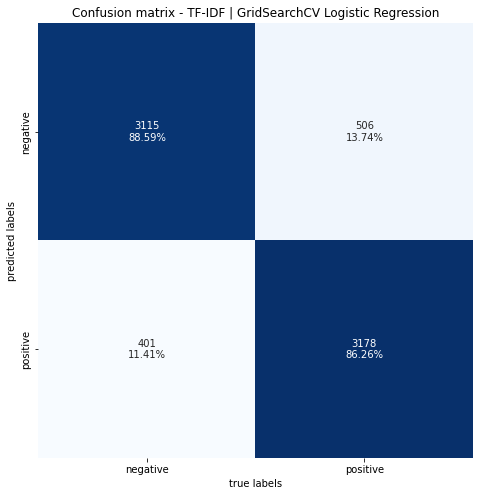

In [ ]:
# Evaluation report
graph_name = "TF-IDF | GridSearchCV Logistic Regression"
# Evaluation report
evaluation_report(
    logistic_regression_best_estimator_tfdidf_vectorizer,
    tfidf_vectorizer,
    x_val,
    y_val,
    graph_name
)

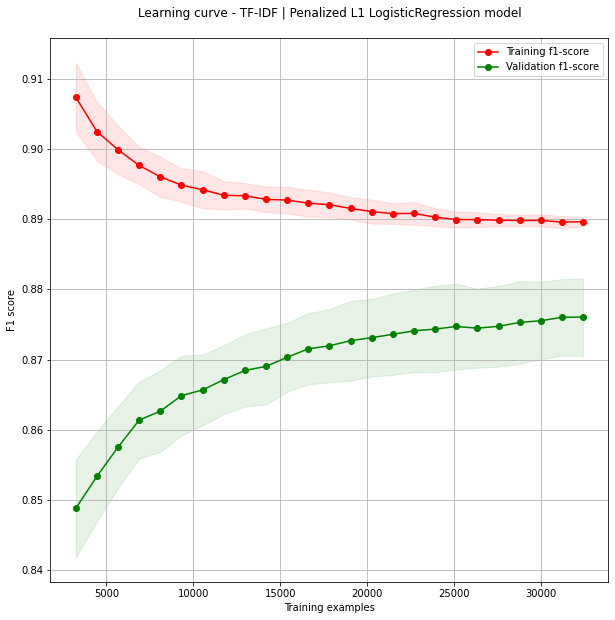

In [ ]:
plot_learning_curve( 
    n_splits = 25,
    test_size = 0.1,
    train_buckets = 25,
    trainable_vectors = all_trainable_vector_reviews,
    target_sample = y_train,
    model_estimator = logistic_regression_best_estimator_tfdidf_vectorizer,
    graph_name = graph_name
)

### Section 9: Word2Vec vectorizer | Model training

In [17]:
word2vec_trainable_vectors = pd.read_csv(checkpoint_7)

#### 9.1 Baseline model without regularization & cross-validation

In [ ]:
# model training
baseline_logistic_regression.fit(x_train_fit.values, y_train_fit.values)

In [ ]:
# Evaluation report
graph_name = "Word2Vec | Baseline Logistic Regression"
# Evaluation report
evaluation_report_word2vec(
    baseline_logistic_regression,
    x_val.values,
    y_val,
    graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = baseline_logistic_regression,
    graph_name = graph_name 
)

#### 9.2 Baseline model with L2 regularization

In [ ]:
# Logistic Regression with Penalty

# Classifier
logistic_regression_l2 = LogisticRegression(
    random_state = np.random.RandomState(0),
    penalty = "l2", #initially we won't use any regularization penalty technique.
    C = 0.8,
    solver = "lbfgs",
    multi_class  = "ovr",
    max_iter = 150,
    verbose = 10,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 23 epochs took 2 seconds
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      1000
    positive       0.89      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Evaluation metrics: Word2Vec | Baseline Logistic Regression with L2 Regularization 

precision score: 0.8920 
recall_score: 0.8920 
f1_score: 0.8920

model bias: 0.142
model variance: 0.25




[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


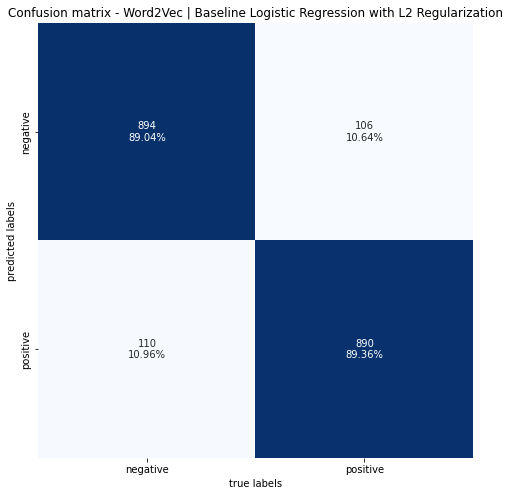

In [ ]:
# model training
logistic_regression_l2.fit(x_train_fit.values, y_train_fit.values)

# Evaluation report
graph_name = "Word2Vec | Baseline Logistic Regression with L2 Regularization"
# Evaluation report
evaluation_report_word2vec(
    logistic_regression_l2,
    x_val.values,
    y_val,
    graph_name
)

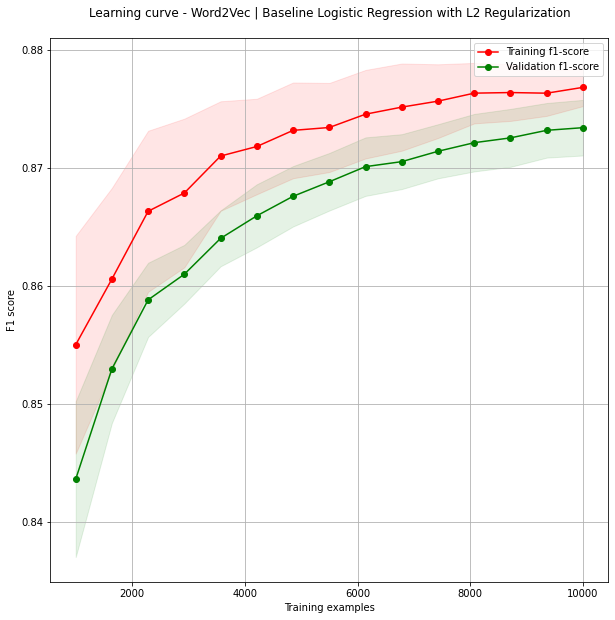

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name 
)

#### 9.3 GridSearchCV with regularization & cross-validation

In [ ]:
parameters_grid = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear','saga'],
    'C':list(np.linspace(0.5, 0.9, 3)),
    'max_iter':[int(x) for x in list(np.linspace(50, 150, 3))]
}

scoring = {
            'f1_scoring': 'f1',
            'precision_scoring': 'precision',
            'recall_scoring': 'recall'
          }
refit_score = scoring['f1_scoring']

# Create stratified and shuffled cross validation rounds
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=np.random.RandomState(0))

gridsearch_classifier = GridSearchCV(
    estimator=LogisticRegression(
        random_state=np.random.RandomState(0),
        multi_class="ovr",
        verbose=10,
        n_jobs=-1
    ),
    param_grid=parameters_grid,
    cv=cv,
    verbose=10,
    n_jobs=1,
    scoring=scoring,
    refit="f1_scoring",
    return_train_score=True
)

# Fit the gridsearch object
gridsearch_classifier.fit(x_train_fit.values, y_train_fit.values)
print(f'\nbest parameters: {gridsearch_classifier.best_params_}')

# Save Logistic Regression GridSearchCV model
logistic_regression_best_estimator_word2vec_vectorizer = gridsearch_classifier.best_estimator_
dump(logistic_regression_best_estimator_word2vec_vectorizer, "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/logistic_regression_best_estimator_word2vec_vectorizer.joblib")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START C=0.5, max_iter=50, penalty=l1, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 1/36] END C=0.5, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.872) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.875) total time=  40.9s
[CV 2/5; 1/36] START C=0.5, max_iter=50, penalty=l1, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 1/36] END C=0.5, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.885, test=0.881) total time=  16.6s
[CV 3/5; 1/36] START C=0.5, max_iter=50, penalty=l1, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 1/36] END C=0.5, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.879) recall_scoring: (train=0.886, test=0.876) total time=  15.4s
[CV 4/5; 1/36] START C=0.5, max_iter=50, penalty=l1, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 1/36] END C=0.5, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.881) recall_scoring: (train=0.885, test=0.876) total time=  14.2s
[CV 5/5; 1/36] START C=0.5, max_iter=50, penalty=l1, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 1/36] END C=0.5, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.875) total time=  14.4s
[CV 1/5; 2/36] START C=0.5, max_iter=50, penalty=l1, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.5s finished


[CV 1/5; 2/36] END C=0.5, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.871) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.874) total time=  17.1s
[CV 2/5; 2/36] START C=0.5, max_iter=50, penalty=l1, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV 2/5; 2/36] END C=0.5, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.874) recall_scoring: (train=0.884, test=0.881) total time=   7.4s
[CV 3/5; 2/36] START C=0.5, max_iter=50, penalty=l1, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV 3/5; 2/36] END C=0.5, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.876) precision_scoring: (train=0.877, test=0.878) recall_scoring: (train=0.885, test=0.875) total time=   7.2s
[CV 4/5; 2/36] START C=0.5, max_iter=50, penalty=l1, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.0s finished


[CV 4/5; 2/36] END C=0.5, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.881) recall_scoring: (train=0.885, test=0.876) total time=  12.4s
[CV 5/5; 2/36] START C=0.5, max_iter=50, penalty=l1, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished


[CV 5/5; 2/36] END C=0.5, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.874) total time=  12.6s
[CV 1/5; 3/36] START C=0.5, max_iter=50, penalty=l2, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 3/36] END C=0.5, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   2.0s
[CV 2/5; 3/36] START C=0.5, max_iter=50, penalty=l2, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 3/36] END C=0.5, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   2.1s
[CV 3/5; 3/36] START C=0.5, max_iter=50, penalty=l2, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 3/36] END C=0.5, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   2.0s
[CV 4/5; 3/36] START C=0.5, max_iter=50, penalty=l2, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 3/36] END C=0.5, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   2.0s
[CV 5/5; 3/36] START C=0.5, max_iter=50, penalty=l2, solver=liblinear...........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 3/36] END C=0.5, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.1s
[CV 1/5; 4/36] START C=0.5, max_iter=50, penalty=l2, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV 1/5; 4/36] END C=0.5, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   2.1s
[CV 2/5; 4/36] START C=0.5, max_iter=50, penalty=l2, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 2/5; 4/36] END C=0.5, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   3.2s
[CV 3/5; 4/36] START C=0.5, max_iter=50, penalty=l2, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 3/5; 4/36] END C=0.5, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   3.3s
[CV 4/5; 4/36] START C=0.5, max_iter=50, penalty=l2, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV 4/5; 4/36] END C=0.5, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   3.2s
[CV 5/5; 4/36] START C=0.5, max_iter=50, penalty=l2, solver=saga................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 5/5; 4/36] END C=0.5, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.0s
[CV 1/5; 5/36] START C=0.5, max_iter=100, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 5/36] END C=0.5, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.872) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.875) total time=  15.7s
[CV 2/5; 5/36] START C=0.5, max_iter=100, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 5/36] END C=0.5, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.885, test=0.881) total time=  15.9s
[CV 3/5; 5/36] START C=0.5, max_iter=100, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 5/36] END C=0.5, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.879) recall_scoring: (train=0.886, test=0.876) total time=  16.4s
[CV 4/5; 5/36] START C=0.5, max_iter=100, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 5/36] END C=0.5, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.881) recall_scoring: (train=0.885, test=0.876) total time=  14.1s
[CV 5/5; 5/36] START C=0.5, max_iter=100, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 5/36] END C=0.5, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.875) total time=  16.9s
[CV 1/5; 6/36] START C=0.5, max_iter=100, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished


[CV 1/5; 6/36] END C=0.5, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.871) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.874) total time=  13.3s
[CV 2/5; 6/36] START C=0.5, max_iter=100, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.9s finished


[CV 2/5; 6/36] END C=0.5, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.874) recall_scoring: (train=0.885, test=0.881) total time=  21.3s
[CV 3/5; 6/36] START C=0.5, max_iter=100, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV 3/5; 6/36] END C=0.5, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.876) precision_scoring: (train=0.877, test=0.878) recall_scoring: (train=0.885, test=0.874) total time=  11.7s
[CV 4/5; 6/36] START C=0.5, max_iter=100, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.9s finished


[CV 4/5; 6/36] END C=0.5, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.875, test=0.880) recall_scoring: (train=0.885, test=0.876) total time=  16.3s
[CV 5/5; 6/36] START C=0.5, max_iter=100, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV 5/5; 6/36] END C=0.5, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.875) total time=  14.3s
[CV 1/5; 7/36] START C=0.5, max_iter=100, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 7/36] END C=0.5, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   2.0s
[CV 2/5; 7/36] START C=0.5, max_iter=100, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 7/36] END C=0.5, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   2.0s
[CV 3/5; 7/36] START C=0.5, max_iter=100, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 7/36] END C=0.5, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   2.0s
[CV 4/5; 7/36] START C=0.5, max_iter=100, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 7/36] END C=0.5, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   2.3s
[CV 5/5; 7/36] START C=0.5, max_iter=100, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 7/36] END C=0.5, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.8s
[CV 1/5; 8/36] START C=0.5, max_iter=100, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV 1/5; 8/36] END C=0.5, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   3.6s
[CV 2/5; 8/36] START C=0.5, max_iter=100, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV 2/5; 8/36] END C=0.5, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   3.2s
[CV 3/5; 8/36] START C=0.5, max_iter=100, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 3/5; 8/36] END C=0.5, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   2.9s
[CV 4/5; 8/36] START C=0.5, max_iter=100, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 4/5; 8/36] END C=0.5, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   2.0s
[CV 5/5; 8/36] START C=0.5, max_iter=100, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV 5/5; 8/36] END C=0.5, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.1s
[CV 1/5; 9/36] START C=0.5, max_iter=150, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 9/36] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.872) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.875) total time=  13.2s
[CV 2/5; 9/36] START C=0.5, max_iter=150, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 9/36] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.874) recall_scoring: (train=0.885, test=0.881) total time=  16.2s
[CV 3/5; 9/36] START C=0.5, max_iter=150, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 9/36] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.877) precision_scoring: (train=0.877, test=0.879) recall_scoring: (train=0.886, test=0.876) total time=  13.5s
[CV 4/5; 9/36] START C=0.5, max_iter=150, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 9/36] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.881) recall_scoring: (train=0.885, test=0.876) total time=  14.1s
[CV 5/5; 9/36] START C=0.5, max_iter=150, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 9/36] END C=0.5, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.875) total time=  15.2s
[CV 1/5; 10/36] START C=0.5, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished


[CV 1/5; 10/36] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.871) precision_scoring: (train=0.877, test=0.868) recall_scoring: (train=0.886, test=0.874) total time=  13.1s
[CV 2/5; 10/36] START C=0.5, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.4s finished


[CV 2/5; 10/36] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.876, test=0.874) recall_scoring: (train=0.885, test=0.881) total time=  19.7s
[CV 3/5; 10/36] START C=0.5, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.1s finished


[CV 3/5; 10/36] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.876) precision_scoring: (train=0.877, test=0.878) recall_scoring: (train=0.885, test=0.874) total time=  11.5s
[CV 4/5; 10/36] START C=0.5, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.8s finished


[CV 4/5; 10/36] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.875, test=0.880) recall_scoring: (train=0.885, test=0.876) total time=  17.1s
[CV 5/5; 10/36] START C=0.5, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished


[CV 5/5; 10/36] END C=0.5, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.874, test=0.884) recall_scoring: (train=0.884, test=0.875) total time=  14.4s
[CV 1/5; 11/36] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 11/36] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   1.9s
[CV 2/5; 11/36] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 11/36] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   2.0s
[CV 3/5; 11/36] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 11/36] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   2.0s
[CV 4/5; 11/36] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 11/36] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   2.0s
[CV 5/5; 11/36] START C=0.5, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 11/36] END C=0.5, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.3s
[CV 1/5; 12/36] START C=0.5, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV 1/5; 12/36] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.871) precision_scoring: (train=0.872, test=0.866) recall_scoring: (train=0.886, test=0.876) total time=   3.3s
[CV 2/5; 12/36] START C=0.5, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV 2/5; 12/36] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.880) precision_scoring: (train=0.870, test=0.877) recall_scoring: (train=0.885, test=0.883) total time=   3.2s
[CV 3/5; 12/36] START C=0.5, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV 3/5; 12/36] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.873) precision_scoring: (train=0.871, test=0.874) recall_scoring: (train=0.884, test=0.872) total time=   3.1s
[CV 4/5; 12/36] START C=0.5, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 4/5; 12/36] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.877, test=0.878) precision_scoring: (train=0.869, test=0.879) recall_scoring: (train=0.884, test=0.877) total time=   2.0s
[CV 5/5; 12/36] START C=0.5, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV 5/5; 12/36] END C=0.5, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.876, test=0.875) precision_scoring: (train=0.869, test=0.880) recall_scoring: (train=0.884, test=0.870) total time=   2.0s
[CV 1/5; 13/36] START C=0.7, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 13/36] END C=0.7, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.889, test=0.879) total time=  21.6s
[CV 2/5; 13/36] START C=0.7, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 13/36] END C=0.7, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.874) recall_scoring: (train=0.886, test=0.883) total time=  18.2s
[CV 3/5; 13/36] START C=0.7, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 13/36] END C=0.7, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.878, test=0.880) recall_scoring: (train=0.887, test=0.880) total time=  17.0s
[CV 4/5; 13/36] START C=0.7, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 13/36] END C=0.7, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.877, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=  17.4s
[CV 5/5; 13/36] START C=0.7, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 13/36] END C=0.7, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.882) precision_scoring: (train=0.877, test=0.886) recall_scoring: (train=0.885, test=0.877) total time=  16.3s
[CV 1/5; 14/36] START C=0.7, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.0s finished


[CV 1/5; 14/36] END C=0.7, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.885, test=0.875) precision_scoring: (train=0.880, test=0.871) recall_scoring: (train=0.889, test=0.878) total time=  11.4s
[CV 2/5; 14/36] START C=0.7, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished


[CV 2/5; 14/36] END C=0.7, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.875) recall_scoring: (train=0.886, test=0.884) total time=   8.2s
[CV 3/5; 14/36] START C=0.7, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished


[CV 3/5; 14/36] END C=0.7, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.879, test=0.880) recall_scoring: (train=0.887, test=0.879) total time=   6.8s
[CV 4/5; 14/36] START C=0.7, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV 4/5; 14/36] END C=0.7, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.878, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=   7.5s
[CV 5/5; 14/36] START C=0.7, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.9s finished


[CV 5/5; 14/36] END C=0.7, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.882) precision_scoring: (train=0.877, test=0.887) recall_scoring: (train=0.886, test=0.876) total time=  10.3s
[CV 1/5; 15/36] START C=0.7, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 15/36] END C=0.7, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.2s
[CV 2/5; 15/36] START C=0.7, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 15/36] END C=0.7, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.1s
[CV 3/5; 15/36] START C=0.7, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 15/36] END C=0.7, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   2.2s
[CV 4/5; 15/36] START C=0.7, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 15/36] END C=0.7, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   2.7s
[CV 5/5; 15/36] START C=0.7, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 15/36] END C=0.7, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.7s
[CV 1/5; 16/36] START C=0.7, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 1/5; 16/36] END C=0.7, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.5s
[CV 2/5; 16/36] START C=0.7, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 2/5; 16/36] END C=0.7, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.5s
[CV 3/5; 16/36] START C=0.7, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 3/5; 16/36] END C=0.7, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   2.4s
[CV 4/5; 16/36] START C=0.7, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 4/5; 16/36] END C=0.7, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.878) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   2.5s
[CV 5/5; 16/36] START C=0.7, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 5/5; 16/36] END C=0.7, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.9s
[CV 1/5; 17/36] START C=0.7, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 17/36] END C=0.7, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.889, test=0.879) total time=  23.4s
[CV 2/5; 17/36] START C=0.7, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 17/36] END C=0.7, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.874) recall_scoring: (train=0.886, test=0.883) total time=  16.8s
[CV 3/5; 17/36] START C=0.7, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 17/36] END C=0.7, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.878, test=0.880) recall_scoring: (train=0.887, test=0.880) total time=  19.4s
[CV 4/5; 17/36] START C=0.7, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 17/36] END C=0.7, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.877, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=  17.0s
[CV 5/5; 17/36] START C=0.7, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 17/36] END C=0.7, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.882) precision_scoring: (train=0.877, test=0.886) recall_scoring: (train=0.885, test=0.877) total time=  17.1s
[CV 1/5; 18/36] START C=0.7, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.4s finished


[CV 1/5; 18/36] END C=0.7, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.889, test=0.879) total time=  15.8s
[CV 2/5; 18/36] START C=0.7, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished


[CV 2/5; 18/36] END C=0.7, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.875) recall_scoring: (train=0.886, test=0.883) total time=  14.2s
[CV 3/5; 18/36] START C=0.7, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.9s finished


[CV 3/5; 18/36] END C=0.7, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.879, test=0.880) recall_scoring: (train=0.887, test=0.880) total time=  15.3s
[CV 4/5; 18/36] START C=0.7, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.3s finished


[CV 4/5; 18/36] END C=0.7, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.877, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=  19.8s
[CV 5/5; 18/36] START C=0.7, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished


[CV 5/5; 18/36] END C=0.7, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.881) precision_scoring: (train=0.877, test=0.886) recall_scoring: (train=0.886, test=0.876) total time=  14.0s
[CV 1/5; 19/36] START C=0.7, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 19/36] END C=0.7, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.9s
[CV 2/5; 19/36] START C=0.7, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 19/36] END C=0.7, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.8s
[CV 3/5; 19/36] START C=0.7, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 19/36] END C=0.7, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   3.2s
[CV 4/5; 19/36] START C=0.7, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 19/36] END C=0.7, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   3.1s
[CV 5/5; 19/36] START C=0.7, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 19/36] END C=0.7, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.6s
[CV 1/5; 20/36] START C=0.7, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV 1/5; 20/36] END C=0.7, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.4s
[CV 2/5; 20/36] START C=0.7, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 2/5; 20/36] END C=0.7, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.4s
[CV 3/5; 20/36] START C=0.7, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 3/5; 20/36] END C=0.7, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   2.3s
[CV 4/5; 20/36] START C=0.7, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 4/5; 20/36] END C=0.7, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.878) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   2.3s
[CV 5/5; 20/36] START C=0.7, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 5/5; 20/36] END C=0.7, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.3s
[CV 1/5; 21/36] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 21/36] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.875) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.889, test=0.879) total time=  24.8s
[CV 2/5; 21/36] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 21/36] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.874) recall_scoring: (train=0.886, test=0.883) total time=  14.4s
[CV 3/5; 21/36] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 21/36] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.878, test=0.880) recall_scoring: (train=0.887, test=0.880) total time=  19.5s
[CV 4/5; 21/36] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 21/36] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.877, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=  14.8s
[CV 5/5; 21/36] START C=0.7, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 21/36] END C=0.7, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.881, test=0.882) precision_scoring: (train=0.877, test=0.886) recall_scoring: (train=0.885, test=0.877) total time=  19.5s
[CV 1/5; 22/36] START C=0.7, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.1s finished


[CV 1/5; 22/36] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.874) precision_scoring: (train=0.880, test=0.870) recall_scoring: (train=0.889, test=0.878) total time=  17.4s
[CV 2/5; 22/36] START C=0.7, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished


[CV 2/5; 22/36] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.879) precision_scoring: (train=0.878, test=0.875) recall_scoring: (train=0.886, test=0.883) total time=  20.6s
[CV 3/5; 22/36] START C=0.7, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.2s finished


[CV 3/5; 22/36] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.879, test=0.880) recall_scoring: (train=0.887, test=0.880) total time=  16.6s
[CV 4/5; 22/36] START C=0.7, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.9s finished


[CV 4/5; 22/36] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.877) precision_scoring: (train=0.877, test=0.881) recall_scoring: (train=0.887, test=0.873) total time=  19.2s
[CV 5/5; 22/36] START C=0.7, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.5s finished


[CV 5/5; 22/36] END C=0.7, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.881, test=0.881) precision_scoring: (train=0.877, test=0.886) recall_scoring: (train=0.886, test=0.876) total time=  15.9s
[CV 1/5; 23/36] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 23/36] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.8s
[CV 2/5; 23/36] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 23/36] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.6s
[CV 3/5; 23/36] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 23/36] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   2.8s
[CV 4/5; 23/36] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 23/36] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   2.9s
[CV 5/5; 23/36] START C=0.7, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 23/36] END C=0.7, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.2s
[CV 1/5; 24/36] START C=0.7, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 1/5; 24/36] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.881, test=0.874) precision_scoring: (train=0.874, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.3s
[CV 2/5; 24/36] START C=0.7, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 2/5; 24/36] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.878, test=0.880) precision_scoring: (train=0.872, test=0.876) recall_scoring: (train=0.885, test=0.885) total time=   2.3s
[CV 3/5; 24/36] START C=0.7, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV 3/5; 24/36] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.876) precision_scoring: (train=0.873, test=0.878) recall_scoring: (train=0.886, test=0.874) total time=   2.3s
[CV 4/5; 24/36] START C=0.7, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 4/5; 24/36] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.878) precision_scoring: (train=0.871, test=0.880) recall_scoring: (train=0.886, test=0.877) total time=   2.3s
[CV 5/5; 24/36] START C=0.7, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV 5/5; 24/36] END C=0.7, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.879) precision_scoring: (train=0.872, test=0.883) recall_scoring: (train=0.886, test=0.875) total time=   2.4s
[CV 1/5; 25/36] START C=0.9, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 25/36] END C=0.9, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.885, test=0.875) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.890, test=0.879) total time=  20.0s
[CV 2/5; 25/36] START C=0.9, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 25/36] END C=0.9, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.880, test=0.876) recall_scoring: (train=0.887, test=0.885) total time=  24.3s
[CV 3/5; 25/36] START C=0.9, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 25/36] END C=0.9, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.882) precision_scoring: (train=0.881, test=0.882) recall_scoring: (train=0.887, test=0.882) total time=  21.4s
[CV 4/5; 25/36] START C=0.9, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 25/36] END C=0.9, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.889, test=0.873) total time=  22.5s
[CV 5/5; 25/36] START C=0.9, max_iter=50, penalty=l1, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 25/36] END C=0.9, max_iter=50, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.887, test=0.881) total time=  28.4s
[CV 1/5; 26/36] START C=0.9, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.3s finished


[CV 1/5; 26/36] END C=0.9, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.886, test=0.876) precision_scoring: (train=0.881, test=0.873) recall_scoring: (train=0.890, test=0.878) total time=  12.7s
[CV 2/5; 26/36] START C=0.9, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV 2/5; 26/36] END C=0.9, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.881) precision_scoring: (train=0.879, test=0.876) recall_scoring: (train=0.887, test=0.886) total time=   7.0s
[CV 3/5; 26/36] START C=0.9, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished


[CV 3/5; 26/36] END C=0.9, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.881) precision_scoring: (train=0.881, test=0.881) recall_scoring: (train=0.888, test=0.881) total time=   6.9s
[CV 4/5; 26/36] START C=0.9, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV 4/5; 26/36] END C=0.9, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.889, test=0.874) total time=   8.3s
[CV 5/5; 26/36] START C=0.9, max_iter=50, penalty=l1, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished


[CV 5/5; 26/36] END C=0.9, max_iter=50, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.888, test=0.881) total time=  10.0s
[CV 1/5; 27/36] START C=0.9, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 27/36] END C=0.9, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.878) total time=   2.1s
[CV 2/5; 27/36] START C=0.9, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 27/36] END C=0.9, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   2.2s
[CV 3/5; 27/36] START C=0.9, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 27/36] END C=0.9, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.887, test=0.876) total time=   2.2s
[CV 4/5; 27/36] START C=0.9, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 27/36] END C=0.9, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   2.2s
[CV 5/5; 27/36] START C=0.9, max_iter=50, penalty=l2, solver=liblinear..........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 27/36] END C=0.9, max_iter=50, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   2.2s
[CV 1/5; 28/36] START C=0.9, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 1/5; 28/36] END C=0.9, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   2.8s
[CV 2/5; 28/36] START C=0.9, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 2/5; 28/36] END C=0.9, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   2.7s
[CV 3/5; 28/36] START C=0.9, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV 3/5; 28/36] END C=0.9, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.886, test=0.876) total time=   3.1s
[CV 4/5; 28/36] START C=0.9, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV 4/5; 28/36] END C=0.9, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   3.5s
[CV 5/5; 28/36] START C=0.9, max_iter=50, penalty=l2, solver=saga...............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV 5/5; 28/36] END C=0.9, max_iter=50, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.880) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   4.5s
[CV 1/5; 29/36] START C=0.9, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 29/36] END C=0.9, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.885, test=0.875) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.890, test=0.879) total time=  17.7s
[CV 2/5; 29/36] START C=0.9, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 29/36] END C=0.9, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.880, test=0.876) recall_scoring: (train=0.887, test=0.885) total time=  29.4s
[CV 3/5; 29/36] START C=0.9, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 29/36] END C=0.9, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.882) precision_scoring: (train=0.881, test=0.882) recall_scoring: (train=0.887, test=0.882) total time=  19.8s
[CV 4/5; 29/36] START C=0.9, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 29/36] END C=0.9, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.889, test=0.873) total time=  21.8s
[CV 5/5; 29/36] START C=0.9, max_iter=100, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 29/36] END C=0.9, max_iter=100, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.887, test=0.881) total time=  28.2s
[CV 1/5; 30/36] START C=0.9, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished


[CV 1/5; 30/36] END C=0.9, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.885, test=0.876) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.890, test=0.879) total time=  13.0s
[CV 2/5; 30/36] START C=0.9, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.8s finished


[CV 2/5; 30/36] END C=0.9, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.879, test=0.875) recall_scoring: (train=0.887, test=0.885) total time=  20.2s
[CV 3/5; 30/36] START C=0.9, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished


[CV 3/5; 30/36] END C=0.9, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.881) precision_scoring: (train=0.881, test=0.881) recall_scoring: (train=0.887, test=0.881) total time=  12.9s
[CV 4/5; 30/36] START C=0.9, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.2s finished


[CV 4/5; 30/36] END C=0.9, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.888, test=0.872) total time=  17.6s
[CV 5/5; 30/36] START C=0.9, max_iter=100, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished


[CV 5/5; 30/36] END C=0.9, max_iter=100, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.887, test=0.880) total time=  13.0s
[CV 1/5; 31/36] START C=0.9, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 31/36] END C=0.9, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.878) total time=   2.1s
[CV 2/5; 31/36] START C=0.9, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 31/36] END C=0.9, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   2.2s
[CV 3/5; 31/36] START C=0.9, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 31/36] END C=0.9, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.887, test=0.876) total time=   2.2s
[CV 4/5; 31/36] START C=0.9, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 31/36] END C=0.9, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   2.2s
[CV 5/5; 31/36] START C=0.9, max_iter=100, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 31/36] END C=0.9, max_iter=100, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   2.8s
[CV 1/5; 32/36] START C=0.9, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV 1/5; 32/36] END C=0.9, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   4.7s
[CV 2/5; 32/36] START C=0.9, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 2/5; 32/36] END C=0.9, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   4.1s
[CV 3/5; 32/36] START C=0.9, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV 3/5; 32/36] END C=0.9, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.886, test=0.876) total time=   2.7s
[CV 4/5; 32/36] START C=0.9, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 4/5; 32/36] END C=0.9, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   2.8s
[CV 5/5; 32/36] START C=0.9, max_iter=100, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV 5/5; 32/36] END C=0.9, max_iter=100, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.880) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   2.6s
[CV 1/5; 33/36] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 33/36] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.885, test=0.875) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.890, test=0.879) total time=  19.7s
[CV 2/5; 33/36] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 33/36] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.880, test=0.876) recall_scoring: (train=0.887, test=0.885) total time=  27.7s
[CV 3/5; 33/36] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 33/36] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.882) precision_scoring: (train=0.881, test=0.882) recall_scoring: (train=0.887, test=0.882) total time=  21.7s
[CV 4/5; 33/36] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 33/36] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.889, test=0.873) total time=  19.7s
[CV 5/5; 33/36] START C=0.9, max_iter=150, penalty=l1, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 33/36] END C=0.9, max_iter=150, penalty=l1, solver=liblinear; f1_scoring: (train=0.883, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.887, test=0.881) total time=  27.4s
[CV 1/5; 34/36] START C=0.9, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.4s finished


[CV 1/5; 34/36] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.885, test=0.875) precision_scoring: (train=0.881, test=0.872) recall_scoring: (train=0.890, test=0.879) total time=  20.8s
[CV 2/5; 34/36] START C=0.9, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.4s finished


[CV 2/5; 34/36] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.883, test=0.880) precision_scoring: (train=0.880, test=0.876) recall_scoring: (train=0.887, test=0.885) total time=  18.8s
[CV 3/5; 34/36] START C=0.9, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.6s finished


[CV 3/5; 34/36] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.881) precision_scoring: (train=0.881, test=0.881) recall_scoring: (train=0.887, test=0.881) total time=  20.1s
[CV 4/5; 34/36] START C=0.9, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.7s finished


[CV 4/5; 34/36] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.884, test=0.878) precision_scoring: (train=0.879, test=0.883) recall_scoring: (train=0.889, test=0.873) total time=  23.1s
[CV 5/5; 34/36] START C=0.9, max_iter=150, penalty=l1, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.1s finished


[CV 5/5; 34/36] END C=0.9, max_iter=150, penalty=l1, solver=saga; f1_scoring: (train=0.882, test=0.884) precision_scoring: (train=0.878, test=0.888) recall_scoring: (train=0.887, test=0.881) total time=  18.5s
[CV 1/5; 35/36] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 1/5; 35/36] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.878) total time=   2.1s
[CV 2/5; 35/36] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 2/5; 35/36] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   2.3s
[CV 3/5; 35/36] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 3/5; 35/36] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.887, test=0.876) total time=   2.1s
[CV 4/5; 35/36] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 4/5; 35/36] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   2.7s
[CV 5/5; 35/36] START C=0.9, max_iter=150, penalty=l2, solver=liblinear.........


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs))


[LibLinear][CV 5/5; 35/36] END C=0.9, max_iter=150, penalty=l2, solver=liblinear; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   2.8s
[CV 1/5; 36/36] START C=0.9, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV 1/5; 36/36] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.882, test=0.874) precision_scoring: (train=0.876, test=0.869) recall_scoring: (train=0.887, test=0.879) total time=   4.8s
[CV 2/5; 36/36] START C=0.9, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV 2/5; 36/36] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.879, test=0.880) precision_scoring: (train=0.873, test=0.875) recall_scoring: (train=0.886, test=0.886) total time=   4.0s
[CV 3/5; 36/36] START C=0.9, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 3/5; 36/36] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.879) precision_scoring: (train=0.874, test=0.881) recall_scoring: (train=0.886, test=0.876) total time=   2.9s
[CV 4/5; 36/36] START C=0.9, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV 4/5; 36/36] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.878) precision_scoring: (train=0.873, test=0.880) recall_scoring: (train=0.887, test=0.877) total time=   2.9s
[CV 5/5; 36/36] START C=0.9, max_iter=150, penalty=l2, solver=saga..............


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV 5/5; 36/36] END C=0.9, max_iter=150, penalty=l2, solver=saga; f1_scoring: (train=0.880, test=0.880) precision_scoring: (train=0.873, test=0.885) recall_scoring: (train=0.887, test=0.874) total time=   2.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 8 seconds

best parameters: {'C': 0.9, 'max_iter': 50, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/logistic_regression_best_estimator_word2vec_vectorizer.joblib']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      3600
    positive       0.88      0.88      0.88      3600

    accuracy                           0.88      7200
   macro avg       0.88      0.88      0.88      7200
weighted avg       0.88      0.88      0.88      7200

Evaluation metrics: Word2Vec | GridSearchCV Logistic Regression 

precision score: 0.8788 
recall_score: 0.8788 
f1_score: 0.8787

model bias: 0.1288
model variance: 0.25




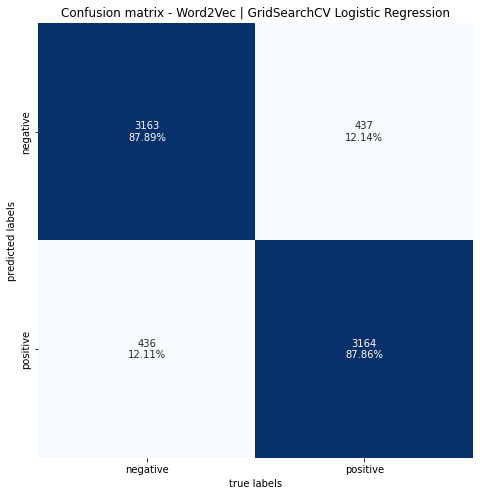

In [ ]:
# Evaluation report
graph_name = "Word2Vec | GridSearchCV Logistic Regression"
# Evaluation report
evaluation_report_word2vec(
    logistic_regression_best_estimator_word2vec_vectorizer,
    x_val.values,
    y_val,
    graph_name
)

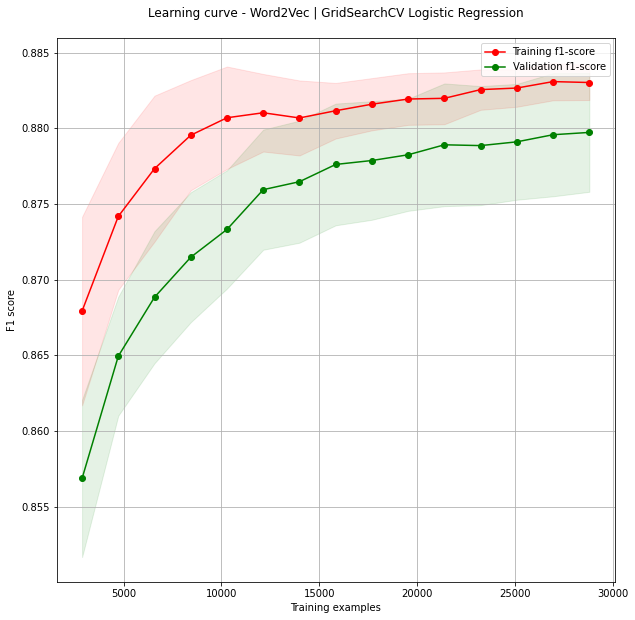

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.2,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_best_estimator_word2vec_vectorizer,
    graph_name = graph_name
)

#### 9.4 Reduce the training samples in an attempt to reduce the generalization gap.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    word2vec_trainable_vectors,
    y_features,
    shuffle=True,
    test_size=0.5, #0.1, 0.4
    random_state=np.random.RandomState(0),
    stratify = y_features
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train_fit, x_val, y_train_fit, y_val = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.1, #0.2, 0.3
    random_state=np.random.RandomState(0),
    stratify = y_train
)

print("x_train_fit shape: ", x_train_fit.shape)
print("x_val shape: ", x_val.shape)
print("y_train_fit shape: ", y_train_fit.shape)
print("y_val shape: ", y_val.shape)

In [107]:
# Baseline model classifier

# Classifier
baseline_logistic_regression = LogisticRegression(
    random_state = 123,
    penalty = 'none',
    solver = "lbfgs",
    multi_class  = "ovr",
    max_iter = 150,
    verbose = 1,
    n_jobs = -1
)

In [ ]:
# model training
baseline_logistic_regression.fit(x_train_fit.values, y_train_fit.values)

In [ ]:
dump(baseline_logistic_regression, "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/baseline_logistic_regression.joblib")

In [ ]:
# Evaluation report
graph_name = "Word2Vec | Baseline Logistic Regression"
# Evaluation report
evaluation_report_word2vec(
    baseline_logistic_regression,
    x_val.values,
    y_val,
    graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = baseline_logistic_regression,
    graph_name = graph_name 
)

#### 9.5 Skipgram 64 vector size & token frequency 100

In [ ]:
word2vec_trainable_vectors = pd.read_csv(checkpoint_10)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    word2vec_trainable_vectors,
    y_features,
    shuffle=True,
    test_size=0.5, #0.1, 0.4
    random_state=np.random.RandomState(0),
    stratify = y_features
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train_fit, x_val, y_train_fit, y_val = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2, #0.2, 0.3
    random_state=np.random.RandomState(0),
    stratify = y_train
)

print("x_train_fit shape: ", x_train_fit.shape)
print("x_val shape: ", x_val.shape)
print("y_train_fit shape: ", y_train_fit.shape)
print("y_val shape: ", y_val.shape)

In [ ]:
# Logistic Regression with Penalty

# Classifier
logistic_regression_l2 = LogisticRegression(
    random_state = np.random.RandomState(0),
    penalty = "l2", #initially we won't use any regularization penalty technique.
    C = 0.1,
    solver = "lbfgs",
    multi_class  = "ovr",
    max_iter = 150,
    verbose = 10,
    n_jobs = -1
)

# Fit the model
logistic_regression_l2.fit(x_train_fit.values, y_train_fit.values)

# Evaluation report
graph_name = "Word2Vec | Baseline Logistic Regression L2 Regularization"
# Evaluation report
evaluation_report_word2vec(
    logistic_regression_l2,
    x_val.values,
    y_val,
    graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.2,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name
)

#### 9.6 CBoW Word2Vec vectorization

In [ ]:
word2vec_trainable_vectors = pd.read_csv(checkpoint_12)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    word2vec_trainable_vectors,
    y_features,
    shuffle=True,
    test_size=0.5, #0.1, 0.4
    random_state=np.random.RandomState(0),
    stratify = y_features
)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train_fit, x_val, y_train_fit, y_val = train_test_split(
    x_train,
    y_train,
    shuffle=True,
    test_size=0.2, #0.2, 0.3
    random_state=np.random.RandomState(0),
    stratify = y_train
)

print("x_train_fit shape: ", x_train_fit.shape)
print("x_val shape: ", x_val.shape)
print("y_train_fit shape: ", y_train_fit.shape)
print("y_val shape: ", y_val.shape)

x_train shape:  (20000, 300)
x_test shape:  (20000, 300)
y_train shape:  (20000,)
y_test shape:  (20000,)
x_train_fit shape:  (16000, 300)
x_val shape:  (4000, 300)
y_train_fit shape:  (16000,)
y_val shape:  (4000,)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 18 epochs took 1 seconds
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      1000
    positive       0.89      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Evaluation metrics: Word2Vec | Baseline Logistic Regression L2 Regularization 

precision score: 0.8910 
recall_score: 0.8910 
f1_score: 0.8910

model bias: 0.141
model variance: 0.25




[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


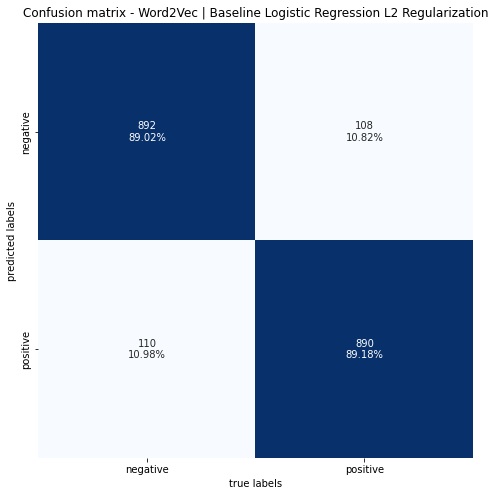

In [ ]:
# Logistic Regression with Penalty

# Classifier
logistic_regression_l2 = LogisticRegression(
    random_state = np.random.RandomState(0),
    penalty = "l2", #initially we won't use any regularization penalty technique.
    C = 0.5,
    solver = "saga",
    multi_class  = "ovr",
    max_iter = 1000, #doesn't seem to really affect the model results after testing values like [10,25,50,150,200,1000]
    verbose = 10,
    n_jobs = -1
)

# Fit the model
logistic_regression_l2.fit(x_train_fit.values, y_train_fit.values)

# Evaluation report
graph_name = "Word2Vec | Baseline Logistic Regression L2 Regularization"
# Evaluation report
evaluation_report_word2vec(
    logistic_regression_l2,
    x_val.values,
    y_val,
    graph_name
)

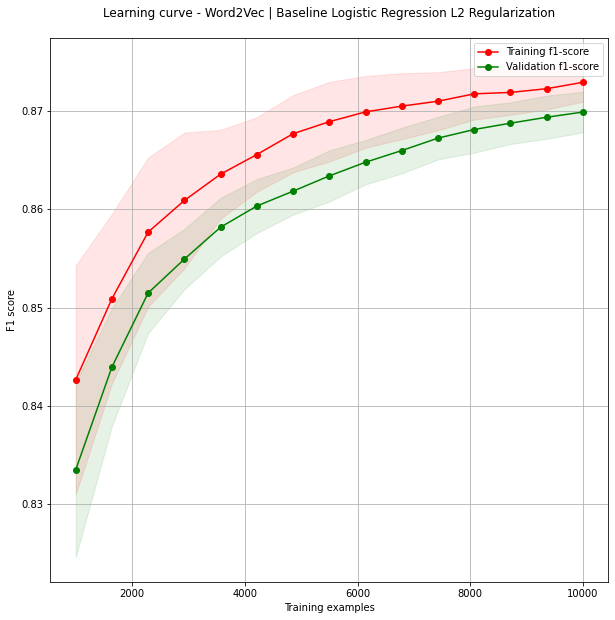

In [ ]:
plot_learning_curve(
    n_splits = 20,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name
)

### Section 10: Conclusions from the training so far

* Word2Vec vectorization had the best training performance in terms of ```f1_score```. However, it also had a poor performance in its learning curve. The model classifier trained was overfitting.

* TF-IDF vectorizer did well but also overfitted over the training samples.

* CountVectorizer even though having the lowest ```f1-score``` performance compared to the other two vectorization algorithms, did well in term of generalization in the learning curves. The model classifier trained with this algorithm had the lowest bias and variance results.

* Applying ```l1``` regularization didn't improve the prediction performance of the model classifier.

* Applying ```l2``` regularization slightly improved the baseline classifer performance. Ridge regression was selected as a preferrable regularization technique from hyper-parameter tuning and other tests.

* The average bias of logistic regression classifiers was ~0.11-0.12. Close to zero, denoting no sever underfitting of the model classifiers.

* The average variance of logistic regression classifiers was ~0.24-0.25. A slightly high variance value, denoting a possibility of overfitting algorithms. The notable fact is that after applying techniques like ```regularization```, ```cross-validation``` and undersampling, I didn't spot any drop in the variance of the logistic regression classifiers.

* Even though non-baseline logistic regression experiments had slightly higher f1-scores, most of the classifiers failed to improve the bias of the test-scores and further generalized the model classifier. What it was also observed, which is quite interesting, was the behavior of regularization, cross-validation and different vectorizers in the classification report of different logistic classifiers. The ratio of true with correct predictions remained the same, while the ratio of wrong observations changed based on regularization or different vectorizers. Basically, the results didn't improve significantly because the classifiers once misclassified more negative reviews or in other situations misclassified more positive reviews. So, the changes applied, regularization, different vectorizers, cross-validation, didn't increase the correct predictions but rather affected the ratio of the incorrect predictions.

* Overall, I will select the <u>**Word2Vec**</u> as the vectorization method for the trainable parameters of the sample. This is because the training samples vectorized with the Word2Vec model demonstrated the smallest generalization gap in the learning curves for the baseline logistic regression model.

* Overall, the regularization and hyper-parameter tuning on the baseline logistic regression model did not improve the overfitting and generalization of the model classifier. As a result, the baseline model classifier will be the  best choice so far. With sufficient bias-variance and f1-score metric after applying Word2Vec vectorization.

### Section 11: Applying Random Forest and Gradient Boosted Classification algorithms

Gradient boosted algorithms are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting.

#### 11.1 Random Forest Classifier 
(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- n_estimators = 150 (default=100)
- criterion    = gini (default)
- oob_score    = true
- n_jobs       = -1
- min_samples_split = 15
- random_state = 123
- max_samples  = 0.5 (since bootstrap is True)
- class_weight = "balanced"

All the other parameters are set to their default values.

In [ ]:
randomforest_classifier = RandomForestClassifier(
    n_estimators = 150,
    criterion = "entropy",
    oob_score = False,
    n_jobs = -1,
    min_samples_split = 2,
    random_state = np.random.RandomState(0),
    max_samples = None,
    class_weight = None,
    verbose = 10
)
randomforest_classifier.fit(x_train_fit.values, y_train_fit.values)

In [ ]:
# Evaluation report
graph_name = "Word2Vec | Random Forest Classifier"
# Evaluation report
evaluation_report_word2vec(
    randomforest_classifier,
    x_val.values,
    y_val,
    graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = randomforest_classifier,  
    graph_name = graph_name 
)

#### 11.2 Gradient Boosting Trees

In [ ]:
gradientboosting_classifier = GradientBoostingClassifier(
    loss = "exponential",
    learning_rate = 0.01,
    n_estimators = 250,
    subsample = 0.85,
    criterion = "squared_error",
    max_depth = 300,
    random_state = np.random.RandomState(0),
    max_features = 300,
    n_iter_no_change = 6,
    verbose = 10
)
gradientboosting_classifier.fit(x_train_fit.values, y_train_fit.values)

In [ ]:
dump(gradientboosting_classifier, "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/gradient_boosting_classifier_word2vec.joblib")

In [27]:
gradientboosting_classifier = load("drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/gradient_boosting_classifier_word2vec.joblib")

In [ ]:
# Evaluation report
graph_name = "Word2Vec | Gradient Boosting Classifier"
# Evaluation report
evaluation_report_word2vec(
    gradientboosting_classifier,
    x_val.values,
    y_val,
    graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 15,
    test_size = 0.2,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = gradientboosting_classifier,
    graph_name = graph_name
)

In [ ]:
plot_learning_curve(
    n_splits = 20,
    test_size = 0.5,
    train_buckets = 15,
    trainable_vectors = x_train.values,
    target_sample = y_train,
    model_estimator = logistic_regression_l2,
    graph_name = graph_name
)

### 12. Next steps / Future Suggestions

* Dimensionality reductions on (PCA) on the word embeddings vector of Word2Vec model.

* Apply stricter and more sophisticated regularization techniques like elasticnet.

### 13. Model Evaluation on test set / Grader scoring sample

In [137]:
def grader_scoring(data_filepath:str, word2vec_model_filepath:str, word2vec_embeddings_filepath:str, model_filepath:str):
  """
  Definition
  ---------
  A method to help the grader score a never-seen-before dataset of movie reviews.

  Aguments
  ---------
  data_filepath : The path were the file with reviews exist. An assumption made is the existense of a column named "review" in the argument passed.
  word2vec_model_filepat : The path of the word2vec model to vectorize the test samples.
  word2vec_embeddings_filepath : The path to save the word2vec embeddings.
  model_filepath : The path of the model scorer to score new samples.

  Output
  ---------
  Evaluation report of the scored samples.
  """

  # 1. Import sample
  test_sample = pd.read_csv(os.path.join(os.getcwd(), data_filepath), sep="\t", header=0)

  # 2. Transform target column to binary
  target_column = 'rating'
  conditions = [ (test_sample[target_column] >= 0.0) & (test_sample[target_column] <= 4.0)
                ,(test_sample[target_column] >= 7.0) & (test_sample[target_column] <= 10.0) 
               ]
  choices = [ 0, 1 ]

  test_sample['target'] = np.select(conditions, choices)

  # 3. Text preprocessing
  cleaned_test_sample = text_preprocessing(test_sample)

  cleaned_test_sample["normalized_review_tokens"] = cleaned_test_sample["normalized_review"].apply(lambda review: review.split(' '))

  # 4. Load word2vec model for trasnforming the test samples
  sg_w2v_model = Word2Vec.load(word2vec_model_filepath)

  with open(word2vec_embeddings_filepath, 'w+') as word2vec_file:

    for index, row in cleaned_test_sample.iterrows():

      # model_vector = (np.mean([sg_w2v_model.wv[token] for token in row["normalized_review_tokens"]], axis=0)).tolist()
      model_vector = (np.mean([sg_w2v_model.wv[token] if token in sg_w2v_model.wv.vocab else np.zeros(sg_w2v_model.wv.vector_size) for token in row["normalized_review_tokens"]], axis=0)).tolist()
      
      if index == 0:
          header = ",".join(str(ele) for ele in range(sg_w2v_model.wv.vector_size))
          word2vec_file.write(header)
          word2vec_file.write("\n")
      # Check if the line exists else it is vector of zeros
      if type(model_vector) is list:  
          line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
      else:
          line1 = ",".join([str(0) for i in range(sg_w2v_model.wv.vector_size)])
      word2vec_file.write(line1)
      word2vec_file.write('\n')
  
  # 5. Use word embeddings
  word2vec_embeddings = pd.read_csv(word2vec_embeddings_filepath)

  # 6. Load model scorer
  score_model = load(model_filepath) #save the model classifier in your local Drive file system and load the model.
  
  # 7. Evaluation report
  graph_name = "Word2Vec | Scoring Test samples"
  evaluation_report_word2vec(
      score_model,
      word2vec_embeddings.values,
      cleaned_test_sample['target'],
      graph_name
  )

  # 8. Mean Accuracy score of predictions
  print("Mean Accuracy score: ", score_model.score(word2vec_embeddings.values, cleaned_test_sample['target']) )

   Unnamed: 0                                               url  rating  \
0           0  http://www.imdb.com/title/tt0473356/usercomments     2.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review  \
0  I really have problems rating this movie. It is directed brilliantly, there is obviously a lot of money in it. Gere and Danes are intense (although her screen personality could use a bit more

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After cleaning
0                I really have problems rating this movie It is directed brilliantly there is obviously a lot of money in it Gere and Danes are intense although her screen personality could use a bit more defining and spicing up editing and cinematography are excellent On the other hand it is one of those really really sick movies where one cannot help but wonder whether the director himself likes to stage specific scenes and yes one cannot help but wonder how many copycats will such a movie inspire In purely artistic terms it is a but I really have to ask myself who these people are giving their money to produce such a movie
1                                                                                                                                                                                                                                                                                                                                                   

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After removing stop words
0                         really problems rating movie directed brilliantly obviously lot money gere danes intense although screen personality could use bit defining spicing editing cinematography excellent hand one really really sick movies one help wonder whether director likes stage specific scenes yes one help wonder many copycats movie inspire purely artistic terms really ask people giving money produce movie
1                                                                                                                                                                                                                                                                                       never seen terrible performances life everyone entire film absolute rubbish one decent actoractress whole film joke reminded drama school
2    movies like originals album oriented rock stations music used like repetitive boring drained original energy committee cor

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After text normalization-lemmatization
0                          really problem rating movie direct brilliantly obviously lot money gere dane intense although screen personality could use bit define spice edit cinematography excellent hand one really really sick movie one help wonder whether director like stage specific scene yes one help wonder many copycat movie inspire purely artistic term really ask people give money produce movie
1                                                                                                                                                                                                                                                                          never see terrible performance life everyone entire film absolute rubbish one decent actoractress whole film joke remind drama school
2    movie like original album orient rock station music use like repetitive boring drain original energy committee corporate drone glad aragorn typ

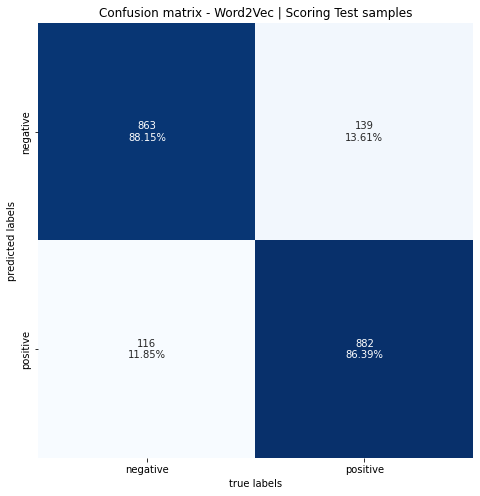

In [136]:
grader_scoring(
    data_filepath="drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/test_sample.csv",
    word2vec_model_filepath="drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/word2vec_300size.model",
    word2vec_embeddings_filepath="drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/test_review_word2vec_embeddings.csv",
    model_filepath="drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/baseline_logistic_regression.joblib"
)